# Case Study

## Klassifikation relevanter Apps für Life Sciences

von Iuliia G. (07. August 2025)

* **Ziel**
  > Entwickle einen Python-basierten Klassifikator in einem One-Shot- / Low-ResourceSetting, um zu bestimmen, welche Apps für die Branchen Life
Science, MedTech und Pharma relevant sind oder welche Apps GxP relevant sein könnten.   
  >   Identifiziere und erläutere die relevantesten Features für die Klassifikation.   
  >   Entwickle mindestens zwei unterschiedliche Klassifikationsansätze (z. B. ML-basiert, Vektorraum-Ansätze).   
  >   Annotiere und verifiziere die Daten
  >   Visualisiere deine Ergebnisse (z. B. Confusion Matrix, Feature-Importances, Embedding-Plots).   
  >   Dokumentiere deine Strategie, Methodenwahl und Annahmen klar. 
  
* **Miene Strategie, Methodenwahl und Annahmen**   
  1. Datei herunterladen und Inhalt und Struktur ansehen.   
  2. Ich habe eine Transponierung vorgenommen, da die Zeilen und Spalten vertauscht waren. Anschließend habe ich die Spalte mit *fioriId* der Übersichtlichkeit halber an den Anfang verschoben. In der neuen Struktur sind die Daten nun verständlicher und lassen sich besser bearbeiten.   
  3. Anzeige der Struktur und des Inhalts des Datenrahmens. Bestimmung der Anzahl der Zeilen, der Anzahl der fehlenden Daten und der eindeutigen Werte für jedes Attribut. Zuerst habe ich auf fehlende Daten überprüft, aber für einige Felder, wie *AppKeyFeatures, BusinessRoleDescription, LeadingLob, PFDBIndustry, SolutionsCapability, Subtitle*, wird angegeben, dass keine Daten fehlen und die Anzahl mit der Anzahl der Zeilen übereinstimmt. In der Vorschau ist jedoch zu sehen, dass die Felder leer sind, daher habe ich eine zusätzliche Überprüfung auf leere Zeilen oder Leerzeichen durchgeführt. Das Ergebnis war eine sehr große Anzahl von Spalten, in denen die Felder überhaupt nicht ausgefüllt waren.      
  4. Es wurde auch festgestellt, dass keine Daten mit eindeutigen Labels vorhanden sind und die vorhandenen Daten keine eindeutige Zuordnung zu den Bereichen Life Science, MedTech und Pharma zulassen. Daher wurde beschlossen, eine binäre Klassifizierung mit folgenden Bedingungen durchzuführen: 1 – GxP-Anwendung, 0 – keine GxP-Anwendung (Andere).   
  5. Auf der Grundlage von Punkt 3 wurden relevante Merkmale ausgewählt – alle außer *index, AppKeyFeatures, ExternalReleaseName, Information, releaseId, ScopeItemID, Subtitle*, da diese meiner Meinung nach nicht aussagekräftig sind (einige haben eine einzige Bedeutung für alle Zeilen, andere nur mit Kommas oder Ländernamen, usw.). Aus diesen wird ein separater Dataframe *features_fiori* erstellt.   
  6. Der nächste Schritt ist die Verarbeitung der Daten dieses Dataframes. Mit der Funktion wurden Zeilenumbrüche und Tabulatorzeichen, Leerzeichen am Anfang und Ende der Zeile sowie HTML-Entitäten wie &nbsp entfernt. Außerdem wurden mehrere Leerzeichen durch ein einziges ersetzt und alle Wörter in Kleinbuchstaben umgewandelt.   
  7. Nach der Verarbeitung wird die Spalte *merged_text* erstellt, die den zusammengeführten Text aus allen relevanten Features enthält. Alle weiteren Schritte werden mit dieser Spalte durchgeführt.   
     1. **Ansatz 1: Vektorraum**   
     * Für die Angabe der Labels wird die Spalte *label_GxP* erstellt.
     * Nun muss ein Datensatz für das Training erstellt und mit Labels versehen werden. Dazu wird zunächst die Embedding-Technik verwendet. Embeddings kodieren die Bedeutung von Texten und ermöglichen die Suche nach ähnlichen Wörtern oder Zeilen, auch wenn überhaupt keine Anmerkungen vorhanden sind. Daher wurde diese Technik verwendet, um ähnliche Wörter zwischen der zusammengeführten Spalte *merged_text* und einer Liste von Schlüsselwörtern zu finden, die sich auf den Bereich GxP beziehen könnten.
     * Für diese Methode wurde die Bibliothek *SentenceTransformer* ausgewählt. Sie eignet sich für Fälle, in denen überhaupt keine Annotation vorhanden ist – für die Suche nach ähnlichen Wörtern oder Zeilen. Sie erstellt einen Textvektor, vergleicht ihn mit dem Vektor der vorgegebenen Schlüsselwörter und berechnet dann den Kosinusabstand zwischen ihnen. Diejenigen mit dem geringsten Kosinusabstand sind die semantisch ähnlichsten. Das heißt, je höher der erhaltene Wert, desto näher liegen die verglichenen Vektoren in ihrer Bedeutung.   
  Dazu habe ich das vortrainierte Modell *all-mpnet-base-v2* ausgewählt, das als das beste gilt, aber nicht das schnellste ist und einen durchschnittlichen Speicherbedarf hat. Mit *all-mpnet-base-v2* dauerte der Embedding-Vorgang für alle *merged_text*-Zeilen 1 Stunde und 50 Minuten. Ich habe auch das beliebte *all-MiniLM-L6-v2* ausprobiert (nur 15 Minuten), das schneller ist, aber die Qualität scheint schlechter zu sein.
     * Für den Referenzvektor, mit dem der Text verglichen wird, wurden die Schlüsselwörter in zwei Schritten ausgewählt: Zunächst wurden im ersten Schritt Schlüsselwörter verwendet (die Ähnlichkeitswerte lagen bei maximal 0.5). Auf dieser Grundlage wurde eine Spalte *similarity_score* mit Werten ab 0.45 erstellt, die sortiert wurde. Anschließend wurden daraus manuell 15 für GxP relevante Anwendungsindizes ausgewählt und überprüft. Aus diesen wurde erneut ein Referenzvektor erstellt und die Kosinusabstände zum Text berechnet. Das Ergebnis wurde in der Spalte *similarity_score_improved* gespeichert.
     * Die erhaltenen Ergebnisse werden angezeigt. Aus den Daten geht hervor, dass die Anzahl der Zeilen, bei denen *similarity_score_improved* im interval von 0.80 bis 1.0 liegt, 43 beträgt. Ich werde 50 nehmen. In Fällen, in denen *similarity_score_improved* unter 0.20 liegt, sind es 139 Zeilen. Aus den verfügbaren Daten wird daher ein ausgewogenes Dataset für das Training des Modells erstellt, der insgesamt 100 Labels enthält: 50 Labels mit dem Wert 1 (gehört zu GxP) und 50 random ausgewählte Labels mit dem Wert 0 – Anwendungen, die für GxP nicht relevant sind. Das erstellte Dataset wird gemischt, um ein Überlernen in einer festen Reihenfolge zu vermeiden.
     * Es wird die Variable *used_indices* eingeführt, die alle Indizes der Zeilen enthält, die für das Training und die Validierung verwendet werden. Dies geschieht, damit im endgültigen Test-Dataset nur Daten vorhanden sind, die zuvor vom Modell noch nicht gesehen wurden. Zunächst werden die Indizes aus dem vorherigen Schritt – aus dem Training-Dataset – in *used_indices* geschrieben. Anschließend wird das Dataset *rest_data* erstellt, aus dem Zeilen mit diesen Indizes entfernt werden.
     * Der nächste Schritt ist die Erstellung eines Datasets für die Validierung. Dazu werden Zeilen aus *rest_data* ausgewählt, in denen *similarity_score_improved* über dem Durchschnitt lag (von 0.65 bis 0.79) – 30 Zeilen, im Durchschnitt (von 0.40 bis 0.65) – 30 Zeilen und unter dem Durchschnitt (unter 0.40) – 40 Zeilen. Insgesamt 100 Zeilen. Anschließend werden sie zum Dataset *validation_subset* zusammengefasst, der ebenfalls gemischt wird, und darin wird eine Spalte für die Vergabe von Labels erstellt – *label_GxP*. Die verwendeten Indizes werden zu den zuvor in *used_indices* gespeicherten Indizes hinzugefügt.
     * Anschließend wird für die manuelle Vergabe von Labels im Dataset zur Validierung eine Funktion erstellt, die zunächst prüft, ob bereits eine gespeicherte Datei auf der Festplatte vorhanden ist (im Falle eines erneuten Starts des Codes). Ist dies nicht der Fall, wird ein Zyklus gestartet, in dem die Zeilen einzeln mit Angabe des Index, des vollständigen *merged_text* und des Werts *similarity_score_improved* für diese Zeile ausgegeben werden. Der Benutzer muss festlegen, ob die Zeile zu GxP gehört oder nicht, indem er manuell 1 oder 0 einträgt. Nach Abschluss des Vorgangs wird die Datei *validation_labeled.csv* gespeichert.
     * Danach werden in dem erstellten *validation_subset* die in *label_GxP* gesetzten Labels auf Ausgewogenheit überprüft. Im Ergebnis ist die Anzahl der für GxP irrelevanten Elemente in diesem Validierung-Dataset etwa doppelt so hoch wie die der relevanten Elemente.
     * Alle verwendeten Indizes werden aus dem Datenrahmen entfernt und ein Datensatz für das Training *test_unlabeled_data* wird erstellt, um die Labels vorherzusagen.
     * Die erstellten Datasets werden für alle Fälle gespeichert.
     * Der nächste Schritt besteht darin, aus Datasets für das Training und die Validierung von Embeddings zu erstellen, um anschließend Modelle zu trainieren – *X_train*, *X_validation*. Ebenso werden entsprechende Vektoren mit Labels erstellt – *y_train*, *y_validation*. Alles wird für alle Fälle gespeichert.
     * Anschließend werden die erstellten Embeddings vorab standardisiert, da sie unterschiedliche Skalen haben können und die meisten Modelle empfindlich auf die Skala der Merkmale reagieren. Die Standardisierung gleicht den Einfluss jedes Merkmals aus, wodurch eine verzerrte Wahrnehmung der Daten durch die Modelle vermieden wird.
     * Nun erfolgt die Klassifizierung – das Training der ausgewählten Modelle auf dem Dataset *X_train_scaled* mit anschließender Überprüfung der Vorhersagequalität auf dem Dataset *X_validation_scaled*. Für die Klassifizierung wurden folgende Modelle ausgewählt: *Logististic Regression* (linear und am einfachsten), *SVC* (gilt dank der Verwendung des Kernel-Tricks, der die Daten linear teilbar macht und die Berechnungen im Eingaberaum durchführt, als ausreichend genau für nichtlineare Daten), *Random Forests* (dank zufälliger Stichproben gut zur Generalisierung von Daten geeignet, neigt jedoch in unausgewogenen Datensätzen häufig dazu, die Minderheitsklasse zu unterschätzen), *MLPClassifier* (neuronale Netze mit dem *lbfgs*-Algorithmus, der quasi-Newton ist und für kleine Datensätze als genau gilt), *NN mit Keras und dem Adam-Algorithmus* (hat in meiner Masterarbeit gute Ergebnisse gezeigt, ich wollte sehen, wie es hier funktioniert, obwohl das Fehlen echter Labels die Fine-Tuning erschwert). Andere Modelle sind *XGBClassifier*, *CatBoostClassifier* und *BaggingClassifier*. Ich habe sie bisher noch nicht verwendet, aber ich habe gelesen, dass sie derzeit recht beliebt sind, gut mit Daten arbeiten und gegenüber Übertraining resistent sind. Deshalb habe ich beschlossen, sie in diesem Fall zu testen.
     *  Nach dem Training und der Vorhersage der Modelle wurden für alle Modelle die *Confusion Matrix*, *Cross-Entropy Loss*, *Mean Squared Error*, *Accuracy*, *Balanced Accuracy*, *Precision*, *Recall* und *F1-Score* berechnet. Die Ergebnisse wurden zur besseren Übersichtlichkeit in einer Tabelle zusammengefasst, wobei das Modell mit den höchsten Werten für *Balanced Accuracy* und *F1-Score* gelb hervorgehoben wurde. Dies war *Logistic Regression*.
     *  Anschließend wurden die *Feature Importances* mit Hilfe von *Random Forest* ermittelt, da dieses Attribut nur bei Modellen vorhanden ist, die auf Entscheidungsbäumen basieren. Auf der Grundlage des Ergebnisses wurde beschlossen, die Anzahl der Merkmale auf Importances >= 0.02 zu begrenzen und daraus neue Datasets für das Training und die Validierung zu bilden und die gleichen Modelle erneut zu trainieren (wieder mit vorheriger Skalierung), um die Ergebnisse zu vergleichen.
     *  Da der Unterschied zu den vorherigen Ergebnissen nicht wesentlich war, habe ich mich für aktives Lernen entschieden – die vorhandenen Datasets mit einer reduzierten Anzahl von Merkmalen für das Training und die Validierung zu einem neuen Training-Dataset *merged_X_train_reduced* (insgesamt 200 Zeilen) und aus dem Test-Dataset weitere 100 Zeilen für die manuelle Markierung und die Erstellung eines neuen Datasets zur Validierung zu extrahieren.
     *  Für Letzteres entschied ich mich für *Uncertainty Sampling* - die Ermittlung der Label-Wahrscheinlichkeiten mit *LR* für das Test-Dataset und die Auswahl der Zeilen, in denen das Modell die unsichersten Vorhersagen macht (40–50%). Das Ergebnis war *new_validation_subset*, und die entsprechenden Indizes wurden aus dem Test-Dataset entfernt.
     *  Die manuelle Vergabe von Labels in *new_validation_subset* erfolgte mit derselben Funktion wie oben beschrieben. Infolgedessen war dieses Dataset unausgewogen (64 gegenüber 36 Labels für 0 bzw. 1), was sich trotz der verwendeten Gewichte auf die nachfolgende Modellvorhersage auswirken wird.
     *  Für die neu gebildeten Datasets wurden erneut Embedding, Feature-Reduktion und Skalierung durchgeführt. Außerdem wurden sie auf der Festplatte gespeichert.
     *  Das Training und die Qualität der Modellvorhersagen werden zum dritten Mal anhand neu generierter Datasets durchgeführt.
     *  Trotz der Regularisierung zeigten alle Modelle eine Verschiebung in Richtung der Vorhersage sowohl der großen als auch der kleinen Klasse auf dem neuen Dataset für Validierung. Die Ergebnisse wurden in einer Tabelle zusammengefasst. Die besten Ergebnisse hinsichtlich der *balanced Accuracy* wurden mit LR NN mit L-BFGS erzielt, während der *F1-score* mit dem Modell Keras mit Adam erreicht wurde. Dabei waren die Werte für den *Cross-Entropy Loss* (der angibt, wie stark die prognostizierte Wahrscheinlichkeit von den tatsächlichen Klassenkennzeichnungen abweicht) nicht die niedrigsten unter den Modellen.
     *  Erneut wurde ein Diagramm mit den Feature-Importances angezeigt.
     *  Auf der Grundlage der erhaltenen Metriken wurden drei Modelle mit den besten Werten für *Balanced Accuracy* und *F1-Score* ausgewählt: *NN mit L-BFGS*, *Logistic Regression*, und *CatBoost*. Jedes dieser Modelle prognostizierte ein unmarkiertes Test-Dataset und erhielt Wahrscheinlichkeiten. Die Anzahl der als *Class GxP* und als *Class Andere* vorhergesagten Werte wurde zusammen mit ihrem prozentualen Anteil für jedes der Modelle angezeigt. Alle drei ausgewählten Modelle lagen mit ihren Prognosen für Klasse 1 nahe beieinander bei etwa 8–9%. Ich habe die Anzahl der Zeilen gezählt, in denen alle drei Modelle mit ihren Prognosen übereinstimmten – insgesamt 13070 von 13845, also 94.40%.
     *  Die Wahrscheinlichkeitsverteilung habe ich auch in Grafiken dargestellt.
     *  In diesem Zusammenhang habe ich ein Ensemble nach der mittleren Wahrscheinlichkeit für Klasse 1 (GxP) zusammengestellt, da diese Modelle unterschiedliche Trainingsprinzipien haben, was die Robustheit des Ensembles erhöht. Im Ergebnis ergab sich folgende Klassenverteilung: class Andere: 12753 (92.10%), class GxP: 1092 (7.90%) (nur für das Test-Dataset ohne Labels). Die Werte wurden in die Spalte *label_GxP* des Datasets *new_test_subset* eingetragen. 
     *  Alle Labels wurden in *features_fiori* – einem Dataset mit ausgewählten Features und *merged_text* – gespeichert. Am Ende wurden alle Labels daraus in die Spalte *label_GxP_Ansatz-1* der Datei *fiori_mit_labels* geschrieben, die eine Kopie des ursprünglichen transponierten Dataframes ist. Beide Datasets wurden auf der Festplatte gespeichert.
     *  Zur Visualisierung der Embeddings habe ich die UMAP-Projektion gewählt, die die Daten dimensioniert auf 2D reduziert, für große Datasets geeignet ist und Cluster gut visualisiert. Sie hat eine nichtlineare Entscheidungsfläche, was für die vorliegenden Daten geeignet ist, die offenbar eine nichtlineare Trennlinie aufweisen.   
    
     2. **Ansatz 2: ML-basiert - SetFit**
     * Für den ML-basierten Ansatz habe ich die Bibliothek *SetFit* ausgewählt, die Teil der Bibliothek Transformers ist. Die Klassifizierung erfolgt auf *BERT*-Modellen (über *Transformers*) und kann anhand weniger Beispiele lernen. Außerdem erfordert sie kein explizites Feature Engineering und lässt sich leicht auf neue Texte anwenden.
     * Leider konnte ich aufgrund wiederholter Bibliothekskonflikte *SetFitTrainer*, das Klassenungleichgewichte berücksichtigt, nicht installieren, sodass ich einfach *Trainer* verwenden musste.
     * Da ich davon ausgehe, dass die Daten bereits vorverarbeitet wurden und ausreichend sind, besteht der erste Schritt darin, Datasets für das Training, die Validierung und den Test zu erstellen. Für das Training wird der zuvor markierte *validation_subset* verwendet und als *train_ml_ansatz.tsv* gespeichert. Für das Validierungs-Dataset wird *new_validation_labeled* verwendet, für das Test-Dataset ein Dataset, das alle verbleibenden Zeilen enthält. Jedes dieses Dataset darf nur zwei Spalten enthalten – eine mit dem Text *merged_text* und eine mit Labels, die identisch benannt sein müssen: *text* und *label*. Für dieses Modell muss ein spezielles Datenformat verwendet werden: *DatasetDict*.
     * Anschließend wird ein Modell aus dem vortrainierten *sentence-transformers/all-MiniLM-L6-v2* erstellt.
     * Da die *Trainer*-Klasse aus der *Hugging Face Transformers*-Bibliothek keine integrierten Metriken enthält, diese jedoch mit Hilfe der *Scikit-learn*-Bibliothek berechnet werden können, wird eine separate Funktion für deren Berechnung erstellt, die explizit an *Trainer* übergeben wird. Außerdem werden Argumente für das Training über *TrainingArguments* festgelegt. Nach dem Training über *trainer.train()*, das für eine Epoche 1 Stunde und 37 Minuten dauert, wird dieses Modell gespeichert.
     * Anschließend wurden die Metrikwerte über *trainer.evaluate()* ausgegeben, die jedoch durchschnittlich ausfielen.
     * Im nächsten Schritt habe ich Labels für das Test-Dataset vorhergesagt. Anschließend habe ich alle vorhandenen Labels in die im vorherigen Ansatz erstellte Datei *fiori_mit_labels* geschrieben und darin eine neue Spalte *label_GxP_Ansatz-2* angelegt.
     * Zur Visualisierung der Embeddings habe ich einen ähnlichen UMAP-Ansatz verwendet, wie in Ansatz 1 beschrieben.   
  
    8. Nach der Klassifizierung mit beiden Ansätzen wollte ich die Ergebnisse vergleichen, um festzustellen, wie stark sie sich unterscheiden (vorausgesetzt, dass ich beim zweiten Ansatz keine Verbesserungen vorgenommen habe). Zunächst habe ich die Gesamtzahl der Anwendungen ermittelt, die mit beiden Ansätzen als GxP-relevant bzw. nicht GxP-relevant eingestuft wurden. Anschließend habe ich die Anzahl der Labels gezählt, bei denen beide Ansätze zu identischen (13520) und unterschiedlichen (625) Ergebnissen geführt haben. Außerdem habe ich die Indizes dieser Zeilen ermittelt.
  9. Anschließend habe ich eine Visualisierung erstellt. Zunächst ein allgemeines Kreisdiagramm, in dem die Prozentsätze der Vorhersagen dargestellt sind, bei denen die Modelle in ihren Vorhersagen übereinstimmen und nicht übereinstimmen.
  10. Dann beschloss ich, einen detaillierteren Vergleich anzustellen – alle Kombinationen der Vorhersagen zu betrachten (*0 vs. 0*, *0 vs. 1*, *1 vs. 0*, *1 vs. 1* für Ansatz 1 vs. Ansatz 2). Zunächst habe ich dies anhand eines Histogramms visualisiert, in dem die Anzahl der einzelnen Fälle dargestellt ist. Anschließend habe ich mit einer ähnlichen Aufteilung der Daten erneut ein Kreisdiagramm erstellt, um die prozentuale Verteilung der Kombinationen besser zu veranschaulichen. In beiden Fällen wurden für Kombinationen, bei denen die Modelle in ihren Vorhersagen übereinstimmten, Grüntöne verwendet, und für Kombinationen, bei denen sie voneinander abwichen, Rottöne.

* **Fazit**
  * Die untersuchten Methoden erfordern weitere Untersuchungen und Experimente.
  * Die Unausgewogenheit der Daten beeinflusst die Prognoseergebnisse beider Ansätze – es gibt viele falsch-positive und falsch-negative Prognosen, sodass zumindest eine sorgfältigere Einstellung der Hyperparameter erforderlich ist.
  * Der ML-basierte Ansatz erstellt Embeddings, die viel besser in Klassen unterteilt sind.
  * Die Reduzierung der Anzahl Features in Ansatz 1 auf der Grundlage der Feature-Importance führte zu keinen merklichen Verbesserungen, jedoch wäre der Effekt bei einer erneuten Reduzierung möglicherweise deutlicher gewesen.
  * Bei Ansatz 1 ist das neuronale Netzwerkmodell mit *Keras* und *Adam* zwar flexibel, aber ohne echte Labels ist es schwierig, den *Threshold* und andere Parameter einzustellen. Außerdem kann es beim Neustart ohne Änderung der Parameter neue Ergebnisse liefern, was nicht mit der Reproduzierbarkeit vereinbar ist. Daher ist es nicht sehr praktisch. Die Modelle *Random Forests*, *XGBoost* und *Bootstrap (Bagging)* zeigten die schlechtesten Ergebnisse und sind wahrscheinlich für diesen Datentyp nicht geeignet oder erfordern eine sorgfältigere Einstellung der Parameter.
  * Was ich noch tun würde:
       - Das Thema GxP weiter vertiefen.    
       - Ich würde einen hybriden Ansatz verwenden: ML für Embeddings + Training klassischer Klassifikatoren auf diesen Embeddings.
       - In Ansatz 2 würde ich alle Daten zum Trainieren des Modells verwenden, die ich markiert habe.   
       - Für den Ansatz 2 würde ich das vortrainierte Modell *all-mpnet-base-v2* anstelle von *all-MiniLM-L6-v2* verwenden.   
       - Ich würde die Anzahl der Epochen beim Training des Modells in Ansatz 2 erhöhen.
       - Ich würde versuchen, einige weitere verwendete Funktionen (Attribute) zu entfernen – beispielsweise *Title* und *AppType*, da sie vermutlich keine nützlichen Informationen enthalten und überflüssig sein könnten.   
       - Ich würde versuchen, die *Feature-Importance* anders zu berechnen – über *Permutation Importance* für das bessere Modell (*LR*) und nicht über *Random Forests*.   
       - Auf der Grundlage der zweiten *Feature-Importance* würde ich die in Ansatz 1 verwendeten Features noch einmal überprüfen.
       - Ich würde *Uncertainty Sampling* nicht nur für das Validierung-Dataset verwenden, sondern auch für das Training.
       - Ich würde das *Active Learning* (in beiden Ansätzen) wiederholen.   
       - Ich würde *Cross-Validierung* versuchen – die Ausgangsdaten mehrfach in train/validation aufteilen, trainieren und die erhaltenen Metriken mitteln. Dies würde helfen, die Stabilität der Modelle zu bestimmen, ihr Überlernen zu minimieren und das beste Modell auszuwählen sowie die besten Hyperparameter, einschließlich der Regularisierung, zu finden.   
       - Ich würde auch andere Optionen in Betracht ziehen, wie man mit der Tendenz von Modellen zu falsch-positiven und falsch-negativen Prognosen unter den Bedingungen des bestehenden Klassenungleichgewichts umgehen kann. Zum Beispiel würde ich in der dritten Iteration des Ansatzes 1 ebenfalls auch ein ausgewogenes Dataset erstellen und nicht einfach die vorhandenen Daten zusammenführen.
  

### Umsetzung

In [1]:
# die erforderlichen Bibliotheken importieren
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from sentence_transformers import SentenceTransformer, util
from sklearn.inspection import permutation_importance
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, balanced_accuracy_score, log_loss, mean_squared_error, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os
import umap
from collections import Counter

#### Schritt 1. Verständnis der Anwendungsdomäne

1. Daten laden

In [2]:
with open('fiori_data.json','r') as file:
    data = json.load(file)

In [3]:
fiori = pd.DataFrame(data)

2. Erste Einblicke in die Daten

In [4]:
fiori.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, AppKeyFeatures to releaseId
Columns: 14145 entries, 1KE4 to _UI2_FLPCM_CUST
dtypes: object(14145)
memory usage: 2.7+ MB


In [5]:
fiori.columns

Index(['1KE4', 'AB08', 'ABAAL', 'ABAON', 'ABAVN', 'ABAWL', 'ABAWN', 'ABGFL',
       'ABGLL', 'ABLDT',
       ...
       '_SYCLO_CORE_CONFIG_SYSTEM ()', '_TMF_CTR_TECH_INFO',
       '_TMF_IMPDELEXL_GUI', '_TMF_IMPEXL_GUI', '_TMF_SHEET_GEN',
       '_TMF_TRACE_LOG', '_UI2_CDM3_EXP_SCOPE', '_UI2_FDM_GTP (_UI2_FDM_GTP)',
       '_UI2_FLPCM_CONF', '_UI2_FLPCM_CUST'],
      dtype='object', length=14145)

In [6]:
fiori.head()

,1KE4,AB08,ABAAL,ABAON,ABAVN,ABAWL,ABAWN,ABGFL,ABGLL,ABLDT,...,_SYCLO_CORE_CONFIG_SYSTEM (),_TMF_CTR_TECH_INFO,_TMF_IMPDELEXL_GUI,_TMF_IMPEXL_GUI,_TMF_SHEET_GEN,_TMF_TRACE_LOG,_UI2_CDM3_EXP_SCOPE,_UI2_FDM_GTP (_UI2_FDM_GTP),_UI2_FLPCM_CONF,_UI2_FLPCM_CUST
AppKeyFeatures,You can obtain overviews for the following o...,,The Asset Accounting component consists of th...,,,,,,,Steps with the Manual Transfer of Legacy Dat...,...,,,,,,,,,,
AppName,Profit Center Assignment Monitor,Reverse Journal Entry - Asset Accounting-Specific,Post Depreciation Manually - Unplanned and Pla...,Post Retirement (Non-Integrated) - Without Cus...,Post Retirement - By Scrapping,Post Asset Revaluation,Post Revaluation - With New Value Method,Post Credit Memo - After Year of Invoice,Post Credit Memo - In Year of Invoice,Post Transfer Values - For Legacy Asset,...,Configure System Settings,CTR Tech Info - Brazil,Delete Complementary Data from SPED Registers ...,Import Complementary Data to SPED Registers - ...,Generate Template File for SPED Registers - Br...,Trace Log - Brazil,Manage Content for Launchpad on SAP Cloud Plat...,Create Launchpad Pages from Groups,Launchpad Content Manager - Cross Client,Launchpad Content Manager - Client Specific
AppType,SAP GUI,SAP GUI,SAP GUI,SAP GUI,SAP GUI,SAP GUI,SAP GUI,SAP GUI,SAP GUI,SAP GUI,...,Web Dynpro,SAP GUI,SAP GUI,SAP GUI,SAP GUI,SAP GUI,SAP GUI,Web Dynpro,SAP GUI,SAP GUI
ApplicationComponentText,Profit Center Accounting,Basic Functions,Asset Accounting,Basic Functions,Basic Functions,Asset Accounting,Basic Functions,Asset Accounting,Asset Accounting,Basic Functions,...,S4MFND/SMFND-Mobile Add-On integration foundation,Tax Management Framework Brazil,Tax Management Framework Brazil,Tax Management Framework Brazil,Tax Management Framework Brazil,Tax Management Framework Brazil,SAP Fiori Launchpad ABAP Services,SAP Fiori Launchpad ABAP Services,SAP Fiori Launchpad ABAP Content Admin Tools,SAP Fiori Launchpad ABAP Content Admin Tools
BusinessRoleDescription,Divisional Accountant,Asset Accountant,Asset Accountant,Asset Accountant,Asset Accountant,Asset Accountant,,Asset Accountant,Asset Accountant,Asset Accountant,...,Configuration Expert - Mobile Integration,General Ledger Accountant for Brazil,General Ledger Accountant for Brazil,General Ledger Accountant for Brazil,General Ledger Accountant for Brazil,General Ledger Accountant for Brazil,,,,


In [7]:
fiori.tail()

,1KE4,AB08,ABAAL,ABAON,ABAVN,ABAWL,ABAWN,ABGFL,ABGLL,ABLDT,...,_SYCLO_CORE_CONFIG_SYSTEM (),_TMF_CTR_TECH_INFO,_TMF_IMPDELEXL_GUI,_TMF_IMPEXL_GUI,_TMF_SHEET_GEN,_TMF_TRACE_LOG,_UI2_CDM3_EXP_SCOPE,_UI2_FDM_GTP (_UI2_FDM_GTP),_UI2_FLPCM_CONF,_UI2_FLPCM_CUST
SolutionsCapability,,,,,,,,,,,...,,,,,,,,,,
Subtitle,,Asset Accounting-Specific,Unplanned and Planned,Without Customer,By Scrapping,,With New Value Method,After Year of Invoice,In Year of Invoice,For Legacy Asset,...,,Brazil,Brazil,Brazil,Brazil,Brazil,,,Cross Client,Client Specific
Title,Profit Center Assignment Monitor,Reverse Journal Entry,Post Depreciation Manually,Post Retirement (Non-Integrated),Post Retirement,Post Asset Revaluation,Post Revaluation,Post Credit Memo,Post Credit Memo,Post Transfer Values,...,Configure System Settings,CTR Tech Info,Delete Complementary Data from SPED Registers,Import Complementary Data to SPED Registers,Generate Template File for SPED Registers,Trace Log,Manage Content for Launchpad on SAP Cloud Plat...,Create Launchpad Pages from Groups,Launchpad Content Manager,Launchpad Content Manager
fioriId,1KE4,AB08,ABAAL,ABAON,ABAVN,ABAWL,ABAWN,ABGFL,ABGLL,ABLDT,...,/SYCLO/CORE_CONFIG_SYSTEM (),/TMF/CTR_TECH_INFO,/TMF/IMPDELEXL_GUI,/TMF/IMPEXL_GUI,/TMF/SHEET_GEN,/TMF/TRACE_LOG,/UI2/CDM3_EXP_SCOPE,/UI2/FDM_GTP (/UI2/FDM_GTP),/UI2/FLPCM_CONF,/UI2/FLPCM_CUST
releaseId,S28OP,S28OP,S28OP,S28OP,S28OP,S28OP,S28OP,S28OP,S28OP,S28OP,...,S28OP,S28OP,S28OP,S28OP,S28OP,S28OP,S28OP,S28OP,S28OP,S28OP


3. Tabelle transponieren

In [8]:
fiori = fiori.T
fiori = fiori.reset_index()

In [9]:
fiori.head()

,index,AppKeyFeatures,AppName,AppType,ApplicationComponentText,BusinessRoleDescription,CombinedTitle,Description,ExternalReleaseName,GTMAppDescription,...,LeadingLob,PFDBIndustry,RoleCombinedToolTipDescription,ScopeItemDescription,ScopeItemID,SolutionsCapability,Subtitle,Title,fioriId,releaseId
0,1KE4,You can obtain overviews for the following o...,Profit Center Assignment Monitor,SAP GUI,Profit Center Accounting,Divisional Accountant,Profit Center Assignment Monitor,None,SAP S/4HANA 2023 FPS01,The assignment monitor provides you with an ...,...,,,Divisional Accountant : \r\nDefines division-r...,None,None,,,Profit Center Assignment Monitor,1KE4,S28OP
1,AB08,,Reverse Journal Entry - Asset Accounting-Specific,SAP GUI,Basic Functions,Asset Accountant,Reverse Journal Entry - Asset Accounting-Specific,None,SAP S/4HANA 2023 FPS01,This app is a SAP GUI for HTML transaction. Th...,...,,,Asset Accountant : \r\nCapitalizes costs of as...,Asset Accounting - Group Ledger IFRS|Asset Acc...,1GB|J62,,Asset Accounting-Specific,Reverse Journal Entry,AB08,S28OP
2,ABAAL,The Asset Accounting component consists of th...,Post Depreciation Manually - Unplanned and Pla...,SAP GUI,Asset Accounting,Asset Accountant,Post Depreciation Manually - Unplanned and Pla...,None,SAP S/4HANA 2023 FPS01,Asset Accounting in the SAP system is used fo...,...,,,Asset Accountant : \r\nCapitalizes costs of as...,Asset Accounting - Group Ledger IFRS|Asset Acc...,1GB|J62,,Unplanned and Planned,Post Depreciation Manually,ABAAL,S28OP
3,ABAON,,Post Retirement (Non-Integrated) - Without Cus...,SAP GUI,Basic Functions,Asset Accountant,Post Retirement (Non-Integrated) - Without Cus...,None,SAP S/4HANA 2023 FPS01,This app is a SAP GUI for HTML transaction. Th...,...,,,Asset Accountant : \r\nCapitalizes costs of as...,Asset Accounting - Group Ledger IFRS|Asset Acc...,1GB|J62,,Without Customer,Post Retirement (Non-Integrated),ABAON,S28OP
4,ABAVN,,Post Retirement - By Scrapping,SAP GUI,Basic Functions,Asset Accountant,Post Retirement - By Scrapping,None,SAP S/4HANA 2023 FPS01,This app is a SAP GUI for HTML transaction. Th...,...,,,Asset Accountant : \r\nCapitalizes costs of as...,Asset Accounting|Asset Accounting - Group Ledg...,J62|1GB,,By Scrapping,Post Retirement,ABAVN,S28OP


In [10]:
fiori.tail()

,index,AppKeyFeatures,AppName,AppType,ApplicationComponentText,BusinessRoleDescription,CombinedTitle,Description,ExternalReleaseName,GTMAppDescription,...,LeadingLob,PFDBIndustry,RoleCombinedToolTipDescription,ScopeItemDescription,ScopeItemID,SolutionsCapability,Subtitle,Title,fioriId,releaseId
14140,_TMF_TRACE_LOG,,Trace Log - Brazil,SAP GUI,Tax Management Framework Brazil,General Ledger Accountant for Brazil,Trace Log - Brazil,None,SAP S/4HANA 2023 FPS01,This app is a SAP GUI for HTML transaction. Th...,...,,,General Ledger Accountant for Brazil: (is an a...,None,None,,Brazil,Trace Log,/TMF/TRACE_LOG,S28OP
14141,_UI2_CDM3_EXP_SCOPE,,Manage Content for Launchpad on SAP Cloud Plat...,SAP GUI,SAP Fiori Launchpad ABAP Services,,Manage Content for Launchpad on SAP Cloud Plat...,None,SAP S/4HANA 2023 FPS01,This app is a SAP GUI for HTML transaction. Th...,...,,,None,None,None,,,Manage Content for Launchpad on SAP Cloud Plat...,/UI2/CDM3_EXP_SCOPE,S28OP
14142,_UI2_FDM_GTP (_UI2_FDM_GTP),,Create Launchpad Pages from Groups,Web Dynpro,SAP Fiori Launchpad ABAP Services,,Create Launchpad Pages from Groups,None,SAP S/4HANA 2023 FPS01,This app is a Web Dynpro for ABAP application....,...,,,None,None,None,,,Create Launchpad Pages from Groups,/UI2/FDM_GTP (/UI2/FDM_GTP),S28OP
14143,_UI2_FLPCM_CONF,,Launchpad Content Manager - Cross Client,SAP GUI,SAP Fiori Launchpad ABAP Content Admin Tools,,Launchpad Content Manager - Cross Client,None,SAP S/4HANA 2023 FPS01,This app is a SAP GUI for HTML transaction. Th...,...,,,None,None,None,,Cross Client,Launchpad Content Manager,/UI2/FLPCM_CONF,S28OP
14144,_UI2_FLPCM_CUST,,Launchpad Content Manager - Client Specific,SAP GUI,SAP Fiori Launchpad ABAP Content Admin Tools,,Launchpad Content Manager - Client Specific,None,SAP S/4HANA 2023 FPS01,This app is a SAP GUI for HTML transaction. Th...,...,,,None,None,None,,Client Specific,Launchpad Content Manager,/UI2/FLPCM_CUST,S28OP


4. Spalten zur besseren Übersichtlichkeit anordnen

In [11]:
col = list(fiori.columns)
col.remove('fioriId')
col.insert(1, 'fioriId') 
fiori = fiori[col]

In [12]:
# Check
fiori.head()

,index,fioriId,AppKeyFeatures,AppName,AppType,ApplicationComponentText,BusinessRoleDescription,CombinedTitle,Description,ExternalReleaseName,...,LeadingIndustry,LeadingLob,PFDBIndustry,RoleCombinedToolTipDescription,ScopeItemDescription,ScopeItemID,SolutionsCapability,Subtitle,Title,releaseId
0,1KE4,1KE4,You can obtain overviews for the following o...,Profit Center Assignment Monitor,SAP GUI,Profit Center Accounting,Divisional Accountant,Profit Center Assignment Monitor,None,SAP S/4HANA 2023 FPS01,...,,,,Divisional Accountant : \r\nDefines division-r...,None,None,,,Profit Center Assignment Monitor,S28OP
1,AB08,AB08,,Reverse Journal Entry - Asset Accounting-Specific,SAP GUI,Basic Functions,Asset Accountant,Reverse Journal Entry - Asset Accounting-Specific,None,SAP S/4HANA 2023 FPS01,...,,,,Asset Accountant : \r\nCapitalizes costs of as...,Asset Accounting - Group Ledger IFRS|Asset Acc...,1GB|J62,,Asset Accounting-Specific,Reverse Journal Entry,S28OP
2,ABAAL,ABAAL,The Asset Accounting component consists of th...,Post Depreciation Manually - Unplanned and Pla...,SAP GUI,Asset Accounting,Asset Accountant,Post Depreciation Manually - Unplanned and Pla...,None,SAP S/4HANA 2023 FPS01,...,,,,Asset Accountant : \r\nCapitalizes costs of as...,Asset Accounting - Group Ledger IFRS|Asset Acc...,1GB|J62,,Unplanned and Planned,Post Depreciation Manually,S28OP
3,ABAON,ABAON,,Post Retirement (Non-Integrated) - Without Cus...,SAP GUI,Basic Functions,Asset Accountant,Post Retirement (Non-Integrated) - Without Cus...,None,SAP S/4HANA 2023 FPS01,...,,,,Asset Accountant : \r\nCapitalizes costs of as...,Asset Accounting - Group Ledger IFRS|Asset Acc...,1GB|J62,,Without Customer,Post Retirement (Non-Integrated),S28OP
4,ABAVN,ABAVN,,Post Retirement - By Scrapping,SAP GUI,Basic Functions,Asset Accountant,Post Retirement - By Scrapping,None,SAP S/4HANA 2023 FPS01,...,,,,Asset Accountant : \r\nCapitalizes costs of as...,Asset Accounting|Asset Accounting - Group Ledg...,J62|1GB,,By Scrapping,Post Retirement,S28OP


5. Untersuchung der Datenstruktur

In [13]:
fiori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14145 entries, 0 to 14144
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   index                           14145 non-null  object
 1   fioriId                         14145 non-null  object
 2   AppKeyFeatures                  14145 non-null  object
 3   AppName                         14145 non-null  object
 4   AppType                         14145 non-null  object
 5   ApplicationComponentText        14130 non-null  object
 6   BusinessRoleDescription         14145 non-null  object
 7   CombinedTitle                   12895 non-null  object
 8   Description                     2898 non-null   object
 9   ExternalReleaseName             14145 non-null  object
 10  GTMAppDescription               14145 non-null  object
 11  GTMAppName                      14145 non-null  object
 12  GTMInnovationName               14145 non-null

In [14]:
# Überprüfung auf fehlende Daten
print(fiori.isnull().sum())

index                                 0
fioriId                               0
AppKeyFeatures                        0
AppName                               0
AppType                               0
ApplicationComponentText             15
BusinessRoleDescription               0
CombinedTitle                      1250
Description                       11247
ExternalReleaseName                   0
GTMAppDescription                     0
GTMAppName                            0
GTMInnovationName                     0
GTMLoBName                            0
GTMRoleName                       11247
Information                           0
LeadingIndustry                       0
LeadingLob                            0
PFDBIndustry                          0
RoleCombinedToolTipDescription     4784
ScopeItemDescription              13297
ScopeItemID                       13297
SolutionsCapability                   0
Subtitle                              0
Title                                 0


In [15]:
# Überprüfung auf nicht ausgefüllte Felder, aber mit Leerzeichen
def count_leer(val):
    return ((val.isnull()) | (val.astype(str).str.strip() == '')).sum()
fiori.apply(count_leer)

index                                 0
fioriId                               0
AppKeyFeatures                    10356
AppName                               0
AppType                               0
ApplicationComponentText             31
BusinessRoleDescription            5485
CombinedTitle                      1250
Description                       11713
ExternalReleaseName                   0
GTMAppDescription                   310
GTMAppName                          409
GTMInnovationName                   483
GTMLoBName                        12048
GTMRoleName                       13441
Information                       12965
LeadingIndustry                   11929
LeadingLob                        11900
PFDBIndustry                      12008
RoleCombinedToolTipDescription     4784
ScopeItemDescription              13297
ScopeItemID                       13297
SolutionsCapability               11929
Subtitle                           9310
Title                              1250


In [16]:
fiori['AppName'].value_counts()

AppName
Display Change Documents                       5
Activate Planned Changes                       3
Change Document                                3
Correct Settlements                            3
Create Project                                 3
                                              ..
Change stand. order                            1
Display Standing Order                         1
Release Standing Order                         1
Delete stand. order                            1
Launchpad Content Manager - Client Specific    1
Name: count, Length: 13903, dtype: int64

In [17]:
fiori['AppType'].value_counts()

AppType
SAP GUI                                  10377
Transactional                             2000
Web Dynpro                                 900
Analytical                                 396
Web Client UI                              128
Reuse Component                            112
Transactional, Reuse Component              83
Transactional, Analytical                   67
Fact sheet                                  46
Transactional, Fact sheet                   14
Analytical, Web Dynpro                      13
Analytical, Web Dynpro, BW Query used        8
Analytical, Fact sheet                       1
Name: count, dtype: int64

In [18]:
fiori['ExternalReleaseName'].value_counts()

ExternalReleaseName
SAP S/4HANA 2023 FPS01    14145
Name: count, dtype: int64

In [19]:
fiori['AppKeyFeatures'].value_counts()

AppKeyFeatures
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [20]:
fiori['ApplicationComponentText'].value_counts()

ApplicationComponentText
Production and Revenue Accounting                  785
Contract Accounts Receivable and Payable           606
Information System                                 276
Basic Functions                                    248
Joint Venture and Production Sharing Accounting    212
                                                  ... 
Credit Risk Analyzer                                 1
My Paystubs                                          1
Tools                                                1
Employee Lookup                                      1
Approve Travel Requests                              1
Name: count, Length: 1127, dtype: int64

In [21]:
fiori['BusinessRoleDescription'].value_counts()

BusinessRoleDescription
                                                                                                                                                                                         5485
Compliance Manager - Reporting (IOG)                                                                                                                                                      344
Revenue Accounting Manager (IOG)                                                                                                                                                          277
Hydrocarbon Analyst (IOG)| Revenue Accounting Manager (IOG)                                                                                                                               189
Warehouse Clerk (EWM)                                                                                                                                                                     160
                          

In [22]:
fiori['CombinedTitle'].value_counts()

CombinedTitle
My Inbox - All Items                                                                                                                                         9
Schedule Unplanned Contract Settlement                                                                                                                       7
Schedule Update Settlement Calendar                                                                                                                          5
Approve Purchase Contracts, Approve Purchase Orders, Approve Service Entry Sheets - Lean Services, Approve Supplier Invoices, Approve Supplier Quotations    4
Display Change Documents                                                                                                                                     4
                                                                                                                                                            ..
Migrate Master Data to SAP CC   

In [23]:
fiori['Description'].value_counts()

Description
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                466
The analytical app Treasury Position Analysis displays the position values for selected treasury positions on a user def

In [24]:
fiori['GTMAppDescription'].value_counts()

GTMAppDescription
This app is a SAP GUI for HTML transaction. These classic transactions are available in the SAP Fiori theme to support a seamless user experience across the SAP Fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. The single point of entry for SAP Fiori apps and classic applications in SAP S/4HANA Cloud Private Edition and SAP S/4HANA is the SAP Fiori launchpad.       7731
This app is a Web Dynpro for ABAP application. These classic applications are available in the SAP Fiori theme to support a seamless user experience across the SAP Fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. The single point of entry for SAP Fiori apps and classic applications in SAP S/4HANA Cloud Private Edition and SAP S/4HANA is the SAP Fiori launchpad.     742
                                                                                                                                          

In [25]:
fiori['GTMAppName'].value_counts()

GTMAppName
SAP Fiori theme for SAP GUI for HTML (SAP S/4HANA Cloud Private Edition and SAP S/4HANA)       10377
SAP Fiori theme for Web Dynpro for ABAP (SAP S/4HANA Cloud Private Edition and SAP S/4HANA)      742
                                                                                                 409
SAP Fiori theme for WebClient UI (SAP S/4HANA Cloud Private Edition and SAP S/4HANA)             128
Enhancements in Dangerous Goods Classification for Content-Based Regulations                      13
                                                                                               ...  
Make Order Reason (Header) visible/changeable in App in in SAP S/4HANA                             1
Manage Defects                                                                                     1
F2646 Assign Risks to Projects (S/4HANA)                                                           1
F2645 Manage Assessment Profiles                                                

In [26]:
fiori['GTMInnovationName'].value_counts()

GTMInnovationName
SAP Fiori visual theme for classic applications in SAP S/4HANA Cloud Private Edition and SAP S/4HANA        11247
                                                                                                              483
Recipe Development enhancements for SAP S/4HANA 1709                                                           36
Financial planning in SAP S/4HANA                                                                              29
SAP Fiori apps for Financial Operations in SAP S/4HANA                                                         29
                                                                                                            ...  
Use the app to efficiently set the kanban container status                                                      1
Display of inventory values as time series with the SAP Fiori app Inventory KPI Analysis (on premise)           1
Manage Service Contracts app  search, navigate, create, release, and c

In [27]:
fiori['GTMLoBName'].value_counts()

GTMLoBName
                                                                                                                                                                                                                                                                                              12048
Purchasing, Sourcing and Procurement, Supply Chain                                                                                                                                                                                                                                              171
Budget and Finance, Corporate Finance, Finance, Finance & Risk                                                                                                                                                                                                                                  170
Budget and Finance, Corporate Finance, Finance, Mid-Office                                                       

In [28]:
fiori['GTMRoleName'].value_counts()

GTMRoleName
                                      2194
Controller                              50
General Ledger Accountant               40
Internal Sales Representative           39
Strategic Buyer                         37
                                      ... 
Controller - Production Costs            1
Production Data Specialist (OG)          1
Forecast Analyst - Production (OG)       1
Business Analyst (OG)                    1
Maintenance Planner                      1
Name: count, Length: 95, dtype: int64

In [29]:
fiori['Information'].value_counts()

Information
                                       12965
,                                        427
,,                                       125
Deprecated                               103
Archive                                   23
                                       ...  
new risks                                  1
Utilities Contracts                        1
Open Tickets                               1
Shipment Alerts                            1
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,        1
Name: count, Length: 241, dtype: int64

In [30]:
fiori['LeadingIndustry'].value_counts()

LeadingIndustry
                                                                                    11929
Cross Industry                                                                       1921
Oil, Gas, and Energy                                                                   71
Retail                                                                                 62
Public Sector                                                                          51
Defense and Security                                                                   28
Insurance                                                                              19
Utilities                                                                              17
Agribusiness (Consumer Products)                                                       16
Consumer Products                                                                       9
Higher Education and Research                                                       

In [31]:
fiori['LeadingLob'].value_counts()

LeadingLob
                                                       11900
Finance                                                  742
Manufacturing                                            239
Sourcing and Procurement                                 222
Supply Chain                                             198
Sales                                                    188
R&D and Product Management                               180
Asset Management                                         104
Application Development and Integration                   84
Budget and Finance                                        34
Human Resources                                           34
Service                                                   28
Upstream                                                  27
Merchandising                                             22
Downstream                                                21
Commerce                                                  20
Operations   

In [32]:
fiori['PFDBIndustry'].value_counts()

PFDBIndustry
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             12008
Aerospace and Defense; Automotive; Banking; Chemicals; Consumer Products; Cross Industry; Defense and Security; Engineering, Construction, and Operations; Healthcare; Higher Education and Research; Industrial Manufacturing; Insurance; Life Sciences; Media; Mill Products; Mining; OEM (High Tech);

In [33]:
fiori['RoleCombinedToolTipDescription'].value_counts()

RoleCombinedToolTipDescription
Warehouse Clerk (Extended Warehouse Management) : \r\nPlans and controls processes in a simple warehouse with a strong focus on inbound, outbound, physical inventory, and maintenance of warehouse specific master data.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [34]:
fiori['ScopeItemDescription'].value_counts()

ScopeItemDescription
Accounting and Financial Close                                                                                                                                                                                                                                                                                   30
Debt and Investment Management                                                                                                                                                                                                                                                                                   17
Accounts Payable                                                                                                                                                                                                                                                                                                 17
Collections and Dispute Management                     

In [35]:
fiori['SolutionsCapability'].value_counts()

SolutionsCapability
                                                                                                                                                                               11929
Data Quality Assurance for Master Data (S/4)|Master Data Management (S/4)                                                                                                         56
International Trade Management (S/4)                                                                                                                                              56
Contract Accounting (S/4)                                                                                                                                                         52
Incentive and Commission Management (S/4)|Purchasing Rebate Management (S/4)|Royalties Settlement for Sales (S/4)|Sales Rebate Management (S/4)|Settlement Management (S/4)       44
                                                                           

In [36]:
fiori['Subtitle'].value_counts()

Subtitle
                              9310
,                              219
Russia                         152
Information System             111
China                          106
                              ... 
,Asset Accounting-Specific       1
By Reconciliation Key            1
Treasury Flows                   1
By Consolidation Unit            1
Client Specific                  1
Name: count, Length: 1498, dtype: int64

In [37]:
fiori['Title'].value_counts()

Title
                                        1250
Project Costs                             29
My Inbox                                  13
Display Application Log                   12
Display Inspection Results                 9
                                        ... 
Drilldown for Budget Entry Documents       1
US Federal: Trial Balance Report           1
Statement of Budgetary Resources           1
Statement of Custodial Activities          1
Configure Selection Criteria               1
Name: count, Length: 11638, dtype: int64

#### Schritt 2. Datenauswahl

1. Relevante Features: fioriId, AppName, AppType, ApplicationComponentText, BusinessRoleDescription, CombinedTitle, Description, GTMAppDescription, GTMAppName, GTMInnovationName, GTMLoBName, GTMRoleName, LeadingIndustry, LeadingLob, PFDBIndustry, RoleCombinedToolTipDescription, ScopeItemDescription, SolutionsCapability, Title
   
   Nicht relevante Features: index, AppKeyFeatures, ExternalReleaseName, Information, releaseId, ScopeItemID, Subtitle

In [38]:
features = [
    'fioriId', 'AppName', 'AppType', 'ApplicationComponentText', 'BusinessRoleDescription', 'CombinedTitle', 'Description', 'GTMAppDescription', 'GTMAppName',
    'GTMInnovationName', 'GTMLoBName', 'GTMRoleName', 'LeadingIndustry', 'LeadingLob', 'PFDBIndustry', 'RoleCombinedToolTipDescription', 
    'ScopeItemDescription', 'SolutionsCapability', 'Title'
]

features_fiori = fiori[features].copy()

#### Schritt 3. Datenbereinigung

1. Erstellen einer Funktion zum Bereinigen von Text

In [39]:
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text).lower()
    text = re.sub(r'[_\r\n\t]', ' ', text)  # "_", Zeilenumbrüche, und Tabulatoren entfernen
    text = re.sub(r'&[a-z]+;', ' ', text)   # HTML-Entitäten wie &nbsp; entfernen
    text = re.sub(r'\s+', ' ', text)        # Mehrere Leerzeichen werden durch ein Leerzeichen ersetzt
    text = text.strip()                     # Leerzeichen am Anfang und Ende der Zeile werden entfernt
    return text

2. Die Bereinigungsfunktion wird auf jede Spalte angewendet

In [40]:
for i in features:
    features_fiori[i + '_cleaned'] = features_fiori[i].apply(clean_text)

3. Erstellung eines gemeinsamen Textfeldes für Anmerkungen und weitere Tokenisierung

In [41]:
cleaned_features_fiori = []

for i in features:
    cleaned_features_fiori.append(i + '_cleaned')

In [42]:
features_fiori['merged_text'] = features_fiori[cleaned_features_fiori].agg(' '.join, axis=1) 

#### Schritt 4. Datentransformationen - ein Vektorraum-Ansatz

##### Ansatz – binäre Labels

1. Erstellen einer Spalte mit Klassen für die binäre Klassifizierung – gehört zum GxP-Bereich oder nicht.

In [43]:
features_fiori['label_GxP'] = None

2. Um die Labels zu füllen, wird zunächst Embedding verwendet – die Suche nach ähnlichen Wörtern zwischen der zusammengeführten Spalte und einer Referenzliste mit Schlüsselbegriffen, die sich auf den GxP-Bereich beziehen können.

In [44]:
# Modell und Daten werden geladen
model_emb = SentenceTransformer('all-mpnet-base-v2')
texts = features_fiori['merged_text'].fillna('').tolist()

In [45]:
# Embeddings aller Zeilen werden erstellt
embeddings = model_emb.encode(texts, convert_to_tensor=True)

In [66]:
# Ein Referenzvektor für das GxP-Konzept wird erstellt
etalon = """
validation, quality, audit, electronic signature, traceability, batch control, laboratory data management,
glp, gmp, gcp, change control, gxp compliance, good manufacturing practice, good laboratory practice, 
good clinical practice, clinical standards
"""

etalon_embedding = model_emb.encode(etalon, convert_to_tensor=True)

In [67]:
# Der Kosinusabstand wird verglichen
cos_scores = util.cos_sim(etalon_embedding, embeddings)[0]  # Ähnlichkeitsvektor

In [68]:
# Extrahieren von Zeilen, die diesen Indizes entsprechen
threshold = 0.45
features_fiori['similarity_score'] = cos_scores.cpu().numpy()
matches = features_fiori[features_fiori['similarity_score'] >= threshold].copy()
matches_sorted = matches.sort_values(by='similarity_score', ascending=False)

In [69]:
matches_sorted[['merged_text', 'similarity_score']].head(40)

,merged_text,similarity_score
3021,f3382 characteristic detailed analytics analyt...,0.607995
3960,f5369 assess ghs classification transactional ...,0.599816
3553,f4510 manage first aid measures transactional ...,0.598573
2952,f3226 compliance information – for products tr...,0.597229
2809,f2914 manage quality levels transactional qual...,0.592288
3483,f4295 process service requests - regulatory do...,0.586226
3217,f3788 manage inspection plans transactional in...,0.585611
3313,f3972 managing safety data sheets transactiona...,0.583811
4307,f6329 assess ghs labeling transactional produc...,0.582569
2443,f2254 display sample transactional quality ins...,0.581610


In [72]:
for idx, row in matches_sorted.head(30).iterrows():
    print(f"Index: {idx}")
    print(f"Similarity: {row['similarity_score']:.4f}")
    print(f"Text: {row['merged_text']}")
    print('-' * 80)

Index: 3021
Similarity: 0.6080
Text: f3382 characteristic detailed analytics analytical information system quality engineer| quality manager  an app to analyze inspection characteristics for which results have already been recorded for categories such as accepted and rejected inspections, rejection rate, skip rate, mean value, standard deviation, cp and cpk index and so on based on time, inspection characteristics, master inspection characteristics, work center, plant, material, supplier, and customer. with this app, you analyze inspection characteristics for which results have already been recorded for categories such as accepted and rejected inspections, rejection rate, skip rate, mean value, standard deviation, cp and cpk index and so on based on time, inspection characteristics, master inspection characteristics, work center, plant, material, supplier, and customer. characteristic detailed analytics characteristic and inspection lot analytics maintenance and engineering, manufactur

In [73]:
# Die 10 relevantesten Anwendungen werden ausgewählt und zu einem Referenz-Embedding zusammengefasst
gxp_relevant = matches_sorted.loc[[3021, 2809, 3217, 2443, 3022, 1849, 2444, 1850, 9610, 2501, 2446, 9638, 11702, 9699, 2654], 'merged_text']
etalon_improved = " ".join(gxp_relevant.tolist())
etalon_improved_embedding = model_emb.encode(etalon_improved, convert_to_tensor=True)

In [74]:
# Der Kosinusabstand wird verglichen
cos_scores_improved = util.cos_sim(etalon_improved_embedding, embeddings)[0]  # Ähnlichkeitsvektor

In [75]:
# Extrahieren von Zeilen, die diesen Indizes entsprechen
features_fiori['similarity_score_improved'] = cos_scores_improved.cpu().numpy()
matches_improved = features_fiori[features_fiori['similarity_score_improved'] >= 0.45].copy()
matches_sorted_improved = matches_improved.sort_values(by='similarity_score_improved', ascending=False)

In [85]:
matches_sorted_improved[['merged_text', 'similarity_score_improved']].head(50)

,merged_text,similarity_score_improved
3021,f3382 characteristic detailed analytics analyt...,0.981487
3022,f3383 characteristic analytics analytical info...,0.950343
2809,f2914 manage quality levels transactional qual...,0.914650
2500,f2360 quality engineer overview analytical qua...,0.909439
3121,"f3584 nonconformance analytics transactional, ...",0.907962
1849,f0309a inspection point (s/4hana) transactiona...,0.905263
3217,f3788 manage inspection plans transactional in...,0.903110
2978,f3273 inspection lot detailed analytics transa...,0.902491
2958,"f3239 inspection lot analytics transactional, ...",0.897567
2538,f2428 results history transactional quality in...,0.894862


In [88]:
for idx, row in matches_sorted_improved.head(50).iterrows():
    print(f"Index: {idx}")
    print(f"Similarity: {row['similarity_score_improved']:.4f}")
    print(f"Text: {row['merged_text']}")
    print('-' * 80)

Index: 3021
Similarity: 0.9815
Text: f3382 characteristic detailed analytics analytical information system quality engineer| quality manager  an app to analyze inspection characteristics for which results have already been recorded for categories such as accepted and rejected inspections, rejection rate, skip rate, mean value, standard deviation, cp and cpk index and so on based on time, inspection characteristics, master inspection characteristics, work center, plant, material, supplier, and customer. with this app, you analyze inspection characteristics for which results have already been recorded for categories such as accepted and rejected inspections, rejection rate, skip rate, mean value, standard deviation, cp and cpk index and so on based on time, inspection characteristics, master inspection characteristics, work center, plant, material, supplier, and customer. characteristic detailed analytics characteristic and inspection lot analytics maintenance and engineering, manufactur

In [89]:
low_matches = features_fiori[features_fiori['similarity_score_improved'] < 0.4]
low_matches_sorted = low_matches.sort_values(by='similarity_score_improved', ascending=False)
low_matches_sorted[['merged_text', 'similarity_score_improved']].tail(50)

,merged_text,similarity_score_improved
4654,f8q6 delete standing request sap gui funds man...,0.165420
2553,f2456a reuse component for hcm app (s/4hana) r...,0.165358
2948,f3216 duplicate check reuse library - master d...,0.165279
1150,ea33 reverse invoices in mass activity sap gui...,0.165044
1775,f-03 clear g/l accounts sap gui payment progam...,0.164962
4165,f5802 plm change management reuse library reus...,0.164481
92,batchman import external co data sap gui contr...,0.163447
1165,ea49 display discount and surcharge sap gui co...,0.160958
5335,fmbscpy copy budget & posting addresses sap gu...,0.159692
10255,rfkrwdt withholding tax - south korea sap gui ...,0.158599


In [94]:
# Manuelle Überprüfung einiger Anwendungen
print(features_fiori.loc[2553, 'merged_text'])

f2456a reuse component for hcm app (s/4hana) reuse component hcm fiori reuse library               


3. Es werden 3 Datasets erstellt: Trainings-, Validierungs- und Test-Set

In [102]:
# Die Anzahl der relevanten und irrelevanten Zeilen wird überprüft
high_similarity = features_fiori[features_fiori['similarity_score_improved'] > 0.79]
low_similarity = features_fiori[features_fiori['similarity_score_improved'] < 0.20]

print(f"Total Zeilen mit high similarity: {len(high_similarity)}")
print(f"Total Zeilen mit low similarity: {len(low_similarity)}")

Total Zeilen mit high similarity: 53
Total Zeilen mit low similarity: 139


a. Trainings Dataset

In [103]:
# 50 relevante Zeilen: similarity > 0.79
train_relevant = high_similarity.sort_values(by='similarity_score_improved', ascending=False).head(50).copy()
train_relevant['label_GxP'] = 1

# 50 random nicht relevante Zeilen: similarity < 0.20
train_irrelevant = low_similarity.sample(n=50, random_state=42).copy()
train_irrelevant['label_GxP'] = 0

# Alle Zeilen werden zu einem einzigen Training-Dateset zusammengefasst und der Index wird zurückgesetzt
train_subset = pd.concat([train_relevant, train_irrelevant])

# Zeilen werden gemischt
train_subset = train_subset.sample(frac=1, random_state=42)

In [104]:
train_subset['label_GxP'].value_counts()

label_GxP
0    50
1    50
Name: count, dtype: int64

In [105]:
used_indices = set(train_relevant.index.tolist() + train_irrelevant.index.tolist())
len(used_indices)

100

In [106]:
rest_data = features_fiori[~features_fiori.index.isin(used_indices)].copy()

b. Validation Dataset

In [107]:
# Aus den verbleibenden Zeilen werden mit unterschiedlichem Grad der Similarität ausgewählt

# similarity score zwischen 0.65 und 0.80
val_high_medium = rest_data[
    (rest_data['similarity_score_improved'] >= 0.65) & 
    (rest_data['similarity_score_improved'] <= 0.79)
].copy()

# similarity score zwischen 0.40 und 0.65
val_medium = rest_data[
    (rest_data['similarity_score_improved'] >= 0.40) & 
    (rest_data['similarity_score_improved'] < 0.65)
].copy()

# similarity score unter 0.40
val_low_medium = rest_data[rest_data['similarity_score_improved'] < 0.40].copy()

print(f"Total Zeilen mit high-medium similarity unter den verbleibenden Daten: {len(val_high_medium)}")
print(f"Total Zeilen mit medium similarity unter den verbleibenden Daten: {len(val_medium)}")
print(f"Total Zeilen mit low-medium similarity unter den verbleibenden Daten: {len(val_low_medium)}")

Total Zeilen mit high-medium similarity unter den verbleibenden Daten: 202
Total Zeilen mit medium similarity unter den verbleibenden Daten: 5546
Total Zeilen mit low-medium similarity unter den verbleibenden Daten: 8294


In [108]:
# 30 relevante Zeilen: 0.65 <= similarity <= 0.79
val_subset_high = val_high_medium.sample(n=30, random_state=42)
val_subset_high = val_subset_high.copy()

# 30 unklare Zeilen: 0.40 <= similarity <= 0.65
val_subset_medium = val_medium.sample(n=30, random_state=42)
val_subset_medium = val_subset_medium.copy()

# 40 random nicht relevante Zeilen: similarity < 0.40
val_subset_low = val_low_medium.sample(n=40, random_state=42)
val_subset_low = val_subset_low.copy()

# Alle Zeilen werden zu einem einzigen Validation-Dateset zusammengefasst und der Index wird zurückgesetzt
validation_subset = pd.concat([val_subset_high, val_subset_medium, val_subset_low])

# Zeilen werden gemischt
validation_subset = validation_subset.sample(frac=1, random_state=42)

validation_subset['label_GxP'] = None
len(validation_subset)

100

In [109]:
used_indices.update(validation_subset.index.to_list())
len(used_indices)

200

1. Manuelles Anbringen von Labels für alle Dateien

In [110]:
if os.path.exists("validation_labeled.csv"):
    validation_subset = pd.read_csv("validation_labeled.csv")
    print("Der zuvor gelabelte Datensatz wurde hochgeladen")
else:
    print("Datei nicht gefunden. Manuelle Markierung wird gestartet...")
    for i, row in validation_subset.iterrows():
        print(f"Row {i}: {row['merged_text']}")
        print(f"Similarity: {row['similarity_score_improved']:.3f}")
        label = input("GxP relevant? (1=Yes, 0=No): ")
        validation_subset.loc[i, 'label_GxP'] = int(label)

    # Nach dem Anbringen der Labels speichern
    validation_subset.to_csv("validation_labeled.csv", index=False)
    print("Die Erstellung der Labels ist abgeschlossen. Die Datei wurde gespeichert.")

Datei nicht gefunden. Manuelle Markierung wird gestartet...
Row 9844: recosevar maint obj variant maint. obj.for co settlement sap gui real estate controlling  variant maint. obj.for co settlement  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         variant maint. obj.for co settlement
Similarity: 0.281


GxP relevant? (1=Yes, 0=No):  0


Row 9116: o4b1 list bulk shipment sap gui transportation and distribution transportation scheduler (iog) list bulk shipment  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      transportation scheduler (oil & gas) : schedules movements along the supply chain. is responsible for multiple terminals and transport systems (marine, rail, truck, pipeline), multiple products (crude, feed stocks, refined products) and stock transfers, purchase orders

GxP relevant? (1=Yes, 0=No):  0


Row 9437: pmla create portfolio report sap gui position management  create portfolio report  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         create portfolio report
Similarity: 0.366


GxP relevant? (1=Yes, 0=No):  0


Row 2852: f3010 manage jit customer supply control transactional supply to customer master data specialist - just-in-time supply manage jit customer supply controls master data application where supply control information such as action control, tolerance levels etc. could be maintained for progressive combinations of jit customer, plant, customer supply area, and component group material. with this app you can create and manage customer supply controls for the combination of jit-relevant customer, customer supply area, plant, and component group material. jit-relevant customer master data must be maintained for customers before you can define supply controls for them. supply controls enable you to control the business processing of jit calls received from customers. these controls can be at various levels, such as: customer level – controls processing of all calls for a specific customer customer and plant level – controls processing of all calls for a specific customer from a specifi

GxP relevant? (1=Yes, 0=No):  0


Row 13200: /pra/rp prof maintain report profiles sap gui production and revenue accounting compliance manager - reporting (iog) maintain report profiles  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      transportation planner (oil & gas) : supervises and approves of oil & gas upstream pra legal reporting processes. compliance specialist - reporting (oil & gas) : sets up legal reporting data and planning, scheduling and execution of oil & g

GxP relevant? (1=Yes, 0=No):  0


Row 824: csp2 wbs bom multi-level bom sap gui bills of material  wbs bom multi-level bom  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      bom engineer : creates bills of material and consistent overall product model, drives changes across organizations, and is responsible for the change process until handover to manufacturing. is typically a member of the r&d group of the company.   wbs bom multi-level bom
Similarity: 0.408


GxP relevant? (1=Yes, 0=No):  0


Row 9707: qs46 code group - where-used list sap gui inspection planning quality engineer| quality planner code group - where-used list  code groups can be referenced in master inspection characteristics and inspection characteristics in a task list. the where-used list contains task lists, in which a code group is used. note a where-used list cannot be displayed for code groups that are referenced in master inspection characteristics but not in task lists. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      quality engineer : supports the quality manager in making sure that the company’s quality and safety compliance goals are met. makes usage decisions. performs statistical analyses of test results. coordinates activities within qm. quality planner : sets up master data (specification, inspection planning, fmea) and advanced quality planning.  

GxP relevant? (1=Yes, 0=No):  1


Row 10284: rl06r list accounts grouped by relationship - returnable packaging logistics sap gui returnable packaging logistics  list accounts grouped by relationship - returnable packaging logistics  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         list accounts grouped by relationship
Similarity: 0.371


GxP relevant? (1=Yes, 0=No):  0


Row 3538: f4453 monitor jit calls components transactional advanced just-in-time processing production supervisor - lean manufacturing monitor jit calls - components monitor jit calls components is an analytical list page app to help production supervisor with information on jit call components with this application, you, as a production supervisor - lean manufacturing, can get an overview of all jit calls (at a component material level) in your responsible area. the application, by default, displays a hybrid view in which both the chart and the table are displayed. it is also possible to switch to the chart-only view or table-only view based on your needs. in the table view, you can view a list of jit calls based on the filter criteria that you specify. for each component material, you can view details such as the associated jit call number, jit call status, logs, plant, source storage location, requirement date and time, internal processing status, production supply area, requested q

GxP relevant? (1=Yes, 0=No):  0


Row 4268: f6176 manage resources transactional resources production engineer - process manufacturing manage resources with this app, you can perform all operations related to resources from one central app. as a production engineer in the process manufacturing industry, you can navigate to all the relevant apps to view resources, create new resources, change resources, and perform mass maintenance of work center capacities. with this app, you can perform all operations related to work centers from one central app. as a production engineer in the discrete manufacturing industry, you can navigate to all the relevant apps to view work centers, create new work centers, change work centers, and perform mass maintenance of work center capacities and so on.        production engineer - process manufacturing : maintains manufacturing-relevant master data such as master recipe and resource. frequently cooperates closely with plm department, production supervisors and other people relevant for m

GxP relevant? (1=Yes, 0=No):  0


Row 3834: f5060 display product compliance event log transactional sustainability foundation product stewardship specialist - product compliance| master data specialist - product compliance product compliance event log messages application to display product compliance event log with this app, you can view the log details of an event that was triggered in the process product compliance events app.        master data specialist - product compliance : requests compliance information from customers and suppliers. dangerous goods specialist - product compliance : monitors the activities of the organization that involve dangerous goods, prepares accident reports, and the annual dangerous goods report. product stewardship specialist - product compliance : manages the day-to-day operations that help ensure compliance for chemical products. maintains chemical compliance data and performs checks to ensure correctness and completeness.   product compliance event log messages
Similarity: 0.650


GxP relevant? (1=Yes, 0=No):  1


Row 12822: /isdfps/matmas copy copy material master data sap gui materials management material planner - authorized materials| master data specialist - authorized material data| organizational planner - force element copy material master data  if you create a new force element or change the material equipment for a force element, you have to create relevant material master data so that the system can support the logistics processes (procurement, inventory management, material requirements planning, and so on) for this force element. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      master data specialist - authorized material data : manages the definition of authorized material and building hierarchy trees of authorized materials. supports both the sustainability and the utilization of authorized material. material planner - authorized materia

GxP relevant? (1=Yes, 0=No):  1


Row 10785: s eis 72000058 assign basis spread notations - datafeed sap gui fiori ui for financial accounting  assign basis spread notations - datafeed  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      treasury specialist - back office : processes financial transactions, sends confirmation to counterparties, imports market data and runs the valuation.   assign basis spread notations
Similarity: 0.363


GxP relevant? (1=Yes, 0=No):  0


Row 552: cmcb planning layout owl (cmcb planning layout owl ac) search for cash budget layouts - china web dynpro china cash manager for china| cash management specialist for china search for cash budget layouts - china  this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      cash manager for china: (is an add-on role to the cash manager) is responsible for overall liquidity status of group corporate, executes cash transactions and centrall

GxP relevant? (1=Yes, 0=No):  0


Row 1682: emc jp update electronic boe with emc number - japan sap gui japan accounts payable accountant for japan update electronic boe with emc number - japan  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      accounts payable accountant for japan: (is an add-on role to the accounts payable accountant) carries out the most important functions in accounts payable accounting with a special focus on creation and execution.   update electroni

GxP relevant? (1=Yes, 0=No):  0


Row 9714: qs62 display material specification sap gui inspection planning quality engineer| quality planner display material specification  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      quality engineer : supports the quality manager in making sure that the company’s quality and safety compliance goals are met. makes usage decisions. performs statistical analyses of test results. coordinates activities within qm. quality planner : sets 

GxP relevant? (1=Yes, 0=No):  1


Row 6176: fre04 send open purchase orders - f&r integration sap gui forecasting and replenishment backend integration demand planner (retail) send open purchase orders - f&r integration  you use the interfaces for transaction data to transfer information that sap forecasting and replenishment (sap f r) will use as a calculation basis for automatic replenishment. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      demand planner (retail) : is responsible for forecasting the demand for all different customer sales channels as input to supply and inventory planning.   send open purchase orders
Similarity: 0.361


GxP relevant? (1=Yes, 0=No):  0


Row 11995: wda wspo po doc search (wdac wspo qaf po search) search purchase orders, search return orders, search stock transfer orders web dynpro in-store merchandise and inventory management - web dynpro retail store associate| retail store manager search purchase orders, search return orders, search stock transfer orders  this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         search purchase orders,search return orders,search stock tr

GxP relevant? (1=Yes, 0=No):  0


Row 9637: qi06 quality info record procurement - collective processing sap gui qm control in procurement quality engineer| quality planner quality info record procurement - collective processing  when a quotation or purchase order is created, the system checks whether a quality info record is required and available for the combination of material and supplier. the system also checks whether the supplier and material-supplier combination is blocked or released for quotations, purchase orders, or goods receipt. the execution of this check depends on the setting of the qm in procurement control key in the material master record. the quality info record displays a supplier block specified in the supplier master, the supplier's qm system, and the block date. you can also specify a status profile for releasing the supply relationships and the qm system of the material-supplier combination in the quality info record. you can also decide whether you want to deactivate the goods receipt inspect

GxP relevant? (1=Yes, 0=No):  1


Row 2588: f2513 project cost report - overview analytical fiori ui for project system project financial controller project cost report - plan/actual an application to compare the plan versus actual costs of a project. with this app, you can easily monitor project costs by comparing plan costs with actual costs. you can also monitor the variance and costs at individual line item level. project cost report (s/4hana 1709) project cost reporting asset management, content, engineering and project management, manufacturing, mine development, operations, private label product design and development, product innovation, program planning and delivery, r&d, r&d and product management, r&d/engineering, research and development, utility infrastructure management  cross industry asset management aerospace and defense; automotive; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufa

GxP relevant? (1=Yes, 0=No):  0


Row 12829: /isdfps/ormnt pmdocs display pm documents for maintenance relationship sap gui maintenance order management technical officer - armed forces display pm documents for maintenance relationship  after maintenance relationships have been changed and during the relocation of technical objects, reports are available that create an overview of open documents from materials management (mm) and plant maintenance (pm). sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      technical officer - armed forces : is responsible for the maintenance and management of technical military equipment, including communications gear, weapons, ammunition, submarines, ships, jets, helicopters, tanks and other land vehicles.   display pm documents for maintenance relationship
Similarity: 0.519


GxP relevant? (1=Yes, 0=No):  0


Row 6388: fwso automatic debit position and posting - security accounts sap gui fiori ui for financial accounting treasury specialist - back office automatic debit position and posting - security accounts  the automatic debit position function allows you to automatically process flows that occur at regular predefined intervals for previously fixed amounts. example you can use this function for fixed-interest securities to post interest flows or repayments automatically, or flows generated from the conditions. there are two procedures for processing these regularly occurring flows: one-step procedure when you use the one-step procedure, the selected flows that have planned status are transferred to actual flows in the subledger by the automatic debit position function, and the amounts are posted directly to the bank clearing account in financial accounting. the items are cleared in the bank clearing account when the account statement is imported. if you wish to post flows individually, 

GxP relevant? (1=Yes, 0=No):  0


Row 3871: f5157 manage safety-related properties transactional sustainability foundation product stewardship specialist - product compliance| master data specialist - product compliance| environmental manager   with this app, you can edit and release safety-related properties of an unpackaged product that you have selected in the manage basic compliance data - unpackaged products app. this information is required in section 9 and section 10 of a safety data sheet. you can also use this data for the classification of products according to dangerous goods regulations. new safety-related properties app new sap fiori apps to maintain data for safety data sheets (sds), sections 9 and 10 aircraft fuel management, asset management, engineering and project management, mine development, product innovation, r&d, r&d and product management, r&d/engineering, research and development, supply chain, sustainability, compliance, and enterprise strategy  cross industry r&d and product management aerosp

GxP relevant? (1=Yes, 0=No):  1


Row 3379: f4078 where-used list - statistical key figures transactional master data cost accountant - overhead where-used list - statistical key figures  with this app you can find all mentions of a specific statistical key figure in statistical key figure groups, cost allocation cycles and segments, and a range of other objects. you can specify one or more statistical key figures and view the objects where these statistical key figures are mentioned. to explore additional details, you can click the object links and navigate to other sap fiori apps related to these objects. where-used list statistical key figures f4078 (sap s/4h on premise edition) sap fiori apps for accounting and controlling in sap s/4hana (1909)      cost accountant - overhead : defines overhead master data and the period-end allocation cycle. implements period-end allocation and monitors overhead costs. reports expenses on the income statement in the period in which they are incurred.   where-used list
Similarity: 

GxP relevant? (1=Yes, 0=No):  0


Row 13960: /scwm/prod cd read display change documents sap gui master data  display change documents  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         display change documents
Similarity: 0.309


GxP relevant? (1=Yes, 0=No):  0


Row 11667: w0029 process technical object web dynpro bp for maintenance worker maintenance planner change technical object, create technical object, display technical object three apps are provided for processing a technical object: "create technical object", "change technical object", and "display technical object". as a maintenance planner, you can create and change technical objects to efficiently manage and evaluate technical assets and maintenance objects and monitor the costs involved. you can specify general data, location data, organizational data, and structure data as well as edit classification data and characteristic values, and assign documents. three apps are provided for processing a technical object: create technical object, change technical object, and display technical object. as a maintenance planner, you can create and change technical objects to efficiently manage and evaluate technical assets and maintenance objects and monitor the costs involved. you can specify 

GxP relevant? (1=Yes, 0=No):  1


Row 8334: mfpp2 pack hus to repetitive manufacturing - for demand due for delivery sap gui handling unit management  pack hus to repetitive manufacturing - for demand due for delivery  you can create handling units with a reference to a sales order, a delivery or a stock transport order, directly for packing. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production supervisor - repetitive manufacturing : ensures a smooth production process in a repetitive environment. takes care of process design and buffer sizing. ensures that the manufacturing plan is executed under consideration of shop floor related issues like personnel shortage, etc. production operator - repetitive manufacturing : operates the machines or does manual assembly activities on the production line to produce as per the planned production schedule of the shift. reports yi

GxP relevant? (1=Yes, 0=No):  1


Row 12578: /atl/a15 useful-life calculation - israel sap gui israel asset accountant for israel useful-life calculation - israel  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      asset accountant for israel: (is an add-on role to the asset accountant) capitalizes costs of assets during purchasing and production processes, defines depreciation parameters, and records depreciation. ensures correctness, completeness, and documentation of the 

GxP relevant? (1=Yes, 0=No):  0


Row 3267: f3903 evaluation results for purchasing data of suppliers analytical master data quality management master data steward - business partner data evaluation results - purchasing data of suppliers, evaluation results - purchasing data of suppliers this app is used to analyze the data quality rule evaluation results. it displays the evaluation outcome for all rules and supplier purchasing data. the user can analyze which business partners have errors or do not have errors to find out potential “hot spots” of bad data or teams entering data not correctly. furthermore, the correction of the data can be started from this app. with this app you can analyze the data quality evaluation results. you can display the evaluation outcomes for rules applied to supplier purchasing data. you can determine which suppliers have errors and which do not, to find areas of bad data or reasons for incorrect data. you can also start the correction of data from here. analyze data quality of business pa

GxP relevant? (1=Yes, 0=No):  0


Row 7651: ke3s define variant groups - profitability analysis sap gui profitability analysis  define variant groups - profitability analysis  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         define variant groups
Similarity: 0.374


GxP relevant? (1=Yes, 0=No):  0


Row 9606: qe17 record inspection results - for equipment sap gui results recording  record inspection results - for equipment  the results recording component is set up for quality inspections in different business processes. the main focus is on results recording for the following processing objects: processing object business area business significance freely defined inspection point production, goods receipt, other inspections time-related, quantity-related, or event-related quality inspections in the production process, or inspections at goods receipt and other inspections. sample production, goods receipt quality inspections in production and at goods receipt (above all in the process industry) equipment, functional location test equipment management; plant maintenance calibration inspections for test equipment; quality inspections in plant maintenance sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applic

GxP relevant? (1=Yes, 0=No):  1


Row 13980: /scwm/qfu master maintain follow-up actions sap gui quality management warehouse clerk (ewm) maintain follow-up actions  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      warehouse clerk (extended warehouse management) : plans and controls processes in a simple warehouse with a strong focus on inbound, outbound, physical inventory, and maintenance of warehouse specific master data.   maintain follow-up actions
Similarity: 0.454


GxP relevant? (1=Yes, 0=No):  0


Row 6838: ie07 equipment list (multi-level) sap gui equipment  equipment list (multi-level)  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         equipment list (multi-level)
Similarity: 0.357


GxP relevant? (1=Yes, 0=No):  0


Row 9564: qc22 create quality certificate - for batch sap gui basic data for quality certificates quality technician create quality certificate - for batch  in general, a certificate is generated automatically for a delivery item (see illustration) when the material is shipped to the customer or at another point in time that has been defined for the recipient. in addition, there are other options for creating a certificate. for example, you can create a certificate for an inspection lot or a batch . the delivery item certificate is dispatched to one or more recipients (partner functions). the data for a certificate can, for example, be obtained from the sales order, delivery note, material master, batch, and inspection lot. the system can transfer inspection results to a batch. the results can then be used in an order or delivery for batch determination. the characteristic results data originates from inspection lots and/or batches. sap fiori theme for sap gui for html (sap s/4hana clo

GxP relevant? (1=Yes, 0=No):  1


Row 6737: ibr09 broker report reversal sap gui collections and disbursements  broker report reversal  you can completely reverse a posted broker report. this means that all documents that have been posted using the reconciliation keys associated with the report are reversed. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         broker report reversal
Similarity: 0.204


GxP relevant? (1=Yes, 0=No):  0


Row 9541: qa23 display inspection point quantities sap gui quality inspection quality engineer| quality technician display inspection point quantities  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      quality technician : prepares and executes quality inspections of products and materials and manages inconsistencies. quality engineer : supports the quality manager in making sure that the company’s quality and safety compliance goals are me

GxP relevant? (1=Yes, 0=No):  1


Row 5952: fpm test search ovp (fpm test search e ats res ac) test search uibb web dynpro floorplanmanager  test search uibb  this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         test search uibb
Similarity: 0.375


GxP relevant? (1=Yes, 0=No):  0


Row 4850: fbm2 change sample journal entries sap gui financial accounting  change sample journal entries  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         change sample journal entries
Similarity: 0.343


GxP relevant? (1=Yes, 0=No):  0


Row 8120: mcxi inspection lot kpis - quantities by material sap gui information system  inspection lot kpis - quantities by material  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         inspection lot kpis - quantities by material
Similarity: 0.558


GxP relevant? (1=Yes, 0=No):  1


Row 3390: f4090 configure data quality scores for products transactional master data quality management master data steward - product data configure data quality scores - products this app is used to configure how a data quality score is calculated based on the evaluation of products with data quality rules. the user can create categories of data quality dimensions, respectively the data quality dimensions themselves, and assign rules to the data quality dimensions. overall this will result in a hierarchy of data quality categories at the top, data quality dimensions at the 2nd level, and assigned rules at the 3rd level. based on this information, the system will calculate scores for dimensions and categories. the analysis of data quality of products has been enhanced as follows: you can now add multiple rules into dimension with popup when defining data quality scores as kpis you can display the data quality score for all dimension categories ehanced functionalities for analyzing data

GxP relevant? (1=Yes, 0=No):  0


Row 809: cs74 create multi-level wbs bom sap gui bills of material  create multi-level wbs bom  you can use existing assemblies, create a multi-level work breakdown structure bom for each individual production lot or you can use one multi-level work breakdown structure bom for several production lots of a material. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      bom engineer : creates bills of material and consistent overall product model, drives changes across organizations, and is responsible for the change process until handover to manufacturing. is typically a member of the r&d group of the company.   create multi-level wbs bom
Similarity: 0.478


GxP relevant? (1=Yes, 0=No):  0


Row 4211: f6013 manage execution of freight orders transactional freight order management logistics service provider representative manage execution of freight orders manage execution of freight orders is a collaboration application in which service provider representative of a carrier organization reports and monitors events during logistical execution of freight orders. with this feature, you as a shipper can enable a representative from your carrier or service provider to use the new app manage execution of freight orders to view and monitor the execution of freight orders that you have subcontracted to them. manage execution of freight orders sap fiori apps for collaboration execution of freight orders aircraft fuel management, asset management, operations, operations, sales and marketing, supply chain  cross industry supply chain aerospace and defense; automotive; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthc

GxP relevant? (1=Yes, 0=No):  0


Row 9650: qm13 display quality notification tasks - worklist sap gui quality notifications quality engineer| quality manager| quality technician display quality notification tasks - worklist  in certain cases, you may want to use the system's functions for selecting and displaying a list of notifications, tasks, items, or activities for evaluation purposes. for example: you want to change or display a particular notification, but do not know the number of the notification. you want to change or display several notifications with certain attributes. you want to perform certain functions simultaneously for several notifications that have particular attributes. you want to obtain an overview of all notification tasks, items, or activities that fulfill certain criteria. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      quality engineer : supports 

GxP relevant? (1=Yes, 0=No):  1


Row 2915: f3132 display suppressed billing orders transactional contract billing billing specialist (utilities) display suppressed billing orders  you can use this app to identify utilities contracts for which suppressed billing orders exist. to prevent customers receiving multiple bills, billing orders can be suppressed by higher prioritized billing processes. for example, a final bill related to a move-out could have a higher priority than a periodic bill. this application collects all suppressed billing orders and provides additional information about the processing status of the higher prioritized billing orders in an overview. this app is available for the role billing specialist (utilities) (sap br billing specialist isu). display suppressed billing orders sap fiori for billing specialists (utilities) increase user productivity when resolving exceptions in utilities billing and invoicing sap fiori for billing specialists (utilities) sales, sales and marketing  utilities sales oil

GxP relevant? (1=Yes, 0=No):  0


Row 3553: f4510 manage first aid measures transactional sustainability foundation product stewardship specialist - product compliance| master data specialist - product compliance   with this app, you can assess an unpackaged product or a raw material that you have selected in the manage basic compliance data - unpackaged products or the manage basic compliance data - raw materials app against a compliance requirement for first aid measures. within the assessment, you can specify the data that is required on a safety data sheet or other documents. you can update the data to ensure that it's up to date and the unpackaged product or raw material stays compliant. you can also indicate where the data is used. when you have provided the first aid measures data, you can release the assessment for further use. management of first aid measures maintenance of first-aid and physical-chemical data aircraft fuel management, asset management, engineering and project management, mine development, pro

GxP relevant? (1=Yes, 0=No):  1


Row 3561: f4521 manage contact data - safety data sheets transactional product compliance - safety data sheets product stewardship specialist - product compliance| dangerous goods specialist - product compliance manage contact data - safety data sheets  with this app, you can enter contact data such as a company address, a safety data sheet responsible contact, and emergency phone numbers for specific products, sales organizations, or target countries/regions. this information is used for the cover sheet when safety data sheets are shipped. the email address of the sds responsible contact or, if not available, the company address is used as sender email address when the safety data sheet is sent by email. the system uses the header data (products, sales organizations, or target countries/regions) to determine the appropriate contact data during shipment of a safety data sheet. if several contact records match, the best matching contact data is used. contact data for safety data sheets 

GxP relevant? (1=Yes, 0=No):  1


Row 12053: weslogdel delete application log - replication services sap gui retail enterprise services administrator (retail) delete application log - replication services  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      administrator (retail) : performs retail specific administration tasks on application level, such as pos interface monitoring.   delete application log
Similarity: 0.324


GxP relevant? (1=Yes, 0=No):  0


Row 3433: f4140 analyze sds availability transactional product compliance - safety data sheets product stewardship specialist - product compliance| master data specialist - product compliance analyze safety data sheets availability analyze base safety data sheets with this app, you can check the availability of safety data sheets for unpackaged products, based on the respective compliance requirement assessments. by applying various filter criteria, you can easily find safety data sheets to respond to information inquiries or to fulfill auditing requirements. you can also quickly identify missing safety data sheets for later processing. analyze the availability of safety data sheets safety data sheet management analyze the availability of safety data sheets aircraft fuel management, asset management, engineering and project management, mine development, product innovation, r&d, r&d and product management, r&d/engineering, research and development, supply chain, sustainability, complian

GxP relevant? (1=Yes, 0=No):  1


Row 4772: farr liability calc calculate contract liabilities and contract assets (obsolete) sap gui revenue accounting  calculate contract liabilities and contract assets (obsolete)  revenue accounting can calculate the following two combinations in the back end system: contract liability and contract asset unbillable receivable and deferred revenue contract liability: if a customer pays consideration, or an amount of consideration is due before a company transfers goods or services, the entity presents the contract as a contract liability. a contract liability is an entity’s obligation to transfer goods or services to a customer for which the entity has received consideration from the customer. contract asset: if a company transfers goods or services to a customer before the customer pays consideration, the entity presents the contract as either a contract asset or as a receivable, depending on the nature of the entity’s right to consideration for its performance. contract liability a

GxP relevant? (1=Yes, 0=No):  0


Row 3759: f4908 monitor engineering snapshots transactional production engineering and operations production engineer - discrete manufacturing (cam)| production engineer - discrete manufacturing (eme) monitor snapshots - engineering/manufacturing an application to monitor snapshots with issues with this app, you can monitor the following for the products you're manufacturing: external engineering snapshot internal engineering snapshot manufacturing snapshot you can view the key data and associated change record for each snapshot revision and check whether the pip data and change record were prepared successfully. note pip data prep. status is not applicable for internal engineering snapshot. monitor engineering snapshot engineering snapshotbased production engineering manufacturing, operations, prefabrication  cross industry manufacturing aerospace and defense; automotive; chemicals; consumer products; cross industry; engineering, construction, and operations; industrial manufacturing;

GxP relevant? (1=Yes, 0=No):  0


Row 3496: f4340 manage fmeas transactional fmea: failure mode and effects analysis quality planner manage fmeas with this app you can manage failure mode and effects analysis (fmea). this app enables you to execute the failure mode and effects analysis (fmea) method using a graphical framework. the app provides a flexible worklist from which you can open an fmea that is displayed as the focus element with its higher-level and lower-level elements. on the details page of this focus fmea, you can access detailed information about the fmea as well as various graphical views to show the related elements, the functions and failure modes. manage fmeas advanced closed-loop inspection planning process that includes graphical ui for failure mode and effects analysis (fmea) maintenance and engineering, manufacturing, mine operations, operations, sustainability, compliance, and enterprise strategy  cross industry manufacturing aerospace and defense; automotive; chemicals; consumer products; cross

GxP relevant? (1=Yes, 0=No):  1


Row 9624: qga3 print inspection results sap gui information system quality engineer| quality manager| quality technician print inspection results  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      quality manager : leads process-improvement initiatives. facilitates and leads team efforts to establish and monitor customer/supplier relations, supports strategic initiatives, and helps develop measurement systems to determine organizational imp

GxP relevant? (1=Yes, 0=No):  1


Row 9617: qf01 create defects - for all inspection lot levels sap gui defects recording quality engineer| quality technician create defects - for all inspection lot levels  when you process an inspection lot, you can record the results for the inspection in the form of characteristic values or defects. a defect is any property or attribute of a material, product or process that does not meet the inspection characteristic specifications. you record the defects with the help of predefined defect codes maintained in the inspection catalogs. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      quality technician : prepares and executes quality inspections of products and materials and manages inconsistencies. quality engineer : supports the quality manager in making sure that the company’s quality and safety compliance goals are met. makes usage deci

GxP relevant? (1=Yes, 0=No):  1


Row 6452: gj30 wbs mapping - intercompany sap gui joint venture and production sharing accounting joint venture accountant wbs mapping - intercompany  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      administrator - joint venture accounting : is responsible for the planning, scheduling and execution of jobs and mass activities within jva, including critical business processes such as period end process cutback, overhead and billing.”. join

GxP relevant? (1=Yes, 0=No):  0


Row 9627: qgc2 display control charts - for task list characteristics sap gui samples and spc quality engineer| quality manager display control charts - for task list characteristics  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      quality manager : leads process-improvement initiatives. facilitates and leads team efforts to establish and monitor customer/supplier relations, supports strategic initiatives, and helps develop measurement sy

GxP relevant? (1=Yes, 0=No):  1


Row 5909: fpg8 reverse g/l transfer sap gui contract accounts receivable and payable accounts payable and receivable accountant (fi-ca)| reconciliation specialist - accounts payable and receivable (fi-ca) reverse g/l transfer  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      accounts payable and receivable accountant (fi-ca) : deals with payment and credit clarification of b2b and b2c customers and works off complex customer requests accor

GxP relevant? (1=Yes, 0=No):  0


Row 3588: f4581 monitor jit call component groups transactional advanced just-in-time processing production supervisor - lean manufacturing monitor jit calls - component groups an analytical list page application to help production supervisor to get an overview of component groups situation in jit supply to production with this application, you, as a production supervisor - lean manufacturing, can get an overview of all jit calls (at a component group material level) in your responsibility area. the application, by default, displays a hybrid view in which both the chart and the table are displayed. it is also possible to switch to the chart-only view or table-only view based on your needs. in the table view, you can view a list of jit calls based on the filter criteria that you specify. for each component group material, you can view details such as the associated jit call number, internal processing status, production supply area, action control, requirement date/time, control cycle, 

GxP relevant? (1=Yes, 0=No):  0


Row 5081: fisk vat vat ledger stmnts slovakia - slovakia sap gui slovakia general ledger accountant for slovakia vat ledger stmnts slovakia - slovakia  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      general ledger accountant for slovakia: (is an add-on role to the general ledger accountant) carries out the tax and financial reporting tasks needed to fulfill the legal requirements in slovakia.   vat ledger stmnts slovakia
Similarity: 0.30

GxP relevant? (1=Yes, 0=No):  0


Row 6878: ik03r display reference measuring point sap gui measuring points and counters  display reference measuring point  you can map your structures as follows: you can map object-typical structures in the form of reference functional locations, which are later used as templates for creating functional locations . map really distinctive structures in the form of functional location structures. you can also incorporate equipment and equipment hierarchies into functional locations. legal requirements may make it necessary to log values for individual components within the technical objects. to meet these requirements, you need to use measuring points and counters at the equipment and functional location structures. as a rule, you use reference functional locations as a basis for creating functional location structures. if reference measuring points are assigned to the reference functional locations , certain data from the reference measuring points is copied into the measuring points 

GxP relevant? (1=Yes, 0=No):  0


Row 12975: /pra/cdex prodxref cdex company product xref sap gui production and revenue accounting revenue accounting manager (iog) cdex company product xref  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      revenue accountant (oil & gas) : sets up revenue data and planning, scheduling and execution of oil & gas upstream pra revenue accounting processes. revenue accounting manager (oil & gas) : supervises and approves oil & gas upstream pra

GxP relevant? (1=Yes, 0=No):  0


Row 11234: tsvy ser search surveys web client ui survey suite sales manager (customer management)| customer service manager (customer management) search surveys  this app is a webclient ui application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for webclient ui (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      customer service manager (customer management) : monitors and optimizes service processes, services planning, and coordinates services forces. sales manager (customer management) : monitors and optimizes sales processes, sales panning, and 

GxP relevant? (1=Yes, 0=No):  0


Row 12919: /picm/ovp change request (/picm/ovp cr with issue) picm: create change request with reference to issue web dynpro commercial project management - issue and change management project manager (cpm)   this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      project manager (commercial project management) : manages execution of commercial projects ensuring scope, time, budget & client satisfaction.   
Similarity: 0.344


GxP relevant? (1=Yes, 0=No):  0


Row 1392: eg08 change input/output group sap gui device management  change input/output group  you can use this app to group together the inputs and outputs that are valid for a device category or a device and describe their technical data. inputs and outputs are interfaces for devices. in the case of remote meters for example, there are several impulse inputs and an interface to the modem. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         change input/output group
Similarity: 0.405


GxP relevant? (1=Yes, 0=No):  0


Row 13914: /scwm/monnav tu hu navigation to hu overview in monitor sap gui monitoring warehouse clerk (ewm)   this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      warehouse clerk (extended warehouse management) : plans and controls processes in a simple warehouse with a strong focus on inbound, outbound, physical inventory, and maintenance of warehouse specific master data.   
Similarity: 0.452


GxP relevant? (1=Yes, 0=No):  0


Row 11708: w0120 treasury position analysis (securities) web dynpro fiori ui for treasury and risk management treasury specialist - back office| treasury accountant| treasury risk manager treasury position analysis - securities the analytical app treasury position analysis displays the position values for selected treasury positions on a user defined key date on a highly aggregated level, along with possibility to get more detailed information on position level. this analytical web dynpro app displays the position values for selected treasury positions on a user-defined key date, on a highly aggregated level. it also allows you to get more detailed information on position level. trm, treasury position analysis (sap s/4hana) sap fiori apps for treasury risk managers in sap s/4hana (2nd) banking operations, budget and finance, corporate finance, finance treasury risk manager cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; d

GxP relevant? (1=Yes, 0=No):  0


Row 5953: fpm test tree (fpm test tree filter ac) test various features of the tree web dynpro floorplanmanager  test various features of the tree  this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         test various features of the tree
Similarity: 0.383


GxP relevant? (1=Yes, 0=No):  0


Row 889: cvis supp acg 02 account group change for supplier sap gui customer vendor integration – fs-bp part  account group change for supplier  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      accounts receivable accountant for poland: (is an add-on role to the accounts receivable accountant) carries out the most important functions in accounts receivable accounting in poland. collections specialist (fi-ca) : deals with the collection pro

GxP relevant? (1=Yes, 0=No):  0


Row 1894: f0584b travel and expenses for travel assistant transactional my travel and expenses travel agent travel and expenses - for travel assistant with the transaction application "travel and expenses for travel assistant", you can display and submit travel and non-travel expenses for the employee group you are responsible for. with the transactional app my travel and expenses you can view and submit your travel and non-travel expenses for the new product sap travel management for sap s/4hana. my travel and expenses sap travel management: data accessibility and security, new app architecture, and public-sector requirements human resources, project engagement management, purchasing, sourcing and procurement  cross industry sourcing and procurement aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life

GxP relevant? (1=Yes, 0=No):  0


Row 10081: reraalcnrv accrual/deferral: reverse contracts sap gui rental accounting  accrual/deferral: reverse contracts  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         accrual/deferral: reverse contracts
Similarity: 0.277


GxP relevant? (1=Yes, 0=No):  0


Row 4700: f9o61 confirm standing order deletion sap gui bank current accounts back office specialist - deposits management confirm standing order deletion  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      back office specialist - deposits management : manages the complete life cycle of an account (e.g. current & savings accounts, fixed-term deposits) by covering aspects like contract management and handling of payment transactions.   confi

GxP relevant? (1=Yes, 0=No):  0


Row 7158: j1gvl r3 manage g/l accounts - greece sap gui greece inventory accountant for greece manage g/l accounts - greece  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      inventory accountant for greece : calculates and monitors the net value of any inventories, thus helping a company to determine profitability, and ensuring accurate financial statements.   manage g/l accounts
Similarity: 0.351


GxP relevant? (1=Yes, 0=No):  0


Row 8189: mdg bs wd analyse idm () search key mapping web dynpro key mapping administrator - data replication search key mapping  this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      configuration expert - business network integration : configures system-to-system integration, including initial setup as well as continuous configuration and monitoring.   search key mapping
Similarity: 0.410


GxP relevant? (1=Yes, 0=No):  0


Row 123: boe chart ovp (ac boe chart ap days ovp) boe payable – due date - china web dynpro china cash manager for china boe payable – due date - china  this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      cash manager for china: (is an add-on role to the cash manager) is responsible for overall liquidity status of group corporate, executes cash transactions and centrally manages bank accounts with rich attributes, including overdraft li

GxP relevant? (1=Yes, 0=No):  0


Row 4056: f5588 analyze incoming payments transactional fiori ui for contract accounts receivable and payable accounts payable and receivable accountant (fi-ca)| accounts payable and receivable manager (fi-ca) analyze incoming payments the fiori application analyzes payment lots, credit lots and check lots from a manager’s point of view. the manager gets an overview of the amount and number of payments within a payment lot that have been cleared automatically, manually or, if active, with machine learning (cash app). with this app, you can monitor and analyze incoming payments to optimize clarification processes and team workload. fiori app analyze incoming payments sap fiori app to analyze incoming payments and evaluate the ml process for automatic payment matching budget and finance, corporate finance, finance, mid-office  cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, a

GxP relevant? (1=Yes, 0=No):  0


Row 10965: tbt183ov display master agreement item details web client ui s4crm: subscription order management internal sales representative (som)   this app is a webclient ui application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for webclient ui (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      internal sales representative (subscription order management) : manages subscription order documents, prepares quotations, and manages contracts. monitors, troubleshoots, and collaborates on critical open issues from the subscription sales order fulfillme

GxP relevant? (1=Yes, 0=No):  0


Row 11299: usmd entity value2 () create change request - governance web dynpro application framework master data specialist - custom objects (mdg) create change request - governance  this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      master data specialist - custom objects (master data governance) : maintains custom objects master data and processes change requests to custom objects. configuration expert - business process configuratio

GxP relevant? (1=Yes, 0=No):  0


Row 2053: f1305 reuse codingblock reuse component fiori ui for accounts receivable   this reuse library covers the functionality of famous accounting codingblock in fin apps (e.g. "clear incoming payments", "clear outgoing payments")     other       
Similarity: 0.206


GxP relevant? (1=Yes, 0=No):  0


Row 8525: msfr14 manage planning routings sap gui shop floor routing production engineer - discrete manufacturing (cam)| production engineer - discrete manufacturing (eme) manage planning routings  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production engineer - discrete manufacturing (manufacturing engineering) : translates engineering boms into manufacturing boms and creates detailed shop floor routings. production engineer - discr

GxP relevant? (1=Yes, 0=No):  1


Row 7992: lx10 activities per storage type sap gui warehouse management (for extended wm please use scm-ewm*)  activities per storage type  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         activities per storage type
Similarity: 0.331


GxP relevant? (1=Yes, 0=No):  0


Row 11654: w0006 process maintenance notification (technician) web dynpro bp for maintenance worker maintenance technician change maintenance notification, create maintenance notification, display maintenance notification you can use this app to easily report a malfunction or a problem at a technical system by creating a notification in which you specify the technical object, describe the malfunction, and enter the activities to be performed. three apps are provided for processing a maintenance notification: create maintenance notification, change maintenance notification, and display maintenance notification. you can use these apps to easily report a malfunction or a problem in a technical system. you do this by creating a notification in which you specify the technical object, describe the malfunction, and enter the activities to be performed. in addition, you can describe the causes by using codes, confirm the time spent on each activity and print out job papers. you can create, cha

GxP relevant? (1=Yes, 0=No):  1


Row 13784: /scwm/cdstdet determine work center - cross-docking sap gui cross-docking  determine work center - cross-docking  you can have the system determine a work center in cross-docking. you can specify various criteria for this determination. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         determine work center
Similarity: 0.219


GxP relevant? (1=Yes, 0=No):  0


Row 4597: f7670 schedule matching run jobs - by consolidation unit transactional s/4hana intercompany matching and reconciliation general ledger accountant - intercompany schedule matching run jobs - by consolidation unit an application to schedule intercompany document matching jobs by consolidation unit. with this app, you can use the provided template to schedule jobs for document matching between consolidation units.        general ledger accountant - intercompany : manages intercompany transaction documents matching and accounts reconciliation, coordinates with other business users for mismatching explanation and derivation correction, etc.   schedule matching run jobs
Similarity: 0.358


GxP relevant? (1=Yes, 0=No):  0


Row 3495: f4339 manage order bill of material transactional fiori ui for material bom bom engineer - customer order manage order bill of material - create an application to create, change or display sales order bom header and items with this app, you can display and manage all your order-specific bills of material (boms). using the available filters, you can find and view existing order boms, drill down to the level of detail you need, and perform any necessary actions (such as copy or delete order boms). you can create new order boms (whether classical or alternative boms) and insert the relevant components along with the required data, including any attachments. manage order bill of material sales order bill of material budget and finance, business development, customer, operations, sales, sales and marketing, sales and services, service  cross industry sales aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, c

GxP relevant? (1=Yes, 0=No):  1


Row 9593: qdv6 sampling procedure - where-used list sap gui inspection planning quality engineer| quality planner sampling procedure - where-used list  sampling procedures can be referenced in task lists, material specifications, and in the inspection setup. the where-used list displays the task lists, material specifications, and inspection setup in which a sampling procedure is used. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      quality technician : prepares and executes quality inspections of products and materials and manages inconsistencies. quality planner : sets up master data (specification, inspection planning, fmea) and advanced quality planning. quality engineer : supports the quality manager in making sure that the company’s quality and safety compliance goals are met. makes usage decisions. performs statistical analyses of tes

GxP relevant? (1=Yes, 0=No):  1


Row 2438: f2244 my chemical approvals transactional health & safety management industrial hygienist| hazardous materials manager  you use this app to get a quick overview of the status of chemical approval requests in process to which you are assigned as approver or as approval team member. with this app, you can get a quick overview of the status of chemical approval requests to which you are assigned as either approver or approval team member. my chemical approvals (sap s/4hana) health and safety management analytics asset management, human resources, manufacturing, mine operations, operations, r&d and product management, sustainability and operational risk, sustainability, compliance, and enterprise strategy hazardous materials manager cross industry manufacturing aerospace and defense; automotive; chemicals; consumer products; cross industry; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; life sciences; mill products;

GxP relevant? (1=Yes, 0=No):  1


Row 9575: qdb1 sampling procedure - assign dynamic modification rule sap gui active quality control quality planner sampling procedure - assign dynamic modification rule  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      quality planner : sets up master data (specification, inspection planning, fmea) and advanced quality planning.   sampling procedure
Similarity: 0.554


GxP relevant? (1=Yes, 0=No):  1


Row 2445: f2256 display quality info record for procurement transactional quality planning for fiori application quality engineer| quality planner display quality info records - procurement this object page displays contextual information about the quality info record for procurement with this app you can display contextual information about the quality info record in procurement business object. if a quality assurance agreement or a supplier release is required for a material, you must create a quality information record or quality info record. the quality info record controls how the material can be processed further.when a quotation or purchase order is created, the system checks whether a quality info record is required and available for the combination of material and supplier. the system also checks whether the supplier and material-supplier combination is blocked or released for quotations, purchase orders, or goods receipt. the execution of this check depends on the setting of 

GxP relevant? (1=Yes, 0=No):  1


Row 2952: f3226 compliance information – for products transactional product compliance - product marketability internal sales representative| product stewardship specialist - product compliance| dangerous goods specialist - product compliance| master data specialist - product compliance compliance information - for products, compliance information - for products an application to show high level compliance assessments for markets and request new assessments. with this app, you can view compliance information for products for which there is a compliance view. when you select a product, you can choose to view information about its product marketability status, the availability of safety data sheets, and dangerous goods data for different countries and regions as a world map or in a table view. compliance information - for products comprehensive integration in order-to-cash processes with embedded product compliance aircraft fuel management, budget and finance, business development, custo

GxP relevant? (1=Yes, 0=No):  1


Row 4203: f5994 manage customer compliance for products transactional sustainability foundation product stewardship specialist - product compliance manage customer compliance - for products a fiori elements application for displaying and maintaining chemical customer materials. with this app, you can get an overview of the customers of products for which you are responsible. you can check the lifecycle status of chemical customer materials, which indicates whether your company is still involved in active business with the customer for the product. when the business relationship ends, you can set chemical customer materials to end of business. subsequent sales order check for customer compliance integrated sales order check for ship-to customer compliance aircraft fuel management, engineering and project management, mine development, product innovation, r&d, r&d and product management, r&d/engineering, research and development, supply chain, sustainability, compliance, and enterprise st

GxP relevant? (1=Yes, 0=No):  1


Row 1781: f-31 post outgoing payment - for customers sap gui payment progam / payment transfer (de, jp, us)  post outgoing payment - for customers  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         post outgoing payment
Similarity: 0.253


GxP relevant? (1=Yes, 0=No):  0


Row 6958: insocreate create insurance object sap gui collections and disbursements  create insurance object  you can create, display, or change insurance objects in the dialog. if you want to process insurance objects by automatic creation/change with data transfer, note the information under transferring data from legacy or operational systems. the following functions are available for the dialog: create new insurance object: choose collections/disbursements master data insurance object create. display insurance object: choose collections/disbursements master data insurance object display. change insurance object: choose collections/disbursements master data insurance object change.you can use the buttons in the application toolbar to switch to the other mode in each function. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         create insura

GxP relevant? (1=Yes, 0=No):  0


Row 11611: vt01n create shipment sap gui transportation customer service representative - visit management| internal sales representative - direct store delivery| sales manager - direct store delivery create shipment  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      customer service representative - visit management : plans all the customer visits for the direct store delivery business. internal sales representative - direct store delivery

GxP relevant? (1=Yes, 0=No):  0


Row 8059: mbad delete material documents sap gui inventory management  delete material documents  you can archive the following documents in inventory management and physical inventory: material documents physical inventory documents note reservation documents are not archived. they can be deleted using the reservations management program (refer to managing reservations ) sap’s archiving tool is used for archiving documents. for more information on archiving, refer to the bc archiving application data component , under archiving in inventory management (mm-im) . the following archiving objects are predefined in the standard system: mm matbel for material documents mm invbel for physical inventory documents to access the archiving function, proceed as follows: from the inventory management menu, choose material document archive. from the physical inventory menu, choose physical inventory document archive. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/

GxP relevant? (1=Yes, 0=No):  0


Row 13485: /sapcem/bedarf02 change equipment requisition note sap gui construction equipment management  change equipment requisition note  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         change equipment requisition note
Similarity: 0.366


GxP relevant? (1=Yes, 0=No):  0


Row 9563: qc21 create quality certificate - for inspection lot sap gui basic data for quality certificates quality technician create quality certificate - for inspection lot  in general, a certificate is generated automatically for a delivery item (see illustration) when the material is shipped to the customer or at another point in time that has been defined for the recipient. in addition, there are other options for creating a certificate. for example, you can create a certificate for an inspection lot or a batch . the delivery item certificate is dispatched to one or more recipients (partner functions). the data for a certificate can, for example, be obtained from the sales order, delivery note, material master, batch, and inspection lot. the system can transfer inspection results to a batch. the results can then be used in an order or delivery for batch determination. the characteristic results data originates from inspection lots and/or batches. sap fiori theme for sap gui for htm

GxP relevant? (1=Yes, 0=No):  1


Row 4753: farr contract chg history () contract change history web dynpro revenue accounting external auditor| revenue accountant   this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      revenue accountant : displays and edits revenue contracts relevant information, check and reconcile postings for revenue contracts. external auditor : reviews the accounts of organizations to ensure the accuracy and completeness of their financial records.

GxP relevant? (1=Yes, 0=No):  0


Row 7965: lt21 display transfer order sap gui warehouse management (for extended wm please use scm-ewm*)  display transfer order  after you have created transfer orders, you can display them, either individually or grouped together according to various selection criteria. you can use the display tasks not only to display the data but also to select transfer orders in order to confirm them. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         display transfer order
Similarity: 0.262


GxP relevant? (1=Yes, 0=No):  0


Row 9734: qvm2 display inspection lots - open quantities sap gui inspection lot completion quality engineer| quality manager| quality technician display inspection lots - open quantities  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      quality engineer : supports the quality manager in making sure that the company’s quality and safety compliance goals are met. makes usage decisions. performs statistical analyses of test results. coordinat

GxP relevant? (1=Yes, 0=No):  1


Row 12056: wesrefs assign reference stores - replication services sap gui retail enterprise services administrator (retail) assign reference stores - replication services  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      administrator (retail) : performs retail specific administration tasks on application level, such as pos interface monitoring.   assign reference stores
Similarity: 0.318


GxP relevant? (1=Yes, 0=No):  0


Row 1620: ehprc import file gaf () import material declaration web dynpro product compliance management product stewardship specialist import material declaration  this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      product stewardship specialist : manages the day-to-day operations that help ensure compliance for chemical products. maintains chemical compliance data and performs checks to ensure correctness and completeness.   import ma

GxP relevant? (1=Yes, 0=No):  1


Die Erstellung der Labels ist abgeschlossen. Die Datei wurde gespeichert.


In [111]:
# Überprüfung der Balance des Datesets
validation_subset['label_GxP'].value_counts()

label_GxP
0    68
1    32
Name: count, dtype: int64

c. Test Dataset

In [112]:
test_unlabeled_data = features_fiori[~features_fiori.index.isin(used_indices)].copy()
test_unlabeled_data['label_GxP'] = None

In [113]:
# !!! Speichern von Dateien für einen möglichen späteren Neustart
train_subset.to_csv("train_subset.csv", index=False)
test_unlabeled_data.to_csv("test_unlabeled_data.csv", index=False)

In [ ]:
# !!! Laden Sie zuvor gespeicherte Dateien nur für den Fall, dass Sie den Code ohne Änderungen neu starten!
train_subset = pd.read_csv("train_subset.csv")
test_unlabeled_data = pd.read_csv("test_unlabeled_data.csv")

#### Schritt 5. Modelltraining - ein Vektorraum-Ansatz

Embeddings

In [114]:
X_train = model_emb.encode(train_subset['merged_text'].tolist())
y_train = train_subset['label_GxP'].astype(int).values

In [115]:
X_validation = model_emb.encode(validation_subset['merged_text'].tolist())
y_validation = validation_subset['label_GxP'].astype(int).values

In [116]:
X_test = model_emb.encode(test_unlabeled_data['merged_text'].tolist())

In [117]:
# !!! Speichern von Dateien für einen möglichen späteren Neustart
np.save("X_train_embedded.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_validation_embedded.npy", X_validation)
np.save("y_validation.npy", y_validation)
np.save("X_test_embedded.npy", X_test)

In [ ]:
# !!! Laden Sie zuvor gespeicherte Dateien nur für den Fall, dass Sie den Code ohne Änderungen neu starten!
np.load("X_train_embedded.npy")
np.load("y_train.npy")
np.load("X_validation_embedded.npy")
np.load("y_validation.npy")
np.load("X_test_embedded.npy")

#### Schritt 6. Classification und Analyse der Ergebnisse

In [118]:
# Daten normalisieren
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

a. Logistic Regression

In [254]:
# Modelldefinition
classif_lgr = LogisticRegression(max_iter=1000, C=0.1, random_state=42)
classif_lgr.fit(X_train_scaled, y_train)

#Erstellung von Prognosen
y_pred_lgr = classif_lgr.predict(X_validation_scaled)

In [255]:
# Berechnung der Confusion Matrix
confm_lgr = confusion_matrix(y_validation, y_pred_lgr)

In [256]:
class_label = ['Andere', 'GxP']

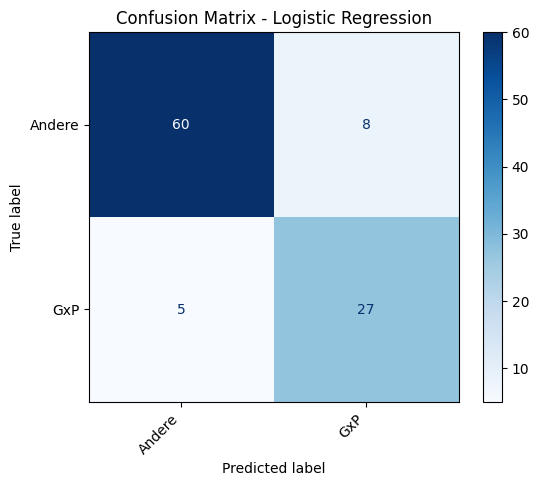

In [257]:
# Visualisierung der Confusion Matrix
disp_lgr = ConfusionMatrixDisplay(confusion_matrix=confm_lgr, display_labels=class_label)
disp_lgr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.xticks(rotation=45, ha="right")
plt.show()

In [258]:
print(classification_report(y_validation, y_pred_lgr, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.92      0.88      0.90        68
         GxP       0.77      0.84      0.81        32

    accuracy                           0.87       100
   macro avg       0.85      0.86      0.85       100
weighted avg       0.87      0.87      0.87       100



In [259]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_lgr = classif_lgr.predict_proba(X_validation_scaled)
loss_lgr = round(log_loss(y_validation, y_prob_lgr), 2)
print(f"Cross-Entropy Loss: {loss_lgr}")

Cross-Entropy Loss: 0.32


In [260]:
# MSE
mse_lgr = round(mean_squared_error(y_validation, y_pred_lgr), 2)
print(f"Mean Squared Error: {mse_lgr}")

Mean Squared Error: 0.13


In [261]:
# Accuracy
accuracy_lgr = round(accuracy_score(y_validation, y_pred_lgr), 4)
print(f"Accuracy: {accuracy_lgr}")

Accuracy: 0.87


In [262]:
# Balanced Accuracy
balanced_accuracy_lgr = round(balanced_accuracy_score(y_validation, y_pred_lgr), 4)
print(f"Balanced accuracy: {balanced_accuracy_lgr}")

Balanced accuracy: 0.8631


In [263]:
# Precision
precision_lgr = round(precision_score(y_validation, y_pred_lgr), 4)
print(f"Precision: {precision_lgr}")

Precision: 0.7714


In [264]:
# Recall
recall_lgr = round(recall_score(y_validation, y_pred_lgr), 4)
print(f"Recall: {recall_lgr}")

Recall: 0.8438


In [265]:
# F1-score
f1_lgr = round(f1_score(y_validation, y_pred_lgr), 4)
print(f"F1-score: {f1_lgr}")

F1-score: 0.806


b. SVM

In [131]:
# Modelldefinition
classif_svm = SVC(max_iter=1000, random_state=42, probability=True)
classif_svm.fit(X_train_scaled, y_train)

# Erstellung von Prognosen
y_pred_svm = classif_svm.predict(X_validation_scaled)

In [132]:
# Berechnung der Confusion Matrix
confm_svm = confusion_matrix(y_validation, y_pred_svm)

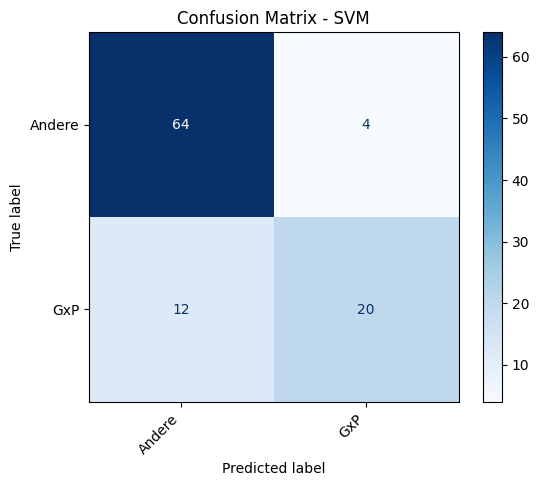

In [133]:
# Visualisierung der Confusion Matrix
disp_svm = ConfusionMatrixDisplay(confusion_matrix=confm_svm, display_labels=class_label)
disp_svm.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
plt.xticks(rotation=45, ha="right")
plt.show()

In [134]:
print(classification_report(y_validation, y_pred_svm, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.84      0.94      0.89        68
         GxP       0.83      0.62      0.71        32

    accuracy                           0.84       100
   macro avg       0.84      0.78      0.80       100
weighted avg       0.84      0.84      0.83       100



In [135]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_svm = classif_svm.predict_proba(X_validation_scaled)
loss_svm = round(log_loss(y_validation, y_prob_svm), 2)
print(f"Cross-Entropy Loss: {loss_svm}")

Cross-Entropy Loss: 0.3


In [136]:
# MSE
mse_svm = round(mean_squared_error(y_validation, y_pred_svm), 2)
print(f"Mean Squared Error: {mse_svm}")

Mean Squared Error: 0.16


In [137]:
# Accuracy
accuracy_svm = round(accuracy_score(y_validation, y_pred_svm), 4)
print(f"Accuracy: {accuracy_svm}")

Accuracy: 0.84


In [138]:
# Balanced Accuracy
balanced_accuracy_svm = round(balanced_accuracy_score(y_validation, y_pred_svm), 4)
print(f"Balanced accuracy: {balanced_accuracy_svm}")

Balanced accuracy: 0.7831


In [139]:
# Precision
precision_svm = round(precision_score(y_validation, y_pred_svm), 4)
print(f"Precision: {precision_svm}")

Precision: 0.8333


In [140]:
# Recall
recall_svm = round(recall_score(y_validation, y_pred_svm), 4)
print(f"Recall: {recall_svm}")

Recall: 0.625


In [141]:
# F1-score
f1_svm = round(f1_score(y_validation, y_pred_svm), 4)
print(f"F1-score: {f1_svm}")

F1-score: 0.7143


c. Random Forests

In [142]:
# Modelldefinition
classif_rf = RandomForestClassifier(n_estimators=100, random_state=42)
classif_rf.fit(X_train_scaled, y_train)

#Erstellung von Prognosen
y_pred_rf = classif_rf.predict(X_validation_scaled)

In [143]:
# Berechnung der Confusion Matrix
confm_rf = confusion_matrix(y_validation, y_pred_rf)

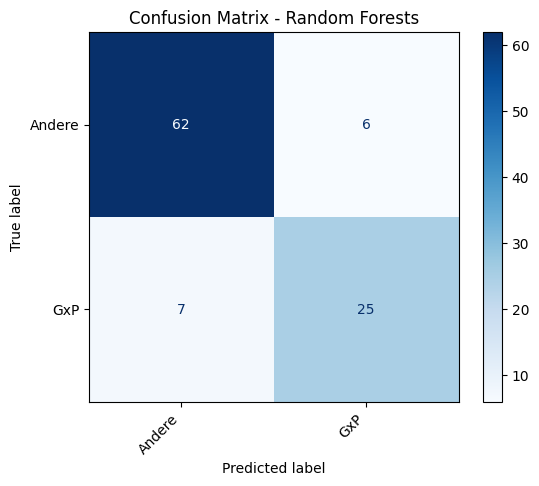

In [144]:
# Visualisierung der Confusion Matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=confm_rf, display_labels=class_label)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forests")
plt.xticks(rotation=45, ha="right")
plt.show()

In [145]:
print(classification_report(y_validation, y_pred_rf, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.90      0.91      0.91        68
         GxP       0.81      0.78      0.79        32

    accuracy                           0.87       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.87      0.87      0.87       100



In [146]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_rf = classif_rf.predict_proba(X_validation_scaled)
loss_rf = round(log_loss(y_validation, y_prob_rf), 2)
print(f"Cross-Entropy Loss: {loss_rf}")

Cross-Entropy Loss: 0.35


In [147]:
# MSE
mse_rf = round(mean_squared_error(y_validation, y_pred_rf), 2)
print(f"Mean Squared Error: {mse_rf}")

Mean Squared Error: 0.13


In [148]:
# Accuracy
accuracy_rf = round(accuracy_score(y_validation, y_pred_rf), 4)
print(f"Accuracy: {accuracy_rf}")

Accuracy: 0.87


In [149]:
# Balanced Accuracy
balanced_accuracy_rf = round(balanced_accuracy_score(y_validation, y_pred_rf), 4)
print(f"Balanced accuracy: {balanced_accuracy_rf}")

Balanced accuracy: 0.8465


In [150]:
# Precision
precision_rf = round(precision_score(y_validation, y_pred_rf), 4)
print(f"Precision: {precision_rf}")

Precision: 0.8065


In [151]:
# Recall
recall_rf = round(recall_score(y_validation, y_pred_rf), 4)
print(f"Recall: {recall_rf}")

Recall: 0.7812


In [152]:
# F1-score
f1_rf = round(f1_score(y_validation, y_pred_rf), 4)
print(f"F1-score: {f1_rf}")

F1-score: 0.7937


d. NN mit L-BFGS

In [303]:
# Modelldefinition
classif_mlp = MLPClassifier(solver='lbfgs', max_iter=1000, hidden_layer_sizes=(32, 16), random_state=42)
classif_mlp.fit(X_train_scaled, y_train)

#Erstellung von Prognosen
y_pred_mlp = classif_mlp.predict(X_validation_scaled)

In [304]:
# Berechnung der Confusion Matrix
confm_mlp = confusion_matrix(y_validation, y_pred_mlp)

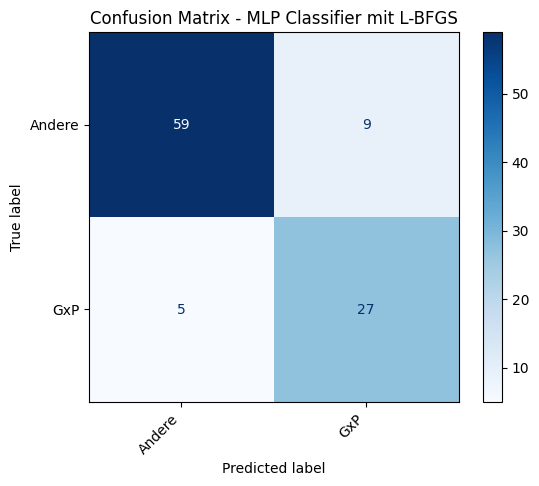

In [305]:
# Visualisierung der Confusion Matrix
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=confm_mlp, display_labels=class_label)
disp_mlp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MLP Classifier mit L-BFGS")
plt.xticks(rotation=45, ha="right")
plt.show()

In [307]:
print(classification_report(y_validation, y_pred_mlp, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.92      0.87      0.89        68
         GxP       0.75      0.84      0.79        32

    accuracy                           0.86       100
   macro avg       0.84      0.86      0.84       100
weighted avg       0.87      0.86      0.86       100



In [308]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_mlp = classif_mlp.predict_proba(X_validation_scaled)
loss_mlp = round(log_loss(y_validation, y_prob_mlp), 2)
print(f"Cross-Entropy Loss: {loss_mlp}")

Cross-Entropy Loss: 0.48


In [309]:
# MSE
mse_mlp = round(mean_squared_error(y_validation, y_pred_mlp), 2)
print(f"Mean Squared Error: {mse_mlp}")

Mean Squared Error: 0.14


In [310]:
# Accuracy
accuracy_mlp = round(accuracy_score(y_validation, y_pred_mlp), 4)
print(f"Accuracy: {accuracy_mlp}")

Accuracy: 0.86


In [311]:
# Balanced Accuracy
balanced_accuracy_mlp = round(balanced_accuracy_score(y_validation, y_pred_mlp), 4)
print(f"Balanced accuracy: {balanced_accuracy_mlp}")

Balanced accuracy: 0.8557


In [312]:
# Precision
precision_mlp = round(precision_score(y_validation, y_pred_mlp), 4)
print(f"Precision: {precision_mlp}")

Precision: 0.75


In [313]:
# Recall
recall_mlp = round(recall_score(y_validation, y_pred_mlp), 4)
print(f"Recall: {recall_mlp}")

Recall: 0.8438


In [314]:
# F1-score
f1_mlp = round(f1_score(y_validation, y_pred_mlp), 4)
print(f"F1-score: {f1_mlp}")

F1-score: 0.7941


e. NN Keras/Adam

In [164]:
# Model definition
classif_keradam = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Modell kompilieren
classif_keradam.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

classif_keradam.fit(X_train_scaled, y_train,
        epochs=50, batch_size=32,
        validation_data=(X_validation_scaled, y_validation),
        verbose=1)

#Erstellung von Prognosen
y_pred_keradam = classif_keradam.predict(X_validation_scaled)
y_pred_keradam_labels = (y_pred_keradam > 0.6).astype("int32")

Epoch 1/50
4/4 [==============================] - 3s 134ms/step - loss: 0.5185 - accuracy: 0.7900 - val_loss: 0.5583 - val_accuracy: 0.8200
Epoch 2/50
4/4 [==============================] - 0s 27ms/step - loss: 0.1379 - accuracy: 0.9900 - val_loss: 0.4989 - val_accuracy: 0.8500
Epoch 3/50
4/4 [==============================] - 0s 21ms/step - loss: 0.0496 - accuracy: 1.0000 - val_loss: 0.4806 - val_accuracy: 0.8700
Epoch 4/50
4/4 [==============================] - 0s 25ms/step - loss: 0.0217 - accuracy: 1.0000 - val_loss: 0.4774 - val_accuracy: 0.8700
Epoch 5/50
4/4 [==============================] - 0s 24ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 0.4799 - val_accuracy: 0.8700
Epoch 6/50
4/4 [==============================] - 0s 30ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.4846 - val_accuracy: 0.8700
Epoch 7/50
4/4 [==============================] - 0s 29ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.4894 - val_accuracy: 0.8700
Epoch 8/50
4/4 [==========

In [165]:
# Berechnung der Confusion Matrix
confm_keradam = confusion_matrix(y_validation, y_pred_keradam_labels)

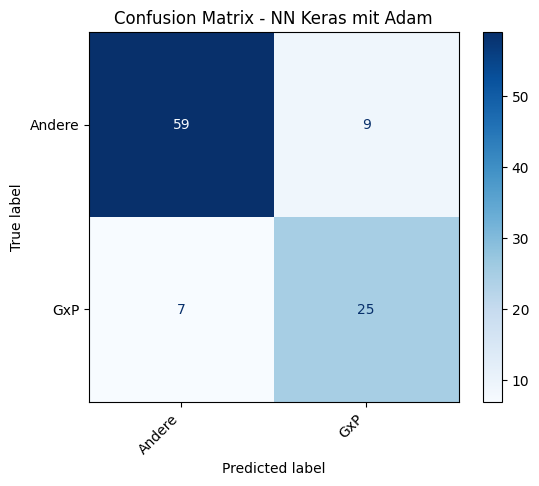

In [166]:
# Visualisierung der Confusion Matrix
disp_keradam = ConfusionMatrixDisplay(confusion_matrix=confm_keradam, display_labels=class_label)
disp_keradam.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - NN Keras mit Adam")
plt.xticks(rotation=45, ha="right")
plt.show()

In [167]:
print(classification_report(y_validation, y_pred_keradam_labels, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.89      0.87      0.88        68
         GxP       0.74      0.78      0.76        32

    accuracy                           0.84       100
   macro avg       0.81      0.82      0.82       100
weighted avg       0.84      0.84      0.84       100



In [168]:
# y_pred_keradam flatten, damit es der Form von y_validation entspricht
y_pred_keradam_flat = y_pred_keradam.flatten()
# Binary Cross-Entropy loss
loss_keradam = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_validation, y_pred_keradam_flat))
# Tensor zum Drucken in numpy konvertieren
loss_keradam = round(np.float64(loss_keradam.numpy()), 2)
print(f"Cross-Entropy Loss: {loss_keradam}")

Cross-Entropy Loss: 0.52


In [169]:
# MSE
mse_keradam = round(mean_squared_error(y_validation, y_pred_keradam_labels), 2)
print(f"Mean Squared Error: {mse_keradam}")

Mean Squared Error: 0.16


In [170]:
# Accuracy
accuracy_keradam = round(accuracy_score(y_validation, y_pred_keradam_labels), 4)
print(f"Accuracy: {accuracy_keradam}")

Accuracy: 0.84


In [171]:
# Balanced Accuracy
balanced_accuracy_keradam = round(balanced_accuracy_score(y_validation, y_pred_keradam_labels), 4)
print(f"Balanced accuracy: {balanced_accuracy_keradam}")

Balanced accuracy: 0.8244


In [172]:
# Precision
precision_keradam = round(precision_score(y_validation, y_pred_keradam_labels), 4)
print(f"Precision: {precision_keradam}")

Precision: 0.7353


In [173]:
# Recall
recall_keradam = round(recall_score(y_validation, y_pred_keradam_labels), 4)
print(f"Recall: {recall_keradam}")

Recall: 0.7812


In [174]:
# F1-score
f1_keradam = round(f1_score(y_validation, y_pred_keradam_labels), 4)
print(f"F1-score: {f1_keradam}")

F1-score: 0.7576


f. XGBoost

In [175]:
# Modelldefinition
classif_xgboost = XGBClassifier(objective='binary:logistic', eval_metric='logloss', learning_rate=0.1, random_state=42)
classif_xgboost.fit(X_train_scaled, y_train)

#Erstellung von Prognosen
y_pred_xgboost = classif_xgboost.predict(X_validation_scaled)

In [176]:
# Berechnung der Confusion Matrix
confm_xgboost = confusion_matrix(y_validation, y_pred_xgboost)

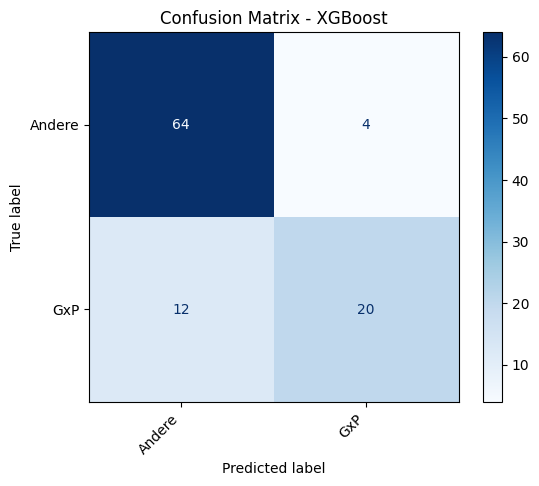

In [177]:
# Visualisierung der Confusion Matrix
disp_xgboost = ConfusionMatrixDisplay(confusion_matrix=confm_xgboost, display_labels=class_label)
disp_xgboost.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.xticks(rotation=45, ha="right")
plt.show()

In [178]:
print(classification_report(y_validation, y_pred_xgboost, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.84      0.94      0.89        68
         GxP       0.83      0.62      0.71        32

    accuracy                           0.84       100
   macro avg       0.84      0.78      0.80       100
weighted avg       0.84      0.84      0.83       100



In [179]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_xgboost = classif_xgboost.predict_proba(X_validation_scaled)
loss_xgboost = round(log_loss(y_validation, y_prob_xgboost), 2)
print(f"Cross-Entropy Loss: {loss_xgboost}")

Cross-Entropy Loss: 0.64


In [180]:
# MSE
mse_xgboost = round(mean_squared_error(y_validation, y_pred_xgboost), 2)
print(f"Mean Squared Error: {mse_xgboost}")

Mean Squared Error: 0.16


In [181]:
# Accuracy
accuracy_xgboost = round(accuracy_score(y_validation, y_pred_xgboost), 4)
print(f"Accuracy: {accuracy_xgboost}")

Accuracy: 0.84


In [182]:
# Balanced Accuracy
balanced_accuracy_xgboost = round(balanced_accuracy_score(y_validation, y_pred_xgboost), 4)
print(f"Balanced accuracy: {balanced_accuracy_xgboost}")

Balanced accuracy: 0.7831


In [183]:
# Precision
precision_xgboost = round(precision_score(y_validation, y_pred_xgboost), 4)
print(f"Precision: {precision_xgboost}")

Precision: 0.8333


In [184]:
# Recall
recall_xgboost = round(recall_score(y_validation, y_pred_xgboost), 4)
print(f"Recall: {recall_xgboost}")

Recall: 0.625


In [185]:
# F1-score
f1_xgboost = round(f1_score(y_validation, y_pred_xgboost), 4)
print(f"F1-score: {f1_xgboost}")

F1-score: 0.7143


g. CatBoost

In [186]:
# Modelldefinition
classif_cat = CatBoostClassifier(verbose=0, learning_rate=0.1, random_state=42)
classif_cat.fit(X_train_scaled, y_train)

#Erstellung von Prognosen
y_pred_cat = classif_cat.predict(X_validation_scaled)

In [187]:
# Berechnung der Confusion Matrix
confm_cat = confusion_matrix(y_validation, y_pred_cat)

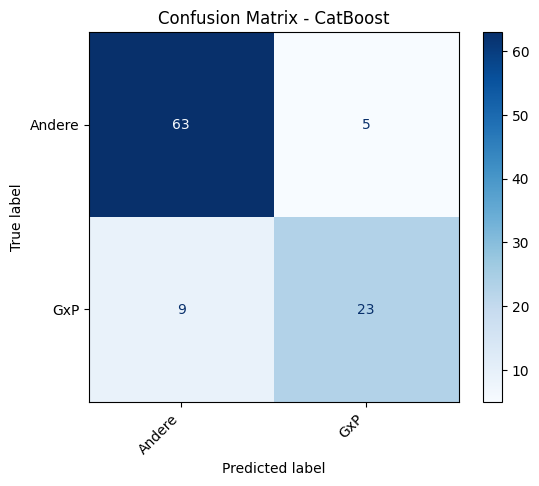

In [188]:
# Visualisierung der Confusion Matrix
disp_cat = ConfusionMatrixDisplay(confusion_matrix=confm_cat, display_labels=class_label)
disp_cat.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CatBoost")
plt.xticks(rotation=45, ha="right")
plt.show()

In [189]:
print(classification_report(y_validation, y_pred_cat, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.88      0.93      0.90        68
         GxP       0.82      0.72      0.77        32

    accuracy                           0.86       100
   macro avg       0.85      0.82      0.83       100
weighted avg       0.86      0.86      0.86       100



In [190]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_cat = classif_cat.predict_proba(X_validation_scaled)
loss_cat = round(log_loss(y_validation, y_prob_cat), 2)
print(f"Cross-Entropy Loss: {loss_cat}")

Cross-Entropy Loss: 0.44


In [191]:
# MSE
mse_cat = round(mean_squared_error(y_validation, y_pred_cat), 2)
print(f"Mean Squared Error: {mse_cat}")

Mean Squared Error: 0.14


In [192]:
# Accuracy
accuracy_cat = round(accuracy_score(y_validation, y_pred_cat), 4)
print(f"Accuracy: {accuracy_cat}")

Accuracy: 0.86


In [193]:
# Balanced Accuracy
balanced_accuracy_cat = round(balanced_accuracy_score(y_validation, y_pred_cat), 4)
print(f"Balanced accuracy: {balanced_accuracy_cat}")

Balanced accuracy: 0.8226


In [194]:
# Precision
precision_cat = round(precision_score(y_validation, y_pred_cat), 4)
print(f"Precision: {precision_cat}")

Precision: 0.8214


In [195]:
# Recall
recall_cat = round(recall_score(y_validation, y_pred_cat), 4)
print(f"Recall: {recall_cat}")

Recall: 0.7188


In [196]:
# F1-score
f1_cat = round(f1_score(y_validation, y_pred_cat), 4)
print(f"F1-score: {f1_cat}")

F1-score: 0.7667


h. Bootstrap (Bagging)

In [197]:
# Modelldefinition
classif_bag = BaggingClassifier(n_estimators=100, max_samples=0.8, bootstrap=True, random_state=42)
classif_bag.fit(X_train_scaled, y_train)

#Erstellung von Prognosen
y_pred_bag = classif_bag.predict(X_validation_scaled)

In [198]:
# Berechnung der Confusion Matrix
confm_bag = confusion_matrix(y_validation, y_pred_bag)

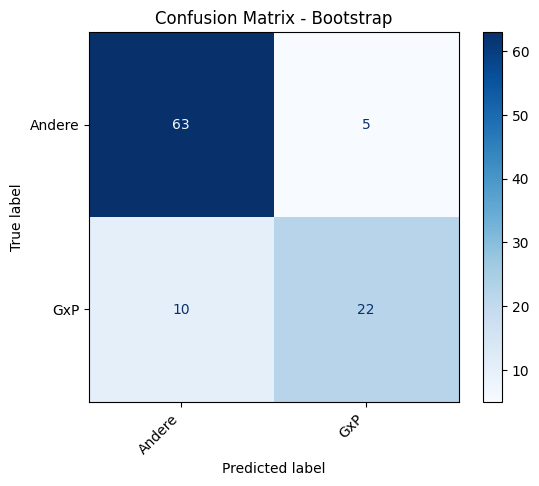

In [199]:
# Visualisierung der Confusion Matrix
disp_bag = ConfusionMatrixDisplay(confusion_matrix=confm_bag, display_labels=class_label)
disp_bag.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Bootstrap")
plt.xticks(rotation=45, ha="right")
plt.show()

In [200]:
print(classification_report(y_validation, y_pred_bag, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.86      0.93      0.89        68
         GxP       0.81      0.69      0.75        32

    accuracy                           0.85       100
   macro avg       0.84      0.81      0.82       100
weighted avg       0.85      0.85      0.85       100



In [201]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_bag = classif_bag.predict_proba(X_validation_scaled)
loss_bag = round(log_loss(y_validation, y_prob_bag), 2)
print(f"Cross-Entropy Loss: {loss_bag}")

Cross-Entropy Loss: 0.35


In [202]:
# MSE
mse_bag = round(mean_squared_error(y_validation, y_pred_bag), 2)
print(f"Mean Squared Error: {mse_bag}")

Mean Squared Error: 0.15


In [203]:
# Accuracy
accuracy_bag = round(accuracy_score(y_validation, y_pred_bag), 4)
print(f"Accuracy: {accuracy_bag}")

Accuracy: 0.85


In [204]:
# Balanced Accuracy
balanced_accuracy_bag = round(balanced_accuracy_score(y_validation, y_pred_bag), 4)
print(f"Balanced accuracy: {balanced_accuracy_bag}")

Balanced accuracy: 0.807


In [205]:
# Precision
precision_bag = round(precision_score(y_validation, y_pred_bag), 4)
print(f"Precision: {precision_bag}")

Precision: 0.8148


In [206]:
# Recall
recall_bag = round(recall_score(y_validation, y_pred_bag), 4)
print(f"Recall: {recall_bag}")

Recall: 0.6875


In [207]:
# F1-score
f1_bag = round(f1_score(y_validation, y_pred_bag), 4)
print(f"F1-score: {f1_bag}")

F1-score: 0.7458


Zusammenfassende Ergebnistabelle

In [266]:
methods = ['Logistic Regression', 'SVM', 'Random Forest', 'NN mit L-BFGS', 'NN Keras/Adam', 'XGBoost', 'CatBoost', 'Bootstrap (Bagging)']
metrics = ['Cross-Entropy Loss', 'MSE', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-Score']

data = {
    metrics[0]: [loss_lgr, loss_svm, loss_rf, loss_mlp, loss_keradam, loss_xgboost, loss_cat, loss_bag],
    metrics[1]: [mse_lgr, mse_svm, mse_rf, mse_mlp, mse_keradam, mse_xgboost, mse_cat, mse_bag],
    metrics[2]: [accuracy_lgr, accuracy_svm, accuracy_rf, accuracy_mlp, accuracy_keradam, accuracy_xgboost, accuracy_cat, accuracy_bag],
    metrics[3]: [balanced_accuracy_lgr, balanced_accuracy_svm, balanced_accuracy_rf, balanced_accuracy_mlp, balanced_accuracy_keradam, 
                 balanced_accuracy_xgboost, balanced_accuracy_cat, balanced_accuracy_bag],
    metrics[4]: [precision_lgr, precision_svm, precision_rf, precision_mlp, precision_keradam, precision_xgboost, precision_cat, precision_bag],
    metrics[5]: [recall_lgr, recall_svm, recall_rf, recall_mlp, recall_keradam, recall_xgboost, recall_cat, recall_bag],
    metrics[6]: [f1_lgr, f1_svm, f1_rf, f1_mlp, f1_keradam, f1_xgboost, f1_cat, f1_bag]
}

table = pd.DataFrame(data, index=methods)
table['Cross-Entropy Loss'] = pd.to_numeric(table['Cross-Entropy Loss'], errors='coerce')

# Find max values 
max_balanced_accuracy = table['Balanced Accuracy'].max()
max_F1_score = table['F1-Score'].max()

# Function to highlight min/max values
def highlight_max(val):
    if pd.isna(val) or val == '-':
        return ''
   
    if val == max_balanced_accuracy:
        return 'background-color: yellow'
        
    if val == max_F1_score:
        return 'background-color: yellow' 
    return ''

# Set the number of digits after the point
format_round = {
    'Cross-Entropy Loss': '{:.2f}',
    'MSE': '{:.2f}',
    'Accuracy': '{:.4f}',
    'Balanced Accuracy': '{:.4f}',
    'Precision': '{:.4f}',
    'Recall': '{:.4f}',
    'F1 Score': '{:.4f}'
}

# Apply the highlighting to selected columns
styled_table = table.style.format(format_round).map(highlight_max, subset=['Balanced Accuracy', 'F1-Score'])
styled_table

,Cross-Entropy Loss,MSE,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.32,0.13,0.8700,0.8631,0.7714,0.8438,0.806000
SVM,0.30,0.16,0.8400,0.7831,0.8333,0.6250,0.714300
Random Forest,0.35,0.13,0.8700,0.8465,0.8065,0.7812,0.793700
NN mit L-BFGS,0.48,0.14,0.8600,0.8557,0.7500,0.8438,0.794100
NN Keras/Adam,0.52,0.16,0.8400,0.8244,0.7353,0.7812,0.757600
XGBoost,0.64,0.16,0.8400,0.7831,0.8333,0.6250,0.714300
CatBoost,0.44,0.14,0.8600,0.8226,0.8214,0.7188,0.766700
Bootstrap (Bagging),0.35,0.15,0.8500,0.8070,0.8148,0.6875,0.745800


#### Schritt 7. Feature importances

Bewertung von Features für das beste Modell mithilfe von Feature-Importances

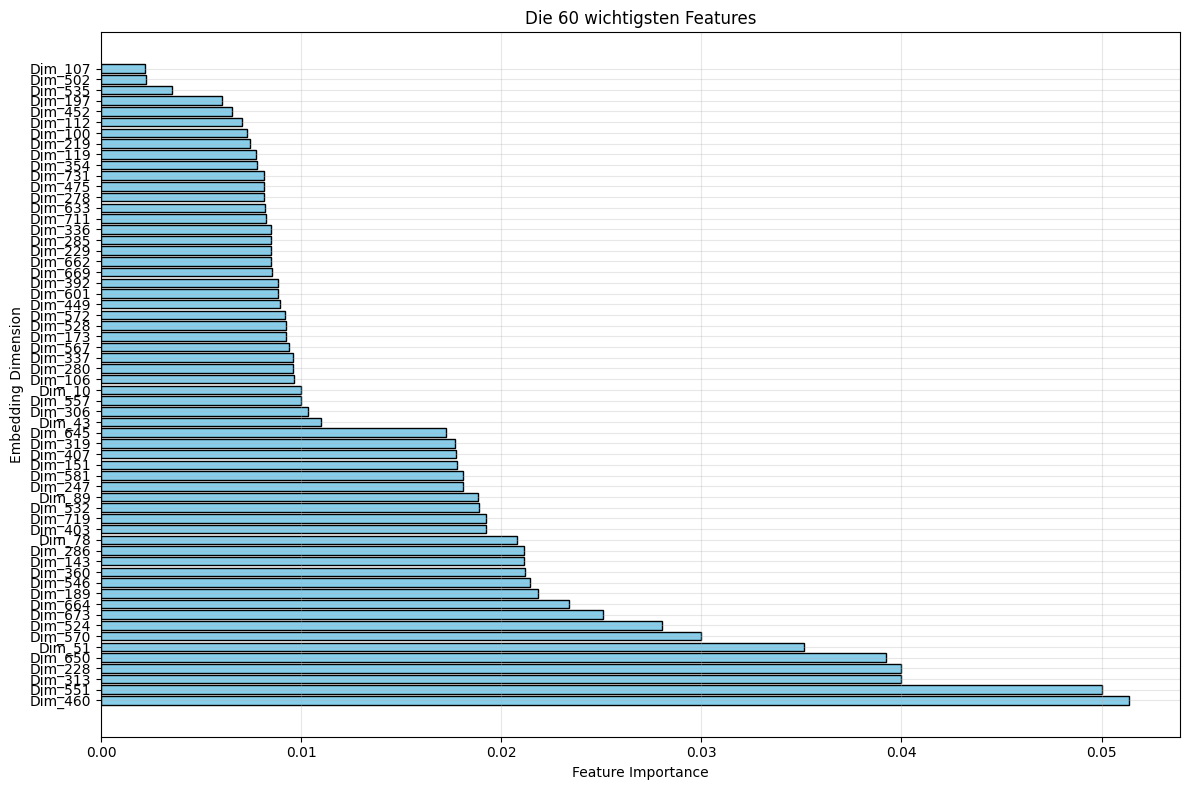

In [213]:
importances = classif_rf.feature_importances_
top_features_60 = np.argsort(importances)[-60:]
top_features = importances[top_features_60]

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features_60)), top_features[::-1], color='skyblue', edgecolor='black')
plt.xlabel('Feature Importance')
plt.ylabel('Embedding Dimension')
plt.title('Die 60 wichtigsten Features')
plt.yticks(range(len(top_features_60)), [f'Dim_{idx}' for idx in top_features_60[::-1]])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Auswahl der wichtigsten Features zur weiteren Reduzierung des Datensatzes

In [216]:
top_dims = np.argsort(importances >= 0.02)

In [217]:
X_train_reduced = X_train[:, top_dims]
X_validation_reduced = X_validation[:, top_dims]
X_test_reduced = X_test[:, top_dims]

#### Schritt 8: Wiederholung von Schritt 6. Classification und Analyse der Ergebnisse – zum Vergleich mit früheren Ergebnissen

In [218]:
# Daten normalisieren
scaler2 = StandardScaler()
X_train_scaled2 = scaler2.fit_transform(X_train_reduced)
X_validation_scaled2 = scaler2.transform(X_validation_reduced)
X_test_scaled2 = scaler2.transform(X_test_reduced)

a. Logistic Regression

In [267]:
# Modelldefinition
classif_lgr2 = LogisticRegression(max_iter=1000, C=0.1, random_state=42)
classif_lgr2.fit(X_train_scaled2, y_train)

#Erstellung von Prognosen
y_pred_lgr2 = classif_lgr2.predict(X_validation_scaled2)

In [268]:
# Berechnung der Confusion Matrix
confm_lgr2 = confusion_matrix(y_validation, y_pred_lgr2)

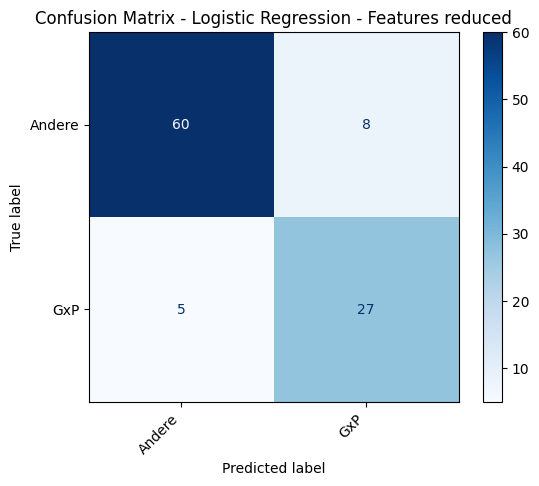

In [269]:
# Visualisierung der Confusion Matrix
disp_lgr2 = ConfusionMatrixDisplay(confusion_matrix=confm_lgr2, display_labels=class_label)
disp_lgr2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression - Features reduced")
plt.xticks(rotation=45, ha="right")
plt.show()

In [270]:
print(classification_report(y_validation, y_pred_lgr2, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.92      0.88      0.90        68
         GxP       0.77      0.84      0.81        32

    accuracy                           0.87       100
   macro avg       0.85      0.86      0.85       100
weighted avg       0.87      0.87      0.87       100



In [271]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_lgr2 = classif_lgr2.predict_proba(X_validation_scaled2)
loss_lgr2 = round(log_loss(y_validation, y_prob_lgr2), 2)
print(f"Cross-Entropy Loss: {loss_lgr2}")

Cross-Entropy Loss: 0.32


In [272]:
# MSE
mse_lgr2 = round(mean_squared_error(y_validation, y_pred_lgr2), 2)
print(f"Mean Squared Error: {mse_lgr2}")

Mean Squared Error: 0.13


In [273]:
# Accuracy
accuracy_lgr2 = round(accuracy_score(y_validation, y_pred_lgr2), 4)
print(f"Accuracy: {accuracy_lgr2}")

Accuracy: 0.87


In [274]:
# Balanced Accuracy
balanced_accuracy_lgr2 = round(balanced_accuracy_score(y_validation, y_pred_lgr2), 4)
print(f"Balanced accuracy: {balanced_accuracy_lgr2}")

Balanced accuracy: 0.8631


In [275]:
# Precision
precision_lgr2 = round(precision_score(y_validation, y_pred_lgr2), 4)
print(f"Precision: {precision_lgr2}")

Precision: 0.7714


In [276]:
# Recall
recall_lgr2 = round(recall_score(y_validation, y_pred_lgr2), 4)
print(f"Recall: {recall_lgr2}")

Recall: 0.8438


In [277]:
# F1-score
f1_lgr2 = round(f1_score(y_validation, y_pred_lgr2), 4)
print(f"F1-score: {f1_lgr2}")

F1-score: 0.806


b. SVM

In [278]:
# Modelldefinition
classif_svm2 = SVC(max_iter=1000, random_state=42, probability=True)
classif_svm2.fit(X_train_scaled2, y_train)

# Erstellung von Prognosen
y_pred_svm2 = classif_svm2.predict(X_validation_scaled2)

In [279]:
# Berechnung der Confusion Matrix
confm_svm2 = confusion_matrix(y_validation, y_pred_svm2)

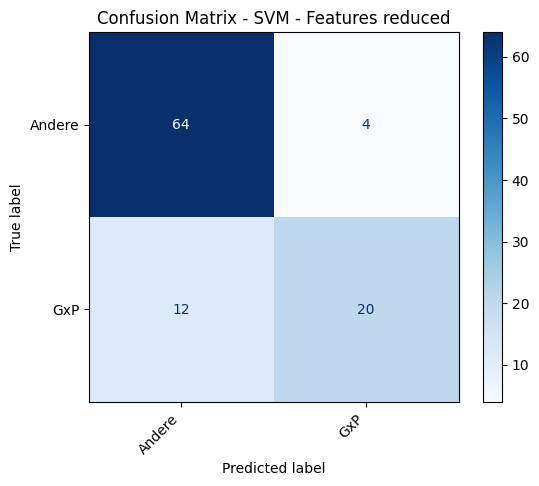

In [280]:
# Visualisierung der Confusion Matrix
disp_svm2 = ConfusionMatrixDisplay(confusion_matrix=confm_svm2, display_labels=class_label)
disp_svm2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM - Features reduced")
plt.xticks(rotation=45, ha="right")
plt.show()

In [281]:
print(classification_report(y_validation, y_pred_svm2, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.84      0.94      0.89        68
         GxP       0.83      0.62      0.71        32

    accuracy                           0.84       100
   macro avg       0.84      0.78      0.80       100
weighted avg       0.84      0.84      0.83       100



In [282]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_svm2 = classif_svm2.predict_proba(X_validation_scaled2)
loss_svm2 = round(log_loss(y_validation, y_prob_svm2), 2)
print(f"Cross-Entropy Loss: {loss_svm2}")

Cross-Entropy Loss: 0.3


In [283]:
# MSE
mse_svm2 = round(mean_squared_error(y_validation, y_pred_svm2), 2)
print(f"Mean Squared Error: {mse_svm2}")

Mean Squared Error: 0.16


In [284]:
# Accuracy
accuracy_svm2 = round(accuracy_score(y_validation, y_pred_svm2), 4)
print(f"Accuracy: {accuracy_svm2}")

Accuracy: 0.84


In [285]:
# Balanced Accuracy
balanced_accuracy_svm2 = round(balanced_accuracy_score(y_validation, y_pred_svm2), 4)
print(f"Balanced accuracy: {balanced_accuracy_svm2}")

Balanced accuracy: 0.7831


In [286]:
# Precision
precision_svm2 = round(precision_score(y_validation, y_pred_svm2), 4)
print(f"Precision: {precision_svm2}")

Precision: 0.8333


In [287]:
# Recall
recall_svm2 = round(recall_score(y_validation, y_pred_svm2), 4)
print(f"Recall: {recall_svm2}")

Recall: 0.625


In [288]:
# F1-score
f1_svm2 = round(f1_score(y_validation, y_pred_svm2), 4)
print(f"F1-score: {f1_svm2}")

F1-score: 0.7143


c. Random Forests

In [289]:
# Modelldefinition
classif_rf2 = RandomForestClassifier(n_estimators=100, random_state=42)
classif_rf2.fit(X_train_scaled2, y_train)

#Erstellung von Prognosen
y_pred_rf2 = classif_rf2.predict(X_validation_scaled2)

In [290]:
# Berechnung der Confusion Matrix
confm_rf2 = confusion_matrix(y_validation, y_pred_rf2)

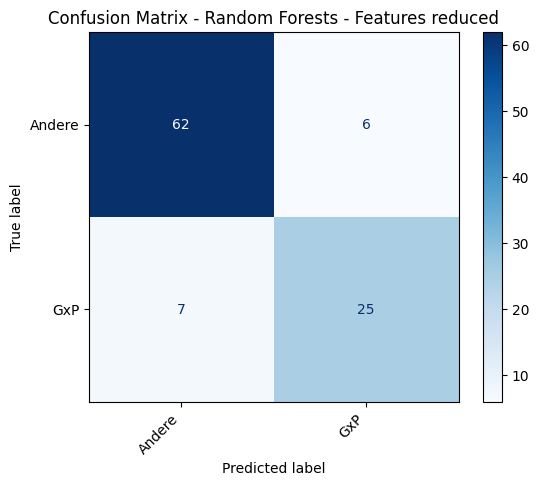

In [291]:
# Visualisierung der Confusion Matrix
disp_rf2 = ConfusionMatrixDisplay(confusion_matrix=confm_rf2, display_labels=class_label)
disp_rf2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forests - Features reduced")
plt.xticks(rotation=45, ha="right")
plt.show()

In [292]:
print(classification_report(y_validation, y_pred_rf2, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.90      0.91      0.91        68
         GxP       0.81      0.78      0.79        32

    accuracy                           0.87       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.87      0.87      0.87       100



In [293]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_rf2 = classif_rf2.predict_proba(X_validation_scaled2)
loss_rf2 = round(log_loss(y_validation, y_prob_rf2), 2)
print(f"Cross-Entropy Loss: {loss_rf2}")

Cross-Entropy Loss: 0.33


In [294]:
# MSE
mse_rf2 = round(mean_squared_error(y_validation, y_pred_rf2), 2)
print(f"Mean Squared Error: {mse_rf2}")

Mean Squared Error: 0.13


In [295]:
# Accuracy
accuracy_rf2 = round(accuracy_score(y_validation, y_pred_rf2), 4)
print(f"Accuracy: {accuracy_rf2}")

Accuracy: 0.87


In [296]:
# Balanced Accuracy
balanced_accuracy_rf2 = round(balanced_accuracy_score(y_validation, y_pred_rf2), 4)
print(f"Balanced accuracy: {balanced_accuracy_rf2}")

Balanced accuracy: 0.8465


In [297]:
# Precision
precision_rf2 = round(precision_score(y_validation, y_pred_rf2), 4)
print(f"Precision: {precision_rf2}")

Precision: 0.8065


In [298]:
# Recall
recall_rf2 = round(recall_score(y_validation, y_pred_rf2), 4)
print(f"Recall: {recall_rf2}")

Recall: 0.7812


In [299]:
# F1-score
f1_rf2 = round(f1_score(y_validation, y_pred_rf2), 4)
print(f"F1-score: {f1_rf2}")

F1-score: 0.7937


d. NN mit L-BFGS

In [315]:
# Modelldefinition
classif_mlp2 = MLPClassifier(solver='lbfgs', max_iter=100, hidden_layer_sizes=(32, 16), random_state=42)
classif_mlp2.fit(X_train_scaled2, y_train)

#Erstellung von Prognosen
y_pred_mlp2 = classif_mlp2.predict(X_validation_scaled2)

In [316]:
# Berechnung der Confusion Matrix
confm_mlp2 = confusion_matrix(y_validation, y_pred_mlp2)

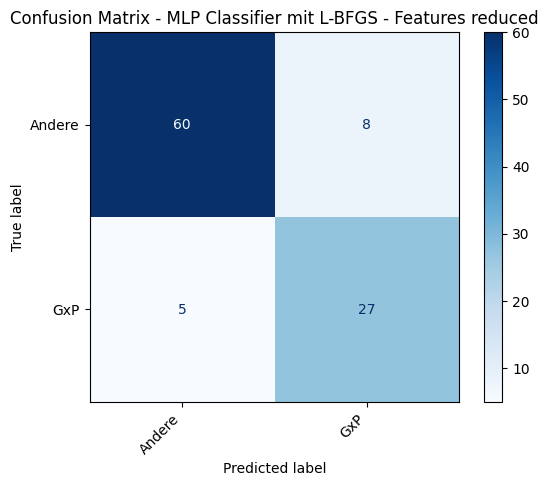

In [317]:
# Visualisierung der Confusion Matrix
disp_mlp2 = ConfusionMatrixDisplay(confusion_matrix=confm_mlp2, display_labels=class_label)
disp_mlp2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MLP Classifier mit L-BFGS - Features reduced")
plt.xticks(rotation=45, ha="right")
plt.show()

In [318]:
print(classification_report(y_validation, y_pred_mlp2, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.92      0.88      0.90        68
         GxP       0.77      0.84      0.81        32

    accuracy                           0.87       100
   macro avg       0.85      0.86      0.85       100
weighted avg       0.87      0.87      0.87       100



In [319]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_mlp2 = classif_mlp2.predict_proba(X_validation_scaled2)
loss_mlp2 = round(log_loss(y_validation, y_prob_mlp2), 2)
print(f"Cross-Entropy Loss: {loss_mlp2}")

Cross-Entropy Loss: 0.6


In [320]:
# MSE
mse_mlp2 = round(mean_squared_error(y_validation, y_pred_mlp2), 2)
print(f"Mean Squared Error: {mse_mlp2}")

Mean Squared Error: 0.13


In [321]:
# Accuracy
accuracy_mlp2 = round(accuracy_score(y_validation, y_pred_mlp2), 4)
print(f"Accuracy: {accuracy_mlp2}")

Accuracy: 0.87


In [322]:
# Balanced Accuracy
balanced_accuracy_mlp2 = round(balanced_accuracy_score(y_validation, y_pred_mlp2), 4)
print(f"Balanced accuracy: {balanced_accuracy_mlp2}")

Balanced accuracy: 0.8631


In [323]:
# Precision
precision_mlp2 = round(precision_score(y_validation, y_pred_mlp2), 4)
print(f"Precision: {precision_mlp2}")

Precision: 0.7714


In [324]:
# Recall
recall_mlp2 = round(recall_score(y_validation, y_pred_mlp2), 4)
print(f"Recall: {recall_mlp2}")

Recall: 0.8438


In [325]:
# F1-score
f1_mlp2 = round(f1_score(y_validation, y_pred_mlp2), 4)
print(f"F1-score: {f1_mlp2}")

F1-score: 0.806


e. NN Keras/Adam

In [326]:
# Model definition
classif_keradam2 = Sequential([
    Input(shape=(X_train_scaled2.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Modell kompilieren
classif_keradam2.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

classif_keradam2.fit(X_train_scaled2, y_train,
        epochs=50, batch_size=32,
        validation_data=(X_validation_scaled2, y_validation),
        verbose=1)

#Erstellung von Prognosen
y_pred_keradam2 = classif_keradam2.predict(X_validation_scaled2)
y_pred_keradam_labels2 = (y_pred_keradam2 > 0.6).astype("int32")

Epoch 1/50
4/4 [==============================] - 2s 132ms/step - loss: 0.6198 - accuracy: 0.6900 - val_loss: 0.4959 - val_accuracy: 0.8600
Epoch 2/50
4/4 [==============================] - 0s 45ms/step - loss: 0.2243 - accuracy: 0.9900 - val_loss: 0.4167 - val_accuracy: 0.8800
Epoch 3/50
4/4 [==============================] - 0s 34ms/step - loss: 0.0903 - accuracy: 1.0000 - val_loss: 0.3628 - val_accuracy: 0.8800
Epoch 4/50
4/4 [==============================] - 0s 31ms/step - loss: 0.0345 - accuracy: 1.0000 - val_loss: 0.3246 - val_accuracy: 0.8800
Epoch 5/50
4/4 [==============================] - 0s 38ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 0.3080 - val_accuracy: 0.8800
Epoch 6/50
4/4 [==============================] - 0s 35ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.3046 - val_accuracy: 0.8800
Epoch 7/50
4/4 [==============================] - 0s 33ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.3067 - val_accuracy: 0.8700
Epoch 8/50
4/4 [==========

In [327]:
# Berechnung der Confusion Matrix
confm_keradam2 = confusion_matrix(y_validation, y_pred_keradam_labels2)

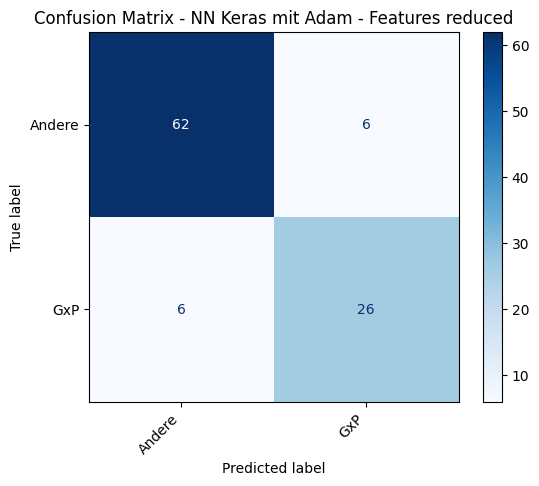

In [328]:
# Visualisierung der Confusion Matrix
disp_keradam2 = ConfusionMatrixDisplay(confusion_matrix=confm_keradam2, display_labels=class_label)
disp_keradam2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - NN Keras mit Adam - Features reduced")
plt.xticks(rotation=45, ha="right")
plt.show()

In [329]:
print(classification_report(y_validation, y_pred_keradam_labels2, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.91      0.91      0.91        68
         GxP       0.81      0.81      0.81        32

    accuracy                           0.88       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.88      0.88      0.88       100



In [330]:
# y_pred_keradam flatten, damit es der Form von y_validation entspricht
y_pred_keradam_flat2 = y_pred_keradam2.flatten()
# Binary Cross-Entropy loss
loss_keradam2 = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_validation, y_pred_keradam_flat2))
# Tensor zum Drucken in numpy konvertieren
loss_keradam2 = round(np.float64(loss_keradam2.numpy()), 2)
print(f"Cross-Entropy Loss: {loss_keradam2}")

Cross-Entropy Loss: 0.35


In [331]:
# MSE
mse_keradam2 = round(mean_squared_error(y_validation, y_pred_keradam_labels2), 2)
print(f"Mean Squared Error: {mse_keradam2}")

Mean Squared Error: 0.12


In [332]:
# Accuracy
accuracy_keradam2 = round(accuracy_score(y_validation, y_pred_keradam_labels2), 4)
print(f"Accuracy: {accuracy_keradam2}")

Accuracy: 0.88


In [333]:
# Balanced Accuracy
balanced_accuracy_keradam2 = round(balanced_accuracy_score(y_validation, y_pred_keradam_labels2), 4)
print(f"Balanced accuracy: {balanced_accuracy_keradam2}")

Balanced accuracy: 0.8621


In [334]:
# Precision
precision_keradam2 = round(precision_score(y_validation, y_pred_keradam_labels2), 4)
print(f"Precision: {precision_keradam2}")

Precision: 0.8125


In [335]:
# Recall
recall_keradam2 = round(recall_score(y_validation, y_pred_keradam_labels2), 4)
print(f"Recall: {recall_keradam2}")

Recall: 0.8125


In [336]:
# F1-score
f1_keradam2 = round(f1_score(y_validation, y_pred_keradam_labels2), 4)
print(f"F1-score: {f1_keradam2}")

F1-score: 0.8125


f. XGBoost

In [337]:
# Modelldefinition
classif_xgboost2 = XGBClassifier(objective='binary:logistic', eval_metric='logloss', learning_rate=0.1, random_state=42)
classif_xgboost2.fit(X_train_scaled2, y_train)

#Erstellung von Prognosen
y_pred_xgboost2 = classif_xgboost2.predict(X_validation_scaled2)

In [338]:
# Berechnung der Confusion Matrix
confm_xgboost2 = confusion_matrix(y_validation, y_pred_xgboost2)

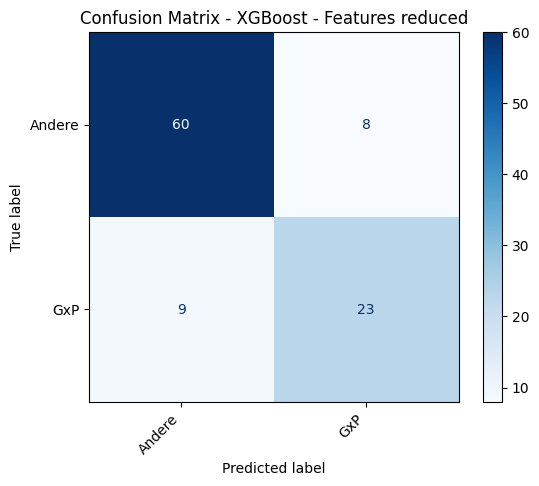

In [339]:
# Visualisierung der CConfusion Matrix
disp_xgboost2 = ConfusionMatrixDisplay(confusion_matrix=confm_xgboost2, display_labels=class_label)
disp_xgboost2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost - Features reduced")
plt.xticks(rotation=45, ha="right")
plt.show()

In [340]:
print(classification_report(y_validation, y_pred_xgboost2, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.87      0.88      0.88        68
         GxP       0.74      0.72      0.73        32

    accuracy                           0.83       100
   macro avg       0.81      0.80      0.80       100
weighted avg       0.83      0.83      0.83       100



In [341]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_xgboost2 = classif_xgboost2.predict_proba(X_validation_scaled2)
loss_xgboost2 = round(log_loss(y_validation, y_prob_xgboost2), 2)
print(f"Cross-Entropy Loss: {loss_xgboost2}")

Cross-Entropy Loss: 0.68


In [342]:
# MSE
mse_xgboost2 = round(mean_squared_error(y_validation, y_pred_xgboost2), 2)
print(f"Mean Squared Error: {mse_xgboost2}")

Mean Squared Error: 0.17


In [343]:
# Accuracy
accuracy_xgboost2 = round(accuracy_score(y_validation, y_pred_xgboost2), 4)
print(f"Accuracy: {accuracy_xgboost2}")

Accuracy: 0.83


In [344]:
# Balanced Accuracy
balanced_accuracy_xgboost2 = round(balanced_accuracy_score(y_validation, y_pred_xgboost2), 4)
print(f"Balanced accuracy: {balanced_accuracy_xgboost2}")

Balanced accuracy: 0.8006


In [345]:
# Precision
precision_xgboost2 = round(precision_score(y_validation, y_pred_xgboost2), 4)
print(f"Precision: {precision_xgboost2}")

Precision: 0.7419


In [346]:
# Recall
recall_xgboost2 = round(recall_score(y_validation, y_pred_xgboost2), 4)
print(f"Recall: {recall_xgboost2}")

Recall: 0.7188


In [347]:
# F1-score
f1_xgboost2 = round(f1_score(y_validation, y_pred_xgboost2), 4)
print(f"F1-score: {f1_xgboost2}")

F1-score: 0.7302


g. CatBoost

In [348]:
# Modelldefinition
classif_cat2 = CatBoostClassifier(verbose=0, learning_rate=0.1, random_state=42)
classif_cat2.fit(X_train_scaled2, y_train)

#Erstellung von Prognosen
y_pred_cat2 = classif_cat2.predict(X_validation_scaled2)

In [349]:
# Berechnung der Confusion Matrix
confm_cat2 = confusion_matrix(y_validation, y_pred_cat2)

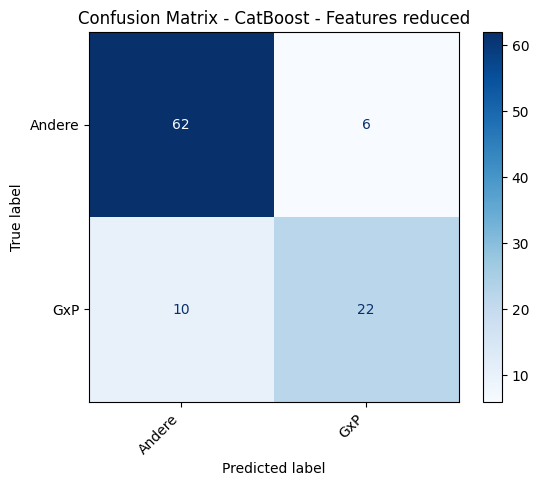

In [350]:
# Visualisierung der Confusion Matrix
disp_cat2 = ConfusionMatrixDisplay(confusion_matrix=confm_cat2, display_labels=class_label)
disp_cat2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CatBoost - Features reduced")
plt.xticks(rotation=45, ha="right")
plt.show()

In [351]:
print(classification_report(y_validation, y_pred_cat2, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.86      0.91      0.89        68
         GxP       0.79      0.69      0.73        32

    accuracy                           0.84       100
   macro avg       0.82      0.80      0.81       100
weighted avg       0.84      0.84      0.84       100



In [352]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_cat2 = classif_cat2.predict_proba(X_validation_scaled2)
loss_cat2 = round(log_loss(y_validation, y_prob_cat2), 2)
print(f"Cross-Entropy Loss: {loss_cat2}")

Cross-Entropy Loss: 0.47


In [353]:
# MSE
mse_cat2 = round(mean_squared_error(y_validation, y_pred_cat2), 2)
print(f"Mean Squared Error: {mse_cat2}")

Mean Squared Error: 0.16


In [354]:
# Accuracy
accuracy_cat2 = round(accuracy_score(y_validation, y_pred_cat2), 4)
print(f"Accuracy: {accuracy_cat2}")

Accuracy: 0.84


In [355]:
# Balanced Accuracy
balanced_accuracy_cat2 = round(balanced_accuracy_score(y_validation, y_pred_cat2), 4)
print(f"Balanced accuracy: {balanced_accuracy_cat2}")

Balanced accuracy: 0.7996


In [356]:
# Precision
precision_cat2 = round(precision_score(y_validation, y_pred_cat2), 4)
print(f"Precision: {precision_cat2}")

Precision: 0.7857


In [357]:
# Recall
recall_cat2 = round(recall_score(y_validation, y_pred_cat2), 4)
print(f"Recall: {recall_cat2}")

Recall: 0.6875


In [358]:
# F1-score
f1_cat2 = round(f1_score(y_validation, y_pred_cat2), 4)
print(f"F1-score: {f1_cat2}")

F1-score: 0.7333


h. Bootstrap (Bagging)

In [359]:
# Modelldefinition
classif_bag2 = BaggingClassifier(n_estimators=100, max_samples=0.8, bootstrap=True, random_state=42)
classif_bag2.fit(X_train_scaled2, y_train)

#Erstellung von Prognosen
y_pred_bag2 = classif_bag2.predict(X_validation_scaled2)

In [360]:
# Berechnung der Confusion Matrix
confm_bag2 = confusion_matrix(y_validation, y_pred_bag2)

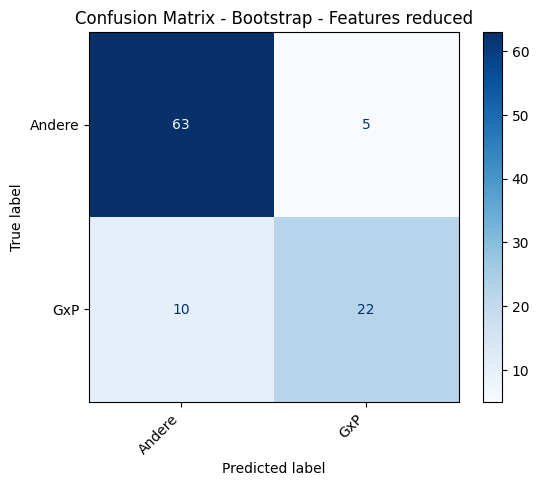

In [361]:
# Visualisierung der Confusion Matrix
disp_bag2 = ConfusionMatrixDisplay(confusion_matrix=confm_bag2, display_labels=class_label)
disp_bag2.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Bootstrap - Features reduced")
plt.xticks(rotation=45, ha="right")
plt.show()

In [362]:
print(classification_report(y_validation, y_pred_bag2, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.86      0.93      0.89        68
         GxP       0.81      0.69      0.75        32

    accuracy                           0.85       100
   macro avg       0.84      0.81      0.82       100
weighted avg       0.85      0.85      0.85       100



In [363]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
y_prob_bag2 = classif_bag2.predict_proba(X_validation_scaled2)
loss_bag2 = round(log_loss(y_validation, y_prob_bag2), 2)
print(f"Cross-Entropy Loss: {loss_bag2}")

Cross-Entropy Loss: 0.33


In [364]:
# MSE
mse_bag2 = round(mean_squared_error(y_validation, y_pred_bag2), 2)
print(f"Mean Squared Error: {mse_bag2}")

Mean Squared Error: 0.15


In [365]:
# Accuracy
accuracy_bag2 = round(accuracy_score(y_validation, y_pred_bag2), 4)
print(f"Accuracy: {accuracy_bag2}")

Accuracy: 0.85


In [366]:
# Balanced Accuracy
balanced_accuracy_bag2 = round(balanced_accuracy_score(y_validation, y_pred_bag2), 4)
print(f"Balanced accuracy: {balanced_accuracy_bag2}")

Balanced accuracy: 0.807


In [367]:
# Precision
precision_bag2 = round(precision_score(y_validation, y_pred_bag2), 4)
print(f"Precision: {precision_bag2}")

Precision: 0.8148


In [368]:
# Recall
recall_bag2 = round(recall_score(y_validation, y_pred_bag2), 4)
print(f"Recall: {recall_bag2}")

Recall: 0.6875


In [369]:
# F1-score
f1_bag2 = round(f1_score(y_validation, y_pred_bag2), 4)
print(f"F1-score: {f1_bag2}")

F1-score: 0.7458


Zusammenfassende Ergebnistabelle

In [370]:
methods = ['Logistic Regression', 'SVM', 'Random Forest', 'NN mit L-BFGS', 'NN Keras/Adam', 'XGBoost', 'CatBoost', 'Bootstrap (Bagging)']
metrics = ['Cross-Entropy Loss', 'MSE', 'Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-Score']

data2 = {
    metrics[0]: [loss_lgr2, loss_svm2, loss_rf2, loss_mlp2, loss_keradam2, loss_xgboost2, loss_cat2, loss_bag2],
    metrics[1]: [mse_lgr2, mse_svm2, mse_rf2, mse_mlp2, mse_keradam2, mse_xgboost2, mse_cat2, mse_bag2],
    metrics[2]: [accuracy_lgr2, accuracy_svm2, accuracy_rf2, accuracy_mlp2, accuracy_keradam2, accuracy_xgboost2, accuracy_cat2, accuracy_bag2],
    metrics[3]: [balanced_accuracy_lgr2, balanced_accuracy_svm2, balanced_accuracy_rf2, balanced_accuracy_mlp2, balanced_accuracy_keradam2, 
                 balanced_accuracy_xgboost2, balanced_accuracy_cat2, balanced_accuracy_bag2],
    metrics[4]: [precision_lgr2, precision_svm2, precision_rf2, precision_mlp2, precision_keradam2, precision_xgboost2, precision_cat2, precision_bag2],
    metrics[5]: [recall_lgr2, recall_svm2, recall_rf2, recall_mlp2, recall_keradam2, recall_xgboost2, recall_cat2, recall_bag2],
    metrics[6]: [f1_lgr2, f1_svm2, f1_rf2, f1_mlp2, f1_keradam2, f1_xgboost2, f1_cat2, f1_bag2]
}

table2 = pd.DataFrame(data2, index=methods)
table2['Cross-Entropy Loss'] = pd.to_numeric(table2['Cross-Entropy Loss'], errors='coerce')

# Find max values 
max_balanced_accuracy2 = table2['Balanced Accuracy'].max()
max_F1_score2 = table2['F1-Score'].max()

# Function to highlight min/max values
def highlight_max2(val):
    if pd.isna(val) or val == '-':
        return ''
   
    if val == max_balanced_accuracy2:
        return 'background-color: yellow'
        
    if val == max_F1_score2:
        return 'background-color: yellow' 
    return ''

# Apply the highlighting to selected columns
styled_table2 = table2.style.format(format_round).map(highlight_max2, subset=['Balanced Accuracy', 'F1-Score'])
styled_table2

,Cross-Entropy Loss,MSE,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.32,0.13,0.8700,0.8631,0.7714,0.8438,0.806000
SVM,0.30,0.16,0.8400,0.7831,0.8333,0.6250,0.714300
Random Forest,0.33,0.13,0.8700,0.8465,0.8065,0.7812,0.793700
NN mit L-BFGS,0.60,0.13,0.8700,0.8631,0.7714,0.8438,0.806000
NN Keras/Adam,0.35,0.12,0.8800,0.8621,0.8125,0.8125,0.812500
XGBoost,0.68,0.17,0.8300,0.8006,0.7419,0.7188,0.730200
CatBoost,0.47,0.16,0.8400,0.7996,0.7857,0.6875,0.733300
Bootstrap (Bagging),0.33,0.15,0.8500,0.8070,0.8148,0.6875,0.745800


#### Schritt 9. Erstellung neuer Datasets: Zusammenführung von Trainings- und Validation-Datasets, Auswahl für einen neuen Validation-Dataset

a. Trainings Dataset

In [371]:
merged_X_train_reduced = np.concatenate([X_train_reduced, X_validation_reduced])
merged_y_train = np.concatenate([y_train, y_validation])

In [372]:
# Überprüfung auf Unausgewogenheit
np.unique(merged_y_train, return_counts=True)

(array([0, 1]), array([118,  82], dtype=int64))

b. Validation Dataset

Wendet Uncertainty Sampling auf unmarkierte Daten an

In [374]:
# Wahrscheinlichkeit der Vorhersagen
probabilities_unc = classif_lgr2.predict_proba(X_test_scaled2)
max_probs = np.max(probabilities_unc, axis=1)

In [375]:
# Die unklarsten Beispiele werden für die manuelle Labeling ausgewählt
uncertainty_scores = 1 - max_probs
new_samples = min(100, len(test_unlabeled_data)) 
most_uncertain_indices = np.argsort(uncertainty_scores)[-new_samples:]

In [376]:
# Ein neuer Datensatz für die Validierung wird erstellt
new_validation_subset = test_unlabeled_data.iloc[most_uncertain_indices].copy()

In [377]:
# Aktualisierung der Liste der verwendeten Indizes
used_indices.update(new_validation_subset.index.tolist())
len(used_indices)

300

In [378]:
# Eine Spalte für Informationen wird hinzugefügt
new_validation_subset['uncertainty_score'] = uncertainty_scores[most_uncertain_indices]
new_validation_subset = new_validation_subset.sort_values('uncertainty_score', ascending=False)

In [379]:
new_validation_subset = new_validation_subset.sample(frac=1, random_state=42)

1. Manuelles Anbringen von Labels für alle Dateien

In [380]:
if os.path.exists("new_validation_labeled.csv"):
    new_validation_subset = pd.read_csv("new_validation_labeled.csv")
    print("Der zuvor gelabelte Datensatz wurde hochgeladen")
else:
    print("Datei nicht gefunden. Manuelle Markierung wird gestartet...")
    for i, row in new_validation_subset.iterrows():
        print(f"Row {i}: {row['merged_text']}")
        print(f"Uncertainty: {row['uncertainty_score']:.3f}")
        label = input("GxP relevant? (1=Yes, 0=No): ")
        new_validation_subset.loc[i, 'label_GxP'] = int(label)

    # Nach dem Anbringen der Labels speichern
    new_validation_subset.to_csv("new_validation_labeled.csv", index=False)
    print("Die Erstellung der Labels ist abgeschlossen. Die Datei wurde gespeichert.")

Datei nicht gefunden. Manuelle Markierung wird gestartet...
Row 8098: mcvc inspection lot kpis - quantity overview by supplier sap gui information system  inspection lot kpis - quantity overview by supplier  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         inspection lot kpis - quantity overview by supplier
Uncertainty: 0.488


GxP relevant? (1=Yes, 0=No):  1


Row 3149: f3663 import/export validation settings transactional validation engine framework general ledger accountant| group accountant| external auditor - group reporting| general ledger accountant - group reporting| administrator - group reporting import/export validation settings  with this app, you can export your specified selections, validation rules, and methods to a spreadsheet, or import any selections, rules, and methods exported from another system. this is particularly useful when you want to export the validation settings that are defined, activated, and tested in your quality system and import them to your production system. import/export validation settings       general ledger accountant : carries out daily activities in general ledger, for example by recording transactions and making adjustment postings, and prepares financial statements. configuration expert - business process configuration : performs business process configuration and other tasks required for impleme

GxP relevant? (1=Yes, 0=No):  0


Row 3560: f4518 supplier invoice inbound automation rate analytical fiori ui for purchasing analytics purchaser| strategic buyer  you can use this app to analyse the supplier invoice inbound automation rate or in other words understand in which channels the supplier invoices are created. you can use the off-contract spend app to analyze the total spend amount in relation to purchase orders that do not have a contract reference, over the previous year to date. for some items, no negotiated pricing or blanket purchase agreement is in place when they are purchased. these items are defined as non-contract purchases. you can use this app to measure the percentage of purchases made without any contract. the catalog role materials management - purchasing strategy (sap bcr mm pur strategy) is required to access the app. note that this catalog role is included in the business role strategic buyer (sap br purchaser). the following authorization objects must be maintained in su22: f bkpf buk m be

GxP relevant? (1=Yes, 0=No):  0


Row 4482: f6992 project cost line items analytical fiori ui for project system project financial controller project cost line items fiori application for displaying project cost (actual/plan) in project system with this app, you can analyse actual costs line items and planned costs details for a project, its wbs elements, internal orders, assigned networks, and plant maintenance orders with header account assignment. the planned costs are derived from the central financial planning table, acdocp and the table for universal journal entry, acdoca. support for filtering by order types in project cost line item report filtering by order types in reports for the project-cost overview and line items asset management, content, engineering and project management, manufacturing, mine development, operations, private label product design and development, product innovation, program planning and delivery, r&d, r&d and product management, r&d/engineering, research and development, utility infrastr

GxP relevant? (1=Yes, 0=No):  0


Row 11681: w0080 projects - plan/actuals web dynpro reporting cost accountant - overhead| cost accountant - sales projects - plan/actual this application allows you to report on the planned and actual costs incurred on projects with all analytical apps for management accounting you can report on actual and plan data for different entities relevant for management accounting. the name of the app indicates the entity as well as the type of data, for example cost centers - plan/actual. projects - plan/actual s4ce business reporting additional plan-to-actual reports budget and finance, corporate finance, finance, finance & risk cost accountant - overhead cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life sciences; media; mill products; mining; oem (high tech); oil, gas, and energy; 

GxP relevant? (1=Yes, 0=No):  0


Row 4601: f7693 manage usable objects transactional basic data contract specialist - leasing manage usable objects manage and maintain real estate usable objects with and without portfolio structure. with this app, you can display worklists for usable object master data and manage usable object records. new app: manage usable objects contract objects for integrated and flexible contract management processes asset management, budget and finance, corporate finance, finance, finance & risk, liquidity and investments, mine operations, operations  cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life sciences; media; mill products; mining; oem (high tech); oil, gas, and energy; professional services; public sector; retail; semiconductor (high tech); software providers (high tech); spor

GxP relevant? (1=Yes, 0=No):  0


Row 2729: f2748 freight booking execution status - alp analytical analytics transportation manager| transportation planner| settlement clerk - freight management freight booking execution status detail analysis - analytical list page freight booking execution status analytical list page as drill-down for according overview page this view contains the key performance indicators (kpis) for your daily operational business, such as transports that are critically blocked either in planning or execution, grouped by block reason. this helps you to determine the most common causes of blocking and take the appropriate action. it also contains transports that are currently in transit and delayed so that you can investigate and remedy the situation. the view also has a workload analysis showing the number of transports in draft, new, in process, and in execution. embedded analytics based on overview pages with analytical list pages as drill downs embedded analytics aircraft fuel management, asset

GxP relevant? (1=Yes, 0=No):  0


Row 795: cs13h display summarized bom - sap hana sap gui bills of material administrator - recipe development| bom engineer| bom engineer - customer order| design engineer| development manager - discrete industries| master data specialist - maintenance management display summarized bom - sap hana  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      design engineer : creates product designs, i.e. functional specifications, cad drawings, etc. i

GxP relevant? (1=Yes, 0=No):  1


Row 3212: f3770 capacity scheduling table transactional capacity scheduling production planner capacity scheduling table with this app, you can pre-schedule your orders to be dispatched based on their priority. you can select the source of supply (production version) and work centers to dispatch the orders on the dates you choose. the app highlights the capacity durations that can accommodate the capacity required for the work center to complete the operation. this app also offers you the flexibility to switch production versions when the work center capacity is insufficient or for any other business purposes. this app was previously known as schedule production. with this app, you can preschedule your orders to be dispatched from a pacemaker work center based on its priority. you can select the source of supply (production version) and the work centers to dispatch the orders on the dates that you choose. a work center with the capacity duration that meets the capacity required to comp

GxP relevant? (1=Yes, 0=No):  0


Row 4325: f6387 view balance validation results transactional validation engine framework general ledger accountant view balance validation results with this app, you can check for the validation runs that were launched individually or via jobs, whether the data passed or failed the defined validation rules and the failure root causes. you can also run new validations with the entities and rule groups you specify. with this app, you can check for the validation runs that were launched individually or via jobs, whether the data passed or failed the defined validation rules and the failure root causes. you can also run new validations with the entities and rule groups you specify. view balance validation results automated supervision of closing tasks with account balance validation (advanced financial closing) budget and finance, corporate finance, finance, finance & risk  cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; def

GxP relevant? (1=Yes, 0=No):  0


Row 4492: f7067 manage customer jit calls - by components transactional supply to customer material planner - just-in-time supply manage customer jit calls - by components this application shall be used by material planners to manage/ monitor customer jit calls from components perspective.  manage customer jit calls by components       material planner - just-in-time supply : manages the supply of products to customers with production and delivery in quantity, on time and even in sequence of the customer's production.   manage customer jit calls
Uncertainty: 0.497


GxP relevant? (1=Yes, 0=No):  0


Row 3537: f4450 pmrp component view transactional predictive mrp ui production planner| material planner - external procurement  application in predictive material and resource planning which shows the list of all components and the required quantity per period. with this view, you can display all components of your simulation and check the source of supply and production line. manage component forecasts for suppliers in predictive material and resource planning (pmrp) advance the sap fiori apps for predictive material and resource planning (on premise) mine operations, operations, sales and marketing, sourcing and procurement, supply chain  cross industry supply chain aerospace and defense; automotive; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; industrial manufacturing; insurance; life sciences; mill products; mining; oem (high tech); oil, gas, and energy; retail; semiconductor (high tech); software provid

GxP relevant? (1=Yes, 0=No):  0


Row 4421: f6716 my area of responsibility - work center person responsible transactional work center production planner| production engineer - process manufacturing| production engineer - discrete manufacturing my area of responsibility - work center person responsible with this app, you can view all the work center person responsible for each plant. you can either assign or unassign the plant and work center person responsible. based on these settings, only the items for which you are responsible are displayed in the material list of the mrp-relevant apps. with this app, you can display at a glance all work center groups of each plant and assign the names of the work center groups and plants for which you are responsible. you can change the assignment of the work center groups and plants at any time.        production planner : plans, monitors and adjusts material supplies produced internally and ensures material availability for sales order fulfillment and production supply. collabor

GxP relevant? (1=Yes, 0=No):  0


Row 4394: f6620 pegging assignment history analytical pmmo - fiori apps - project manufacturing management and opt project logistics controller - project manufacturing pegging assignment history an application to analyze pmmo pegging assignment history at a point in time. with this app, you can analyze the pegging assignment results at a specific point in time for given individual wbs elements, or grouping wbs elements, or materials, or replenishment elements. you can also analyze the pegging assignment results for excess, scrap and loss quantities for given selection criteria. the following are typical users of this report: pmmo analysts mrp controllers production planners a pmmo analyst might also be using this report to query and analyze assignments that are assigned to cost collectors. pegging assignment history recording of pegging assignment history and display assignments history with sap fiori app manufacturing, sourcing and procurement  aerospace and defense manufacturing aero

GxP relevant? (1=Yes, 0=No):  0


Row 2389: f2187 customer - 360° view fact sheet sales apps internal sales representative| returns and refund clerk  overview of one specific customer by having a look at aggregated sales data with this app you can get an overview of one specific customer by reviewing aggregated sales data from the past and the present. customer 360-degree view (sap s/4hana 2020) access sales scheduling agreements for a customer 360-degree view budget and finance, business development, customer, sales, sales and marketing, sales and services internal sales representative cross industry sales aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; industrial manufacturing; life sciences; media; mill products; mining; oem (high tech); oil, gas, and energy; professional services; retail; semiconductor (high tech); software providers (high tech); sports and entertainment; telecommunications; transportation and

GxP relevant? (1=Yes, 0=No):  0


Row 2475: f2312 adjust operational supplier evaluation score transactional fiori ui for purchasing analytics purchaser| strategic buyer adjust operational supplier evaluation score adjust operational supplier evaluation score app allows user to change the supplier scores for hard facts such as quantity, price, time and quality. with this app, you can adjust the operational supplier evaluation score of a supplier. the operational score can be updated by modifying the individual scores that contribute to the operational score. these include the quantity, time, price, and quality scores on the purchase-order item level for a given supplier. selecting the edit icon allows you to update the score. the catalog role materials management - supplier evaluation (sap bcr mm supplier eval pc) is required to access the app. note that this catalog role is included in the business role purchaser (sap br purchaser). the following authorization objects must be maintained in su22: m best ekg m best eko 

GxP relevant? (1=Yes, 0=No):  0


Row 2326: f2086 my projects - critical transactional fiori ui for portfolio and project management program manager| project manager my projects - critical  with this app you can display the severities of the active projects to which your user is assigned as a project manager or as a substitute. a project is active if it has been released but neither completed nor canceled. as a project manager you need to be assigned to the project as the responsible resource or as one of the resources the responsible role is staffed with. my projects - critical sap fiori apps for project managers asset management, content, engineering and project management, manufacturing, mine development, mine operations, operations, private label product design and development, product innovation, program planning and delivery, project engagement management, r&d, r&d and product management, r&d/engineering, research management, research and development, utility infrastructure management project manager cross indust

GxP relevant? (1=Yes, 0=No):  0


Row 3499: f4363 allocation results transactional reporting cost accountant - overhead| cost accountant - sales| divisional accountant allocation results an app for display of allocation run results with this app you can view the results of allocation runs. you can view the results for both test runs and live runs and analyze any errors or warnings that occurred. allocation results renewed allocations based on the universal journal budget and finance, corporate finance, finance, finance & risk  cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life sciences; media; mill products; mining; oem (high tech); oil, gas, and energy; professional services; public sector; retail; semiconductor (high tech); software providers (high tech); sports and entertainment; telecommunications; transpor

GxP relevant? (1=Yes, 0=No):  0


Row 3350: f4038 request replenishments for control cycles transactional advanced just-in-time processing production operator - lean manufacturing request replenishments for jit control cycles an application to create jit (just-in-time) calls or replenishment requests using new jit control cycles. with this app, you can create just-in-time (jit) calls or replenishment requests using new jit control cycles. for internal material replenishment to the production supply area, users can capture multiple control cycles in online or offline mode using any of the three steps below: manually enter a control cycle number search for control cycle using material, plant, or supply area scan a control cycle barcode using a barcode scanner request replenishment for control cycles in jit supply to production next-generation jit supply to production by stock transfer within a plant manufacturing, operations, prefabrication  cross industry manufacturing aerospace and defense; automotive; consumer product

GxP relevant? (1=Yes, 0=No):  1


Row 11698: w0098 create rda profile web dynpro recipe development administrator - recipe development| compliance engineer - food and beverage create rda profile with this app you can create rda profiles and maintain nutrients. you can then use these in your label object. with this app, you can create, edit, and display rda profiles. using advanced filtering options, you can also search for raw substances and save your search filters in a variant. rda profiles contain the recommended daily allowance (rda) of a group of nutrients for a particular group of consumers. rda profile maintenance recipe development enhancements for sap s/4hana 1709 catering production, engineering and project management, private label product design and development, product innovation, r&d, r&d and product management  cross industry r&d and product management automotive; chemicals; consumer products; cross industry; engineering, construction, and operations; life sciences; oem (high tech); oil, gas, and energy;

GxP relevant? (1=Yes, 0=No):  1


Row 12831: /isdfps/pmbook0 maintenance book - generate report sap gui plant maintenance technical officer - armed forces maintenance book - generate report  if you want to view maintenance data when you do not have access to an s/4hana system, you can use a report to combine all the relevant data in an electronic maintenance book in the form of a pdf file. this report includes the data for a selected maintenance object and all relevant documents within the selection period, such as documents for notifications and orders as well as measurement documents. you can transfer this maintenance book in pdf format to a mobile data carrier, for example a usb stick, and display and print the maintenance book using an appropriate program. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      technical officer - armed forces : is responsible for the maintenanc

GxP relevant? (1=Yes, 0=No):  0


Row 2776: f2819 advanced variant configuration wrapper reuse component fiori ui of advanced variant configuration   a technical component to integrate a fiori ui with sap gui transactions         production supervisor - repetitive manufacturing : ensures a smooth production process in a repetitive environment. takes care of process design and buffer sizing. ensures that the manufacturing plan is executed under consideration of shop floor related issues like personnel shortage, etc. returns & refund clerk : processes claims, returns, and refusal orders to ensure claims are recorded, resolved, and closed in a timely and accurate manner. master data steward - product data : performs special maintenance tasks and takes care of the administration of product master data. is also responsible for the quality of the product master data. billing clerk : processes invoices in time, monitors and manages the invoice process, works on a prioritized worklist (e.g. sorted by invoice date and value of 

GxP relevant? (1=Yes, 0=No):  0


Row 2953: f3228 sales accounting overview analytical reporting apps cost accountant - sales sales accounting overview app displays multiple user cards with kpis and other data for the role of cost accountant-sales with this app you can easily access key information and kpis within the sales accounting area, and gain insight into current trends. the app provides a central source of information for the sales accountant, and offers a range of filters and built-in navigation to related apps. sales accounting overview sap fiori apps for accounting and controlling in sap s/4hana cloud (1805) budget and finance, corporate finance, finance, finance & risk  cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life sciences; media; mill products; mining; oem (high tech); oil, gas, and energy; p

GxP relevant? (1=Yes, 0=No):  0


Row 698: cofc reprocess errors in actual costs sap gui confirmation production operator - discrete manufacturing| production operator - process manufacturing| production supervisor - discrete manufacturing| production supervisor - process manufacturing reprocess errors in actual costs  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production operator - process manufacturing : operates the machines on the production line, to produce as p

GxP relevant? (1=Yes, 0=No):  1


Row 3366: f4056 schedule deletion of alignment run logs transactional purchasing purchaser (retail) schedule deletion of alignment run logs an application to create and schedule jobs to delete the logs of different alignment runs with this app you can create and schedule jobs to delete the logs of different alignment runs. once the logs have been deleted, the results for these runs are not displayed in monitor alignment and schedule alignment apps. to do so, you need to configure the technical parameters for the deletion job as well. you can also define a recurrence pattern for the above deletion process. schedule deletion of alignment run logs avoid overstocking, with a flexible purchasing commitment merchandising, purchasing, sourcing and procurement, supply chain  cross industry; retail merchandising aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education a

GxP relevant? (1=Yes, 0=No):  0


Row 4602: f7694 manage rentable objects transactional basic data contract specialist - leasing manage rentable objects manage and maintain real estate rentable objects with and without portfolio structure. with this app, you can display worklists for rentable object master data, and manage rentable object records. new app: manage rentable objects contract objects for integrated and flexible contract management processes asset management, budget and finance, corporate finance, finance, finance & risk, liquidity and investments, mine operations, operations  cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life sciences; media; mill products; mining; oem (high tech); oil, gas, and energy; professional services; public sector; retail; semiconductor (high tech); software providers (hig

GxP relevant? (1=Yes, 0=No):  0


Row 3410: f4115 manage force elements - maintenance planner transactional force element (s/4) maintenance planner - force element manage force elements - maintenance planner “manage force elements – maintenance planner” is an application that enables the maintenance planner to add or update maintenance-relevant information in existing organizational units (force elements). in addition to editing the maintenance-relevant data the application, being a variant of the “manage force element” app, visualizes general information about the organizational unit to the user. you can use this app to add or update maintenance-relevant information to existing organizational units (force elements). this app also displays general information about the organizational unit to the user. manage force element - maintenance (sap s/4hana) development and management of defense and security organizations military planning and operations  defense and security military planning and operations defense and securit

GxP relevant? (1=Yes, 0=No):  0


Row 3163: f3683 schedule product costing jobs transactional closing cost accountant - production schedule product costing jobs with this application you can schedule product costing jobs for the following applications: - postprocess event-based posting - product costing - postprocess event-based posting - overhead calculation - event-based posting - wip quantity posting for actual costing revaluation application job templates provided in this schedule job are relevant for scope items 3f0 and bei: relevant for scope item 3f0 (event-based production costing): post-process event-based posting: product costing post-process event-based posting: overhead costing event-based posting: wip quantity posting for actual costing revaluation relevant for scope item bei (period-end production costing): actual overhead calculation: production or process orders and product cost collectors preliminary settlement for co-products work in process calculation variance calculation (by lot) variance calculati

GxP relevant? (1=Yes, 0=No):  0


Row 4126: f5725 schedule processing of mrp change requests transactional fiori ui for material requirements planning material planner - external procurement| purchaser schedule processing of mrp change requests schedule processing of mrp change requests with this app, you can create and schedule jobs to automatically apply or discard change requests in status requested for which no response has been received from suppliers. you can schedule automatic processing according to your configuration settings for automatic processing based on change request priorities or override these settings and specify a status (applied or discarded) that you want to set for all change requests matching your selection criteria. new scheduling app "schedule processing of mrp change requests" (op) extension of mrp change requests with the scheduling app schedule processing of mrp change requests (private edition) mine operations, operations, sales and marketing, sourcing and procurement, supply chain  cross 

GxP relevant? (1=Yes, 0=No):  0


Row 8532: msfr25 msfr25 sap gui shop floor routing production engineer - discrete manufacturing (cam)| production engineer - discrete manufacturing (eme)   this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production engineer - discrete manufacturing (complex assembly) : defines certifications required to work in a work center or process a certain material making sure only certified production operators perform critical production operation

GxP relevant? (1=Yes, 0=No):  1


Row 9417: pk18 evaluation control cycle/kanban sap gui kanban production operator - lean manufacturing| production planner - lean manufacturing| production supervisor - lean manufacturing evaluation control cycle/kanban  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production operator - lean manufacturing : executes the material flow. production supervisor - lean manufacturing : supervises the material flow in a lean manufacturing envi

GxP relevant? (1=Yes, 0=No):  1


Row 4231: f6065 manage work packs transactional fiori user interface (ui) for pm maintenance planner| maintenance supervisor manage work packs manage work packs. with this app, you can find existing work packs, select work packs, job packs, and included items and send them to the output immediately or schedule them to be eligible for the mass output. a work pack consists of a list of job packs in which the system can output together and the work order operations (jobs) belonging to the corresponding job packs (the set of jobs in a job pack are work order operations that you can create one output request for). work packs allow you to include multiple output types and leverage support for print and email channels for the output.        maintenance planner : carries out preliminary costing, work scheduling, material provisioning, resource planning, and, if necessary, requests permits to ensure that maintenance activities can be performed most efficiently and safely. maintenance supervisor

GxP relevant? (1=Yes, 0=No):  0


Row 2922: f3143 monitor scheduling agreement items transactional fiori ui for purchasing analytics purchaser monitor purchase scheduling agreement items with this app, you can monitor the spend involved in scheduling agreements in terms of target amount, actual scheduling agreement amount, amount to be invoiced, and other measures. the data is displayed per material group by default, but you can also view other dimensions such as material, company code, supplier, and more. this allows you to track and monitor spend for all scheduling agreements in your organization, drill down to the level of detail you require, and predict future spend with this app, you can monitor the spend involved in purchase scheduling agreements in terms of released amount, amount to be invoiced, and other measures. the data is displayed according to material group by default, but you can also view other dimensions such as material, company code, supplier, and more. this allows you to track and monitor spend for

GxP relevant? (1=Yes, 0=No):  0


Row 1488: ehfnd regl import import regulatory list revision sap gui sustainability foundation product stewardship specialist import regulatory list revision  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      product stewardship specialist : manages the day-to-day operations that help ensure compliance for chemical products. maintains chemical compliance data and performs checks to ensure correctness and completeness.   import regulatory lis

GxP relevant? (1=Yes, 0=No):  1


Row 4089: f5658 commodity hedge management trader cockpit transactional commodity hedge accounting commodity risk manager - hedge accounting| trader - commodity derivative orders trader's order cockpit  with this app, a trader gets a quick overview on the trade orders defined in the manage hedge specifications app and can take action right away to conclude trades for open exposure quantities that need to be hedged. trader"s order cockpit (toc) commodity hedge management banking operations, budget and finance, catering production, corporate finance, energy trading and wholesale, finance  cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; life sciences; media; mill products; mining; oem (high tech); oil, gas, and energy; professional services; public sector; retail; semiconductor (high tech); so

GxP relevant? (1=Yes, 0=No):  0


Row 2168: f1663a supplier evaluation by price (version 2) analytical fiori ui for purchasing analytics purchaser| strategic buyer  with the supplier evaluation by price app, you can determine the score of a given supplier in an organization based on the variance in the price of ordered items and delivered items. the score is calculated over a period of one year and is based on the difference in the purchase order amount and invoice amount. both the excess and less price are considered as variance. this new app is a replacement for the app , which is planned to be deprecated with sap s/4hana cloud 2102. we recommend that you start using this new app instead of the old app supplier evaluation by quality (deprecated). sap fiori id for this app is f3295a. you can now view number of purchase orders and number of purchase order items with this app. supplier evaluation by price (version 2)   strategic buyer    purchaser : ensures that demands of materials and services are fulfilled by creatin

GxP relevant? (1=Yes, 0=No):  0


Row 780: crq1 create qm work center sap gui quality management quality planner create qm work center  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      quality planner : sets up master data (specification, inspection planning, fmea) and advanced quality planning.   create qm work center
Uncertainty: 0.490


GxP relevant? (1=Yes, 0=No):  1


Row 1234: eams wda job oif (eams wda job oif cfg v2) display reference document for job web dynpro plant maintenance    this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      maintenance technician : performs and confirms planned and unplanned maintenance work on machines, equipment, and facilities efficiently and safely.   
Uncertainty: 0.490


GxP relevant? (1=Yes, 0=No):  0


Row 2366: f2156 classify products - intrastat service codes transactional classification trade classification specialist classify products - intrastat service codes an application to classify products with intrastate service codes you can use this app to assign an intrastat service code time-dependently to unclassified products. classify products - intrastat service codes (sap s/4hana on premise edition) classification with commodity codes and intrastat service codes for international trade budget and finance, corporate finance, finance trade classification specialist cross industry finance automotive; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life sciences; media; mill products; mining; oem (high tech); oil, gas, and energy; professional services; public sector; retail; semiconductor (high tech); software providers (high tech); sports and

GxP relevant? (1=Yes, 0=No):  0


Row 3967: f5395 manage freight agreement rfq masters transactional freight agreement request for quotation transportation manager| contract specialist - freight management manage freight agreement rfq masters manage freight agreement rfq masters is list report application for managing freight agreement rfq masters. with this feature, you as a shipper can use the new app manage freight agreement rfq masters to work with freight agreement request for quotation (rfq) masters to request quotations from your carriers for transportation services. manage freight agreement rfq masters sap fiori app manage freight agreement rfq masters to view, create, edit, and filter rfq masters aircraft fuel management, asset management, operations, operations, sales and marketing, supply chain  cross industry supply chain aerospace and defense; automotive; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; industrial manufacturing; insu

GxP relevant? (1=Yes, 0=No):  0


Row 8117: mcxd inspection characteristic kpis - quantitative by material sap gui information system  inspection characteristic kpis - quantitative by material  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         inspection characteristic kpis - quantitative by material
Uncertainty: 0.492


GxP relevant? (1=Yes, 0=No):  1


Row 2941: f3197 create physical inventory documents transactional fiori ui for physical inventory inventory manager| warehouse clerk| inventory manager (retail)| warehouse clerk (retail) create physical inventory documents, create physical inventory documents an application to create physical inventory documents. with this app you can display lists of materials and choose to create physical inventory documents for selected materials or groups of materials. these documents are used as the basis for planning and performing a physical inventory, for recording count data, and for posting any differences revealed by the count. the app helps you find and select materials due to be counted, and you can create physical inventory documents for the materials directly from the detail list. this app focuses on a limited number of documents to be created (no mass creation). create physical inventory documents new app to create multiple physical inventory documents at once aircraft fuel management, 

GxP relevant? (1=Yes, 0=No):  1


Row 11696: w0095 create religious certificate web dynpro recipe development administrator - recipe development create religious certificate with this app you can create religious certificates which you can later use to specify the dietary information of raw, real, and stream substances, and property specifications. with this app you can create, edit, and display religious certificates. you use religious certificates to maintain dietary information about your ingredients and use them in recipe calculations. based on the dietary information you have maintained in raw substances, the system will calculate whether the output of your recipe complies with the rules of a given religion. religious certificate maintenance recipe development enhancements for sap s/4hana 1709 catering production, engineering and project management, private label product design and development, product innovation, r&d, r&d and product management  cross industry r&d and product management automotive; chemicals; con

GxP relevant? (1=Yes, 0=No):  0


Row 2364: f2152 reclassify products - commodity codes transactional classification trade classification specialist reclassify products - commodity codes an application to reclassify products with commodity codes you can use this app to assign another commodity code time-dependently to classified products. reclassify products - commodity codes (sap s/4hana on premise edition) classification with commodity codes and intrastat service codes for international trade budget and finance, corporate finance, finance trade classification specialist cross industry finance automotive; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life sciences; media; mill products; mining; oem (high tech); oil, gas, and energy; professional services; public sector; retail; semiconductor (high tech); software providers (high tech); sports and entertainment; telecommunicat

GxP relevant? (1=Yes, 0=No):  0


Row 1615: ehprc cpo20 search supplier mdss - imds sap gui product compliance management product stewardship specialist search supplier mdss - imds  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      product stewardship specialist : manages the day-to-day operations that help ensure compliance for chemical products. maintains chemical compliance data and performs checks to ensure correctness and completeness.   search supplier mdss
Uncertaint

GxP relevant? (1=Yes, 0=No):  1


Row 1498: ehfnd ui def ctr ovp (ehfnd ui def ctr ovp) edit default controls web dynpro sustainability foundation industrial hygienist| warehouse clerk   this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      industrial hygienist : ensures that work areas are compliant with health and safety standards and that workers, community, and the environment are protected from potential threats arising from chemical usage. warehouse clerk - explosiv

GxP relevant? (1=Yes, 0=No):  0


Row 3520: f4406 manage substitution and validation rules transactional validation, substitution and rules commodity risk manager - hedge accounting| general ledger accountant| group accountant| external auditor - group reporting| administrator - group reporting| tax accountant - corporate income tax| general ledger accountant - group reporting manage substitution / validation rules - journal entries, manage substitution rules for cit classification, manage substitution and validation rule, manage substitution and validation rules, manage substitution/validation rules, manage substitution/validation rules - group journal entries, manage substitution/validation rules - service documents manage substitution and validation rules for different financial processes. with this app, you can display, change, and create substitution and validation rules for your selected business contexts and events. these rules can be used in the respective business processes to validate, derive, or replace valu

GxP relevant? (1=Yes, 0=No):  0


Row 3872: f5158 manage sepa mandates transactional payment apps accounts payable and receivable accountant (fi-ca)| accounts receivable accountant| customer service manager (customer management)| customer service representative - in-house repair| customer service manager - in-house repair manage sepa mandates manage sepa mandates is to to create, display, or change sepa mandates for a customer or a business partner, navigating to the create sepa mandates app, the display sepa mandates app, and the change sepa mandates app.  manage sepa mandates sap fiori apps for accounts receivable accountant - receivables management budget and finance, corporate finance, finance, mid-office  cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life sciences; media; mill products; mining; oem (high t

GxP relevant? (1=Yes, 0=No):  0


Row 3125: f3603 monitor season completeness transactional fashion season order fulfillment specialist (retail) monitor season completeness application to monitor scheduled jobs, created using the manage season completeness application and users can check the message log details for all these jobs. with this app, you can see the status of scheduled jobs and check the message log details for all these jobs. features displays the status of scheduled jobs displays messages in a log supported device types desktop relevant business catalogsap rfm bc season mgmt monitor season completeness reduce inventory carrying cost by providing insight to better align the flow of fashion products with the selling season merchandising, supply chain  retail merchandising retail; telecommunications order fulfillment specialist (retail) : is responsible to prioritize the orders for delivery and to manage the excess requirements which is no longer to be delivered.  season, collection, and theme management (s/

GxP relevant? (1=Yes, 0=No):  0


Row 2327: f2087 my projects - planned transactional fiori ui for portfolio and project management program manager| project manager my projects - planned  with this app you can display all planned projects to which your user is assigned as a project manager or as a substitute. a project is planned if it has not yet been released and is not currently locked. as a project manager you need to be assigned to the project as the responsible resource or as one of the resources the responsible role is staffed with my projects - planned sap fiori apps for project managers asset management, content, engineering and project management, manufacturing, mine development, mine operations, operations, private label product design and development, product innovation, program planning and delivery, project engagement management, r&d, r&d and product management, r&d/engineering, research management, research and development, utility infrastructure management project manager cross industry asset management

GxP relevant? (1=Yes, 0=No):  0


Row 4332: f6405 export derivation scenarios transactional validation rules and derivation scenarios master data steward - product data| master data steward - business partner data export derivation scenarios, export derivation scenarios, export derivation scenarios with this app, you can download derivation scenarios and their rules, which you previously created in the define derivation scenarios app. this is useful if you want to reuse derivation scenarios in another system. you start the export process in the define derivation scenarios app. the selected derivation scenarios and their rules are validated before you can start the export and download the file. you can then use the import derivation scenarios app to upload derivation scenarios to another system. with this app, you can download derivation scenarios and their rules, which you previously created in the define derivation scenarios app. this is useful if you want to reuse derivation scenarios in another system. you start the

GxP relevant? (1=Yes, 0=No):  0


Row 3615: f4645 customers overview analytical sales internal sales representative customers overview an ovp application to overview customer related kpis and document status with this app, you can get an overview of the sales data of one or more customers. customers overview (sap s/4hana cloud 2008) overview of a customer's main key-performance indicators (cloud) advertising, budget and finance, downstream, marketing, sales, sales and marketing internal sales representative cross industry sales aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; industrial manufacturing; insurance; life sciences; media; mill products; oem (high tech); oil, gas, and energy; professional services; semiconductor (high tech); software providers (high tech); sports and entertainment; telecommunications; transportation and logistics (travel and transportation); travel and leisure (travel and transportation); wholesale distribution; obsolete - entert

GxP relevant? (1=Yes, 0=No):  0


Row 1885: f0540a material component fact sheet fiori ui for project systems-structures project logistics controller  an application to search material components and its associated details. with this app you can display the master data and related object details associated with a material component. a material component is used in the project-based material procurement process. material component object page sap fiori apps for project financial and logistics controllers asset management, content, engineering and project management, manufacturing, mine development, operations, private label product design and development, product innovation, program planning and delivery, r&d, r&d and product management, r&d/engineering, research and development, utility infrastructure management project logistics controller cross industry asset management aerospace and defense; automotive; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; hea

GxP relevant? (1=Yes, 0=No):  0


Row 10425: shn4 list shift notes sap gui production orders  list shift notes  you can use the list processing function (transaction shn4) to carry out targeted searches for shift notes with certain selection criteria. the system then shows the shift notes in list form. the list of shift notes additionally provides all the key processing functions for shift notes. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production supervisor - process manufacturing : ensures a smooth production process. ensures that the manufacturing plan created by the production planner is executed under consideration of shop floor related issues like personnel shortage, machine breakdowns, etc. production supervisor - discrete manufacturing : ensures, together with his team, a smooth production process. ensures that the manufacturing plan created by the production 

GxP relevant? (1=Yes, 0=No):  1


Row 2689: f2680 manage material valuations analytical material ledger cost accountant - inventory manage material valuations a list report with basic search functionalities to find valuation relevant data for materials in the system. it shows valuation details like prices, cost estimates and inventory valuation in the detail screen. several actions are available to change some valuation data for the material. this app displays an overview of valuation data for your materials, including sales order stocks. search functions are available that allow you to filter on materials in specific company codes or plants, for example. valuation details show quantities, prices, and total values by currency type and period. a price history is available and you can see standard cost estimates. you can also perform actions such as changing inventory prices or releasing planned prices. manage material valuations (s/4 hana op) sap fiori apps for accounting and controlling in sap s/4hana (1809)      cost 

GxP relevant? (1=Yes, 0=No):  0


Row 3392: f4092 customer returns - return rate analytical analytics internal sales representative| sales manager| returns and refund clerk  with this app, you can analyze the return rate of your incoming sales orders. you can drill down into the return rate by various dimensions and analyze individual customer returns in detail. with this app, you can analyze the return rate of your incoming sales orders according to various dimensions. kpis for customer returns in sap s/4hana (1909) key-performance indicators (kpis) for analyzing customer returns advertising, budget and finance, downstream, marketing, sales, sales and marketing  cross industry sales aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; industrial manufacturing; insurance; life sciences; media; mill products; oem (high tech); oil, gas, and energy; professional services; retail; semiconductor (high tech); software providers (high tech); sports and entertainment; 

GxP relevant? (1=Yes, 0=No):  0


Row 709: coois monitor production / planned orders sap gui production orders production supervisor - discrete manufacturing monitor production / planned orders  the order information system is a tool for shop floor control and process industries with reporting functions for production orders, planned orders, and process orders. evaluations take place - as with the ioc logical database - via the original order tables. the description of the functions in the order information system is valid for production and process orders. where possible, any differences have been indicated in the following sections. the following documentation on the order information system relates to the transactions coois (production order information system) and cooispi (process order information system); these replace the previous transactions co26 (object overview), co28 (individual object lists), coio (object overview - pi), and coid (individual object lists - pi). sap fiori theme for sap gui for html (sap s/4

GxP relevant? (1=Yes, 0=No):  1


Row 3593: f4595 process warehouse tasks transactional fiori ui for ewm warehouse clerk (ewm)| warehouse operative (ewm) process warehouse tasks it’s a desktop app that allows the warehouse operative to confirm warehouse tasks. it shows the necessary information such as source bin, target bin, product, etc. with an intuitive ui so that the warehouse operative saves time compared to existing classic uis with the same purpose. with this app, you can process warehouse tasks for different warehouse process categories, for example, picking, putaway, and internal movements. in the overview screen, you can view all relevant information about the warehouse tasks in your warehouse. you can directly choose one or multiple warehouse tasks for confirmation or cancellation. you can print a warehouse task list with this app. you can also view the details of a warehouse task or handle an exception. process warehouse tasks user experience with new and enhanced sap fiori apps aircraft fuel management, a

GxP relevant? (1=Yes, 0=No):  1


Row 4087: f5656 commodity hedge management cockpit - overview transactional commodity hedge accounting commodity risk manager - hedge accounting| trader - commodity derivative orders commodity hedge cockpit  with this fiori app (id f5654) a commodity trader gets an overall overview on the current hedging situation of selected exposures and on the prospective trend. you can quickly recognize where you need to act: exposures assigned hedges target quotas of commodity hedge management and commodity hedge accounting commodity hedge cockpit commodity hedge management banking operations, budget and finance, catering production, corporate finance, energy trading and wholesale, finance  cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; life sciences; media; mill products; mining; oem (high tech); oil

GxP relevant? (1=Yes, 0=No):  0


Row 3172: f3701 omitted tasks analytical fiori ui for financial closing cockpit add-on   with this app you can display the number of omitted tasks in the current closing cycle. omitted tasks are those tasks which did not start on time. with this app you can display the number of omitted tasks in the current closing cycle. omitted tasks are those tasks which did not start on time. closing - omitted tasks analytical functionality for closing process budget and finance, corporate finance, finance, finance & risk  cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life sciences; media; mill products; mining; oem (high tech); oil, gas, and energy; professional services; public sector; retail; semiconductor (high tech); software providers (high tech); sports and entertainment; telecommuni

GxP relevant? (1=Yes, 0=No):  0


Row 4009: f5479 receipts and returns overview transactional, analytical services for field logistics receiving specialist (iog) receipts and returns overview this application is to have an overview of kpis for items to be received at the base and remote location and aggregated information of item type (rentals, non-stock, stock and supplier owned items, overdue items and failed receipts, delayed receipts, items initiated at the remote location. this feature enables you to view the logistics items to be received for a certain date range in a consolidated chart view. you can view them by item type (stock, rental, or supplier items) as well as by status (to be received, received, or failed receipts). you can view items that are delayed, by item value or duration. for failed receipts, you can view the reason for failure re-initiate a new receipt. you can view the number of items for which returns action has been initiated, or dispatched items. you can also navigate from the cards of the ov

GxP relevant? (1=Yes, 0=No):  1


Row 863: cu72 display sort sequence sap gui classification master data specialist - batch data| bom engineer| product configuration modeler display sort sequence  you can define sort rules for batch determination. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      product configuration modeler : creates and maintains product configuration models, including the creation of classes and characteristics, setting up object dependencies and configuration profiles. validates the models by simulating different configurations and solves issues. master data specialist - batch data : maintains batch master data. bom engineer : creates bills of material and consistent overall product model, drives changes across organizations, and is responsible for the change process until handover to manufacturing. is typically a member of the r&d group of the company.  

GxP relevant? (1=Yes, 0=No):  0


Row 4092: f5661 manage commodity hedge specification transactional commodity hedge accounting commodity risk manager - hedge accounting commodity hedge specification, manage hedge specifications, manage hedge specifications  with this app, you create and process commodity hedge specifications, which are long-term instructions for traders on how to conclude commodity financial trades in the future to hedge commodity price exposures at the best. for specified periods in the future you define order quotas with rules for the order utilization. manage hedge specifications commodity hedge management banking operations, budget and finance, catering production, corporate finance, energy trading and wholesale, finance  cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; life sciences; media; mill produc

GxP relevant? (1=Yes, 0=No):  0


Row 1035: dgr1 dangerous goods data - list overview sap gui dangerous goods management dangerous goods specialist dangerous goods data - list overview  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      dangerous goods specialist : monitors the activities of the organization that involve dangerous goods, prepares accident reports, and the annual dangerous goods report.   dangerous goods data
Uncertainty: 0.493


GxP relevant? (1=Yes, 0=No):  1


Row 9170: o4n3 display general meter sap gui bulk distribution requirements planning inventory manager (iog)| terminal operator (iog) display general meter  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      inventory manager (oil & gas): (is an add-on role to the inventory manager) manages inventory in respect to quantity and value. additionally performs is-oil specific quantity conversion interface (qci) & tank management related tasks. te

GxP relevant? (1=Yes, 0=No):  0


Row 4299: f6266 stock reporting overview transactional fiori ui for stock and goods movements inventory manager stock reporting overview an application to display stock reporting results. with this app, you can see a current list of your stock reports and see the details of the material documents that make up the stock reports. with this app, you can see a current list of your stock reports and see the details of the material documents that make up the stock reports. new sap fiori app for stock reporting overview new sap fiori app for stock reporting overview aircraft fuel management, asset management, distribution, operations, operations, sales and marketing, sourcing and procurement, supply chain  cross industry supply chain aerospace and defense; automotive; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life sciences; media; mill products; 

GxP relevant? (1=Yes, 0=No):  0


Row 3806: f5001 create jit delivery schedule (in background) transactional supply to customer material planner - just-in-time supply schedule jit delivery schedule creation - for customer jit calls an application that enables business users to schedule jit delivery schedule creation in background with this app, you can create jit delivery schedules to sales scheduling agreements in the background, based on jit calls received from customers. create jit delivery schedules from customer jit calls in background scheduling of jit delivery schedule creation from customer jit calls manufacturing, operations, prefabrication business user cross industry manufacturing aerospace and defense; automotive; consumer products; cross industry; engineering, construction, and operations; industrial manufacturing; life sciences; mill products; oem (high tech); oil, gas, and energy; retail; semiconductor (high tech); wholesale distribution material planner - just-in-time supply : manages the supply of prod

GxP relevant? (1=Yes, 0=No):  0


Row 1460: ehenv ui mdef ovp (ehenv ui mdef ovp) display measurement definition, measurement definition web dynpro environment management environmental manager| production operator - ehs info   this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production operator - ehs info : works in production departments, gets important safety information as well as additional tasks to ensure compliance. environmental manager : ensures compliance wi

GxP relevant? (1=Yes, 0=No):  1


Row 4357: f6518 product list analytical material master purchaser| internal sales representative| maintenance planner| production planner| billing clerk| sales manager| bom engineer| material planner - external procurement| maintenance technician| master data specialist - product data| shipping specialist| shipping specialist - just-in-time supply| customer service manager (customer management)| production supervisor - process manufacturing| production engineer - process manufacturing| strategic buyer| returns and refund clerk| production supervisor - discrete manufacturing| receiving specialist| production engineer - discrete manufacturing| development manager - discrete industries| service planner - recurring service| design engineer| master data specialist - product data (retail)| customer service representative (customer management)| sales manager (customer management)| production operator - process manufacturing| administrator - international trade| production operator - discrete 

GxP relevant? (1=Yes, 0=No):  1


Row 4946: fdt wd workbench simplified (mdq workbench simplified 147) condition decision table (simplified brfplus), condition expression (simplified brfplus), scope decision table (simplified brfplus), scope expression (simplified brfplus) web dynpro master data quality management    this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana         
Uncertainty: 0.485


GxP relevant? (1=Yes, 0=No):  1


Row 1852: f0335a site (s/4hana) transactional, fact sheet site master data specialist - product data| master data specialist - location data (retail) site with this app you can display site specific data. with this app, you can access site master data and context information easily and efficiently. the app displays all relevant information about a site in one place and enables you to navigate directly to related business objects. site object page on s/4 hana (1709) merchandise management object pages (product, site, allocation table) (on premise 1709) merchandising, supply chain  retail merchandising retail; telecommunications allocator (retail) : is responsible for the distribution of products from distribution centers to stores throughout the lifecycle of these products. master data specialist - product data : maintains product master data.  location management (s/4)|product data management (s/4) site
Uncertainty: 0.488


GxP relevant? (1=Yes, 0=No):  0


Row 3467: f4254 order costs details - event-based analytical reporting internal sales representative| production planner| material planner - external procurement| warehouse clerk| production supervisor - process manufacturing| production supervisor - discrete manufacturing| cost accountant - production| production operator - process manufacturing| production operator - discrete manufacturing| production operator - repetitive manufacturing| production supervisor - repetitive manufacturing order cost details - event-based with this app you can see a full breakdown of event-based production cost postings for production orders of types ybm1 and ybm2 (including co-products and by-products). the app provides a detailed cost comparison of actual, plan, target, and control costs at order item level. with this app you can see a full breakdown of event-based production cost postings for production orders of type ybm1 and process orders of type ybm2 (including co-products and by-products). the ap

GxP relevant? (1=Yes, 0=No):  1


Row 2725: f2744 physical inventory capture iog - volume/mass reading transactional oil terminal operator (iog) volume/mass reading - physical inventory this fiori application is used by own terminal operator where silo management is not implemented by entering physical inventory details in terms of either volume or mass values converting linear to volume readings manually. this fiori application can be used as a mobile application (ios or andriod) and also has offline capabilities. with this app you can create and display volume or mass reading of materials stored in various tanks for a plant. this app can be used by oil and gas companies for own terminals and for 3rd party terminals where they store their stock. volume/mass reading oil and gas hydrocarbon logistics hub with sap s/4hana 1709 downstream, generation and storage  oil, gas, and energy downstream oil, gas, and energy; utilities terminal operator (oil & gas) : performs duties in support of the safe operation of a large produ

GxP relevant? (1=Yes, 0=No):  0


Row 3989: f5437 manage situation types - extended transactional situation handling: workbench, definition ui configuration expert - business process configuration manage situation types - extended the manage situation types – extended app enables key users to create situation templates and situation types for object-based situations, based on the extended framework of situation handling. you use this app to create situation templates and types that can be used in the extended framework of situation handling to inform end users about issues requiring their attention: extended object-based situations message-based situations define your own business situations with the manage situation types - extended app custom-created use cases sustainability and operational risk, sustainability, compliance, and enterprise strategy  cross industry sustainability, compliance, and enterprise strategy aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and se

GxP relevant? (1=Yes, 0=No):  0


Row 3688: f4776 compare authorized with actual materials transactional flexible material planning object organizational planner - force element| material planner - authorized materials| master data specialist - authorized material data compare authorized with actual materials this product feature consists of a new sap fiori application called compare authorized with actual materials. this application enables you to determine the authorized materials and the actual equipment levels for force elements and make a detailed comparison. it can also be used as a key tool for the replenishment and procurement of authorized materials, specifically the non-consumable goods (ncgs). you can use this app to determine the authorized materials and the actual equipment levels for force elements and provide a detailed comparison. flexible material planning objects (fmpos) are assigned to the force element to define the authorized materials for the unit. they indicate which materials are required by the

GxP relevant? (1=Yes, 0=No):  0


Row 3798: f4974 post goods receipt for jit supply to production transactional advanced just-in-time processing warehouse clerk post goods receipt - jit supply to production an application for posting goods receipt for jit supply to production with this application, you can generate and post receipts for the goods that are received for external replenishment from a supplier to an im managed destination psa by updating the stock at psa along with schedule agreement and schedule line update of goods receipt. post goods receipt for jit supply to production post goods receipt for jit supply to production manufacturing, operations, prefabrication  cross industry manufacturing aerospace and defense; automotive; consumer products; cross industry; engineering, construction, and operations; industrial manufacturing; life sciences; mill products; oem (high tech); oil, gas, and energy; retail; semiconductor (high tech); wholesale distribution warehouse clerk : executes daily warehouse operations, 

GxP relevant? (1=Yes, 0=No):  1


Row 197: ca80 usage of work centers - in routings sap gui routing  usage of work centers - in routings  a where-used list produces a list of the task lists in which a work center or production resource/tool is used. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production engineer - discrete manufacturing : maintains manufacturing relevant master data such as routing and work center. frequently cooperates closely with plm department, production supervisors and other people relevant for manufacturing.   usage of work centers
Uncertainty: 0.489


GxP relevant? (1=Yes, 0=No):  1


Row 12926: /plmu/wda gss plan r2x (/plmu/wda gss plan r2x ac) recipe synchronization to material bom web dynpro recipe development administrator - recipe development| production engineer - process manufacturing recipe synchronization to material bom  this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production engineer - process manufacturing : maintains manufacturing-relevant master data such as master recipe and resource. frequently

GxP relevant? (1=Yes, 0=No):  1


Row 4575: f7441 purchase order average approval time transactional fiori ui for purchasing analytics purchaser purchase order average approval time - purchase order avg approval time with the purchase order average approval time app, you can identify the average time it takes to create a purchase order, from the creation of a shopping cart to the creation of the purchase order. it measures the average creation time from the previous year to date. with this app, you can identify the average time it takes to create a purchase order, which is measured from the previous year to date. purchase order average approval time(flexible workflow) purchase-order average approval time purchasing, sourcing and procurement, supply chain  cross industry sourcing and procurement aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insu

GxP relevant? (1=Yes, 0=No):  0


Row 818: csk1 sales order bom multi-lev. explosion sap gui bills of material  sales order bom multi-lev. explosion  you use this function if you want to display the components for every assembly in the multi-level bom for a sales order item. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      bom engineer : creates bills of material and consistent overall product model, drives changes across organizations, and is responsible for the change process until handover to manufacturing. is typically a member of the r&d group of the company.   sales order bom multi-lev. explosion
Uncertainty: 0.491


GxP relevant? (1=Yes, 0=No):  1


Row 3443: f4157 multi level simulation view transactional material requirements planning production planner| material planner - external procurement  application to see the multi level view of a top level demand and find out the issues related to the demand. this application will help the planner to simulate and mitigate the issues related to the components of a top level material. this application can be accessed through process pmrp simulation app only as there is no separate tile given. with this view, you can display the multi-level bill of material of your simulation and make changes to the material components. reduce inventory carrying cost by enabling preproduction in pmrp reduce inventory carrying costs by forecasting component demand with predictive material and resource planning catering production, manufacturing, mine operations, operations, operations, prefabrication, sales and marketing, sourcing and procurement, supply chain  cross industry supply chain aerospace and defe

GxP relevant? (1=Yes, 0=No):  1


Row 3506: f4378 purchase order output automation analytical fiori ui for purchasing analytics purchaser| strategic buyer  you can use this app to analyse the output automation rate for purchase orders. you can use the off-contract spend app to analyze the total spend amount in relation to purchase orders that do not have a contract reference, over the previous year to date. for some items, no negotiated pricing or blanket purchase agreement is in place when they are purchased. these items are defined as non-contract purchases. you can use this app to measure the percentage of purchases made without any contract. the catalog role materials management - purchasing strategy (sap bcr mm pur strategy) is required to access the app. note that this catalog role is included in the business role strategic buyer (sap br purchaser). the following authorization objects must be maintained in su22: f bkpf buk m best wrk m best ekg m best eko s rs comp s rs comp1 the kpi is displayed in the following

GxP relevant? (1=Yes, 0=No):  0


Row 3105: f3552 review purchase order accruals for cost accountant transactional purchase order accruals cost accountant - overhead review purchase order accruals - for cost accountant with this app, you can review purchase order accruals and adjust revised costs in transaction currency. for purchase order accruals, you can choose to have accrual amounts reviewed before the system posts them. with this option, a reviewer can check the periodic planned costs that the system proposes, and adjust them if needed. depending on the role to which you’re assigned, you can perform the following tasks: review purchase order accruals on the cost object level view accrual amounts in group currency confirm review of accrual amounts adjust accrual amounts and mass review revised amounts with this app, you can review purchase order accruals and adjust revised costs in transaction currency. for purchase order accruals, you can choose to have accrual amounts reviewed before the system posts them. with 

GxP relevant? (1=Yes, 0=No):  0


Row 2297: f2013 value contract consumption analytical fiori ui for purchasing analytics purchaser| strategic buyer   you use this app to identify the consumption percentage of value-type contracts from the previous year to date. you can also find the target and released amount of the contracts. the catalog role materials management - purchasing strategy (sap bcr mm pur strategy) is required to access the app. note that this catalog role is included in the business role strategic buyer (sap br purchaser). the following authorization objects must be maintained in su22: f bkpf buk m best ekg m best eko m rahm ekg m rahm eko s rs comp s rs comp1 the kpi is displayed in the following views: by supplier by purchasing group by purchasing organization document trend trend by supplier value contract consumption (sap s/4hana) procure-to-pay, real-time analytics in sap s/4hana (2nd) purchasing, sourcing and procurement, supply chain strategic buyer cross industry sourcing and procurement aerospac

GxP relevant? (1=Yes, 0=No):  0


Row 9400: pj03 display jit call, display summarized jit call - outbound jit call sap gui kanban production operator - lean manufacturing| production supervisor - lean manufacturing display jit call, display summarized jit call - outbound jit call  this process describes how to procure materials from a supplier using a jit call. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production supervisor - lean manufacturing : supervises the material flow in a lean manufacturing environment to provide a sufficient supply of material for production processes. ensures lean material replenishment as defined by the production planner for lean manufacturing. production operator - lean manufacturing : executes the material flow.   display jit call,display summarized jit call
Uncertainty: 0.499


GxP relevant? (1=Yes, 0=No):  1


Row 198: ca81 usage of resources - in master recipes sap gui master recipe  usage of resources - in master recipes  the where-used list lists the recipes in which a resource is used. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production engineer - process manufacturing : maintains manufacturing-relevant master data such as master recipe and resource. frequently cooperates closely with plm department, production supervisors and other people relevant for manufacturing.   usage of resources
Uncertainty: 0.492


GxP relevant? (1=Yes, 0=No):  1


Row 6266: fsh qdp maintain quantity distribution profile sap gui s/4hana retail & fashion management production engineer - discrete manufacturing (retail)| production supervisor - discrete manufacturing (retail) maintain quantity distribution profile  the quantity distribution profile facilitates the data maintenance in the bill of material. the quantity distribution profile facilitates the data maintenance in the bill of material and is used as input help when you maintain deviation quantities for a bom. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production supervisor - discrete manufacturing (retail) : manages and optimizes fashion specific manufacturing processes. production engineer - discrete manufacturing (retail) : manages fashion specific master data for manufacturing.   maintain quantity distribution profile
Uncertainty: 0.496


GxP relevant? (1=Yes, 0=No):  1


Row 770: cr11 create capacity sap gui work center production engineer - discrete manufacturing| production engineer - process manufacturing create capacity  this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production engineer - discrete manufacturing : maintains manufacturing relevant master data such as routing and work center. frequently cooperates closely with plm department, production supervisors and other people relevant for manufact

GxP relevant? (1=Yes, 0=No):  1


Row 1839: f0273 manage production orders or process orders transactional fiori ui for material requirements planning production planner  with the transactional app manage production orders or process orders, you can check uncovered requirements originating from production orders and process orders based on the settings you made in the monitor production orders or process orders app. you can view your production orders or process orders that have missing parts, check your missing components, and get an overview of operations and milestones that have started too late or are overdue. with this app, you can manage your production orders or process orders that have issues based on the settings you made in the monitor production orders or process orders app. you can view details regarding delayed materials, missing components, as well as the status of operations and milestones. this app provides you with all the necessary information to be able to react quickly to critical situations and avo

GxP relevant? (1=Yes, 0=No):  1


Row 1455: ehenv ui chm ovp (ehenv ui chm ovp ac) create chemical: mixture, create chemical: substance, edit chemical web dynpro environment management environmental manager| production operator - ehs info   this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production operator - ehs info : works in production departments, gets important safety information as well as additional tasks to ensure compliance. environmental manager : ensures

GxP relevant? (1=Yes, 0=No):  1


Row 1938: f0752 order products transactional in-store merchandise and inventory management - fiori apps retail store associate| retail store manager order products with this app you can order products by reviewing the on-shelf order proposal or by entering a quantity in the open input field for each product on an ad hoc basis. the app allows you to see detailed information about the open order quantities and the available stock as well as the promotion periods and the historical sales data. with this app you can review the current order proposals or create new order proposals by entering a quantity in the open input field for each product on an ad hoc basis. the app allows you to see detailed information about the open order quantities and the available stock as well as the promotion periods and the historical sales data. order products on s/4hana (1709) merchandise management in-store merchandising (on premise 1709) commerce, sales, sales and marketing retail store associate retail co

GxP relevant? (1=Yes, 0=No):  0


Row 12821: /isdfps/lmtst1 overview of technical status sap gui line maintenance technical officer - armed forces overview of technical status  this function gives you a quick overview of the technical status of selected technical objects, along with their associated orders and notifications. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      technical officer - armed forces : is responsible for the maintenance and management of technical military equipment, including communications gear, weapons, ammunition, submarines, ships, jets, helicopters, tanks and other land vehicles.   overview of technical status
Uncertainty: 0.489


GxP relevant? (1=Yes, 0=No):  0


Row 1457: ehenv ui def amnt monitor ovp (ehenv ui def amnt monitor ovp) ui definitions amounts monitor web dynpro environment management environmental manager| production operator - ehs info   this app is a web dynpro for abap application. these classic applications are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for web dynpro for abap (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production operator - ehs info : works in production departments, gets important safety information as well as additional tasks to ensure compliance. environmental manager : ensures compliance wi

GxP relevant? (1=Yes, 0=No):  1


Row 3778: f4940a my reporting (s/4hana) transactional my reporting hr specialist| manager birthday list - upcoming birthdays, critical leave requests - in status error, my reporting  with this app, manager users can launch different kinds of reports related to employees, organizational units, or other organizational objects and display the results directly on the fiori launchpad. the app supports sap queries and alv reports based on the logical databases pnp, pnpce, or pch, as well as custom methods. my reporting app generic reporting app for managers my reporting human resources  cross industry human resources aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life sciences; media; mill products; mining; oem (high tech); oil, gas, and energy; professional services; public sector; retail; semiconductor (h

GxP relevant? (1=Yes, 0=No):  0


Row 3169: f3698 close progression analytical fiori ui for financial closing cockpit add-on   with this app you can get an overview of the completion status of the tasks in a closing cycle. the kpi tile shows you the overall percentage of completed tasks in the current cycle. within the app you can view the task data by different views, such as region and country. with this app you can get an overview of the completion status of the tasks in a closing cycle. the kpi tile shows you the overall percentage of completed tasks in the current cycle. within the app you can view the task data by different views, such as region and country. closing - close progression analytical functionality for closing process budget and finance, corporate finance, finance, finance & risk  cross industry finance aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; ind

GxP relevant? (1=Yes, 0=No):  0


Row 4333: f6410 import derivation scenarios transactional validation rules and derivation scenarios master data steward - business partner data| master data steward - product data import derivation scenarios, import derivation scenarios, import derivation scenarios with this app, you can upload and import derivation scenarios and their rules, which you have previously downloaded using the export derivation scenarios app. the uploaded derivation scenarios and their rules are validated before you can start the import. with this app, you can upload and import derivation scenarios and their rules, which you have previously downloaded using the export derivation scenarios app. the uploaded derivation scenarios and their rules are validated before you can start the import. you can use this app to import derivation scenarios both for business partners and for products. import derivation scenarios adaptations and extensions in data quality management   cross industry application development an

GxP relevant? (1=Yes, 0=No):  1


Row 3569: f4536 manage suppliers for sourcing transactional sourcing supplier list sourcing manager  an application to maintain the supplier lists of soucing project with this app, you can assign suppliers to a sourcing project based on the selected combination of material group and company code. you can do this by updating the supplier list in the app manage sourcing projects. during this process, the suppliers of the preferred supplier list for the specified material group and company code is made available for your sourcing project. please note, that this app is only accesible via the app manage sourcing projects. by clicking display supplier list, you can navigate to the application manage supplier lists for sourcing. here, you can display the list of suppliers that are available for the sourcing project. if there is no existing standard supplier list for the given combination of material group and company code, a blank supplier list for sourcing is created. in this case, you can a

GxP relevant? (1=Yes, 0=No):  0


Row 3272: f3913 central procurement interface monitor transactional error handling and monitoring for procurement hub configuration expert - business process configuration| configuration expert - business network integration  an application to monitor the interface failures which occurs for the business processes executing in the central procurement with this app, you can see more details about why certain actions for scenarios have failed and at what stage during the process. you can then navigate directly to the relevant applications or transaction on the hub system or the connected systems, where you can investigate the problem and begin to fix it. central procurement interface monitor (sap s/4hana on premise edition) centralized business and technical monitoring for central procurement purchasing, sourcing and procurement, supply chain  cross industry sourcing and procurement aerospace and defense; automotive; banking; chemicals; consumer products; cross industry; defense and secur

GxP relevant? (1=Yes, 0=No):  0


Row 2516: f2391 reclassify products - legal control transactional classification trade classification specialist reclassify products - legal control an application to reclassify products for legal control you can use this app to assign another control class and/or control grouping to classified products, and decide if these are relevant for control. you can find classified products at a particular time for a legal regulation. additionally, you can assign another classification for legal control to multiple products at the same time. reclassify products - legal control (sap s/4hana) classification with control classes and groupings for international trade budget and finance, corporate finance, finance  cross industry finance automotive; chemicals; consumer products; cross industry; defense and security; engineering, construction, and operations; healthcare; higher education and research; industrial manufacturing; insurance; life sciences; media; mill products; mining; oem (high tech); o

GxP relevant? (1=Yes, 0=No):  1


Row 8455: mpe as built compare compare as-built with as-planned sap gui shop floor execution production engineer - discrete manufacturing (cam)| production engineer - discrete manufacturing (eme)| production supervisor - discrete manufacturing (cam)| production supervisor - discrete manufacturing (epo)   this app is a sap gui for html transaction. these classic transactions are available in the sap fiori theme to support a seamless user experience across the sap fiori launchpad and to provide a harmonized user experience across on-premise and cloud solutions. the single point of entry for sap fiori apps and classic applications in sap s/4hana cloud private edition and sap s/4hana is the sap fiori launchpad. sap fiori theme for sap gui for html (sap s/4hana cloud private edition and sap s/4hana) sap fiori visual theme for classic applications in sap s/4hana cloud private edition and sap s/4hana      production engineer - discrete manufacturing (complex assembly) : defines certifications

GxP relevant? (1=Yes, 0=No):  1


Die Erstellung der Labels ist abgeschlossen. Die Datei wurde gespeichert.


In [381]:
# Überprüfung der Balance des Datesets
new_validation_subset['label_GxP'].value_counts()

label_GxP
0    64
1    36
Name: count, dtype: int64

Embeddings und Skalierung

In [382]:
new_X_validation = model_emb.encode(new_validation_subset['merged_text'].tolist())
new_y_validation = new_validation_subset['label_GxP'].astype(int).values

In [383]:
# Die Anzahl der Features wird reduziert, um dem Train-Dataset zu entsprechen
new_X_validation_reduced = new_X_validation[:, top_dims]

c. Test Dataset

In [384]:
new_test_subset = features_fiori[~features_fiori.index.isin(used_indices)].copy()
new_test_subset['label_GxP'] = None

Embeddings und Skalierung

In [385]:
new_X_test = model_emb.encode(new_test_subset['merged_text'].tolist())

In [386]:
# Die Anzahl der Features wird reduziert, um dem Train-Dataset zu entsprechen
new_X_test_reduced = new_X_test[:, top_dims]

In [387]:
# !!! Speichern von Dateien für einen möglichen späteren Neustart
np.save("merged_X_train_reduced.npy", merged_X_train_reduced)
np.save("merged_y_train.npy", merged_y_train)
np.save("new_X_validation_reduced.npy", new_X_validation_reduced)
np.save("new_y_validation.npy", new_y_validation)
np.save("new_X_test_reduced.npy", new_X_test_reduced)

In [ ]:
# !!! Laden Sie zuvor gespeicherte Dateien nur für den Fall, dass Sie den Code ohne Änderungen neu starten!
np.load("merged_X_train_reduced.npy")
np.load("merged_y_train.npy")
np.load("new_X_validation_reduced.npy")
np.load("new_y_validation.npy")
np.load("new_X_test_reduced.npy")

#### Schritt 10: Wiederholung von Schritt 6. Classification und Analyse der Ergebnisse

In [388]:
# Daten normalisieren
scaler3 = StandardScaler()
X_train_final = scaler3.fit_transform(merged_X_train_reduced)
X_validation_final = scaler3.transform(new_X_validation_reduced)
X_test_final = scaler3.transform(new_X_test_reduced)

In [389]:
# Berechnung der Gewichte der Klassen
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(merged_y_train),
    y=merged_y_train
)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
class_weight_dict

{0: 0.847457627118644, 1: 1.2195121951219512}

a. Logistic Regression

In [622]:
# Modelldefinition
new_classif_lgr = LogisticRegression(max_iter=1000, class_weight='balanced', C=2, penalty='l2', random_state=42)
new_classif_lgr.fit(X_train_final, merged_y_train)

#Erstellung von Prognosen
new_y_pred_lgr = new_classif_lgr.predict(X_validation_final)

In [623]:
# Berechnung der Confusion Matrix
new_confm_lgr = confusion_matrix(new_y_validation, new_y_pred_lgr)

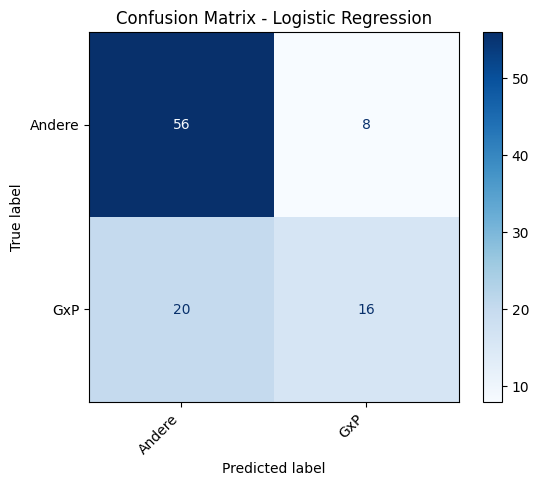

In [624]:
# Visualisierung der Confusion Matrix
new_disp_lgr = ConfusionMatrixDisplay(confusion_matrix=new_confm_lgr, display_labels=class_label)
new_disp_lgr.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.xticks(rotation=45, ha="right")
plt.show()

In [625]:
print(classification_report(new_y_validation, new_y_pred_lgr, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.74      0.88      0.80        64
         GxP       0.67      0.44      0.53        36

    accuracy                           0.72       100
   macro avg       0.70      0.66      0.67       100
weighted avg       0.71      0.72      0.70       100



In [626]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
new_y_prob_lgr = new_classif_lgr.predict_proba(X_validation_final)
new_loss_lgr = round(log_loss(new_y_validation, new_y_prob_lgr), 2)
print(f"Cross-Entropy Loss: {new_loss_lgr}")

Cross-Entropy Loss: 0.96


In [627]:
# MSE
new_mse_lgr = round(mean_squared_error(new_y_validation, new_y_pred_lgr), 2)
print(f"Mean Squared Error: {new_mse_lgr}")

Mean Squared Error: 0.28


In [628]:
# Accuracy
new_accuracy_lgr = round(accuracy_score(new_y_validation, new_y_pred_lgr), 4)
print(f"Accuracy: {new_accuracy_lgr}")

Accuracy: 0.72


In [629]:
# Balanced Accuracy
new_balanced_accuracy_lgr = round(balanced_accuracy_score(new_y_validation, new_y_pred_lgr), 4)
print(f"Balanced accuracy: {new_balanced_accuracy_lgr}")

Balanced accuracy: 0.6597


In [630]:
# Precision
new_precision_lgr = round(precision_score(new_y_validation, new_y_pred_lgr), 4)
print(f"Precision: {new_precision_lgr}")

Precision: 0.6667


In [631]:
# Recall
new_recall_lgr = round(recall_score(new_y_validation, new_y_pred_lgr), 4)
print(f"Recall: {new_recall_lgr}")

Recall: 0.4444


In [632]:
# F1-score
new_f1_lgr = round(f1_score(new_y_validation, new_y_pred_lgr), 4)
print(f"F1-score: {new_f1_lgr}")

F1-score: 0.5333


b. SVM

In [633]:
# Modelldefinition
new_classif_svm = SVC(kernel='linear', class_weight='balanced', C=1.0, gamma='scale', random_state=42, probability=True)
new_classif_svm.fit(X_train_final, merged_y_train)

#Erstellung von Prognosen
new_y_pred_svm = new_classif_svm.predict(X_validation_final)

In [634]:
# Berechnung der Confusion Matrix
new_confm_svm = confusion_matrix(new_y_validation, new_y_pred_svm)

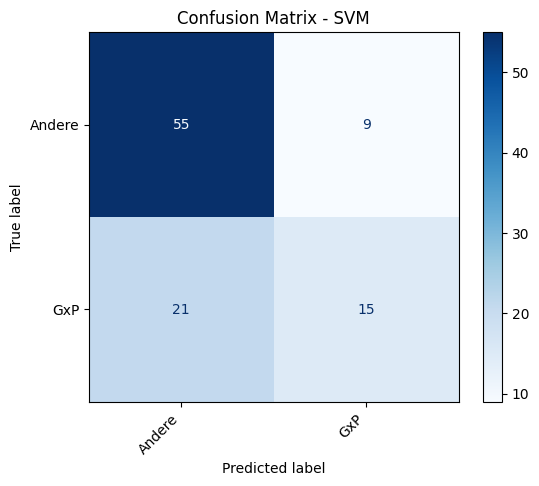

In [635]:
# Visualisierung der Confusion Matrix
new_disp_svm = ConfusionMatrixDisplay(confusion_matrix=new_confm_svm, display_labels=class_label)
new_disp_svm.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
plt.xticks(rotation=45, ha="right")
plt.show()

In [636]:
print(classification_report(new_y_validation, new_y_pred_svm, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.72      0.86      0.79        64
         GxP       0.62      0.42      0.50        36

    accuracy                           0.70       100
   macro avg       0.67      0.64      0.64       100
weighted avg       0.69      0.70      0.68       100



In [637]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
new_y_prob_svm = new_classif_svm.predict_proba(X_validation_final)
new_loss_svm = round(log_loss(new_y_validation, new_y_prob_svm), 2)
print(f"Cross-Entropy Loss: {new_loss_svm}")

Cross-Entropy Loss: 0.68


In [638]:
# MSE
new_mse_svm = round(mean_squared_error(new_y_validation, new_y_pred_svm), 2)
print(f"Mean Squared Error: {new_mse_svm}")

Mean Squared Error: 0.3


In [639]:
# Accuracy
new_accuracy_svm = round(accuracy_score(new_y_validation, new_y_pred_svm), 4)
print(f"Accuracy: {new_accuracy_svm}")

Accuracy: 0.7


In [640]:
# Balanced Accuracy
new_balanced_accuracy_svm = round(balanced_accuracy_score(new_y_validation, new_y_pred_svm), 4)
print(f"Balanced accuracy: {new_balanced_accuracy_svm}")

Balanced accuracy: 0.638


In [641]:
# Precision
new_precision_svm = round(precision_score(new_y_validation, new_y_pred_svm), 4)
print(f"Precision: {new_precision_svm}")

Precision: 0.625


In [642]:
# Recall
new_recall_svm = round(recall_score(new_y_validation, new_y_pred_svm), 4)
print(f"Recall: {new_recall_svm}")

Recall: 0.4167


In [643]:
# F1-score
new_f1_svm = round(f1_score(new_y_validation, new_y_pred_svm), 4)
print(f"F1-score: {new_f1_svm}")

F1-score: 0.5


c. Random Forests

In [644]:
# Modelldefinition
new_classif_rf = RandomForestClassifier(n_estimators=10, class_weight='balanced', random_state=42)
new_classif_rf.fit(X_train_final, merged_y_train)

#Erstellung von Prognosen
new_y_pred_rf = new_classif_rf.predict(X_validation_final)

In [645]:
# Berechnung der Confusion Matrix
new_confm_rf = confusion_matrix(new_y_validation, new_y_pred_rf)

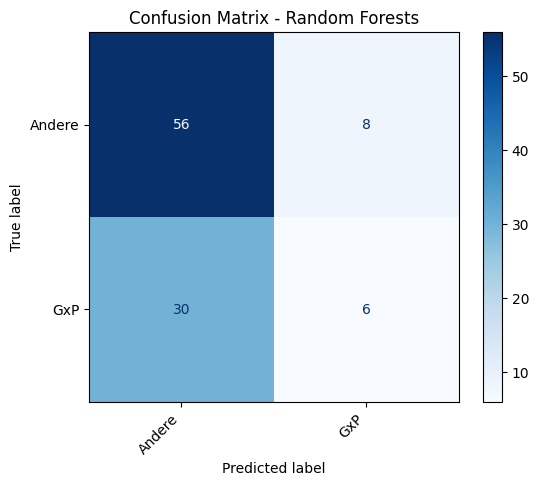

In [646]:
# Visualisierung der Confusion Matrix
new_disp_rf = ConfusionMatrixDisplay(confusion_matrix=new_confm_rf, display_labels=class_label)
new_disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forests")
plt.xticks(rotation=45, ha="right")
plt.show()

In [647]:
print(classification_report(new_y_validation, new_y_pred_rf, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.65      0.88      0.75        64
         GxP       0.43      0.17      0.24        36

    accuracy                           0.62       100
   macro avg       0.54      0.52      0.49       100
weighted avg       0.57      0.62      0.56       100



In [648]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
new_y_prob_rf = new_classif_rf.predict_proba(X_validation_final)
new_loss_rf = round(log_loss(new_y_validation, new_y_prob_rf), 2)
print(f"Cross-Entropy Loss: {new_loss_rf}")

Cross-Entropy Loss: 0.7


In [649]:
# MSE
new_mse_rf = round(mean_squared_error(new_y_validation, new_y_pred_rf), 2)
print(f"Mean Squared Error: {new_mse_rf}")

Mean Squared Error: 0.38


In [650]:
# Accuracy
new_accuracy_rf = round(accuracy_score(new_y_validation, new_y_pred_rf), 4)
print(f"Accuracy: {new_accuracy_rf}")

Accuracy: 0.62


In [651]:
# Balanced Accuracy
new_balanced_accuracy_rf = round(balanced_accuracy_score(new_y_validation, new_y_pred_rf), 4)
print(f"Balanced accuracy: {new_balanced_accuracy_rf}")

Balanced accuracy: 0.5208


In [652]:
# Precision
new_precision_rf = round(precision_score(new_y_validation, new_y_pred_rf), 4)
print(f"Precision: {new_precision_rf}")

Precision: 0.4286


In [653]:
# Recall
new_recall_rf = round(recall_score(new_y_validation, new_y_pred_rf), 4)
print(f"Recall: {new_recall_rf}")

Recall: 0.1667


In [654]:
# F1-score
new_f1_rf = round(f1_score(new_y_validation, new_y_pred_rf), 4)
print(f"F1-score: {new_f1_rf}")

F1-score: 0.24


d. NN mit L-BFGS

In [671]:
# Modelldefinition
new_classif_mlp = MLPClassifier(solver='lbfgs', max_iter=500, hidden_layer_sizes=(64, 32), alpha=0.01, learning_rate_init=0.01, 
                                early_stopping=True, random_state=42)
new_classif_mlp.fit(X_train_final, merged_y_train)

#Erstellung von Prognosen
new_y_pred_mlp = new_classif_mlp.predict(X_validation_final)

In [672]:
# Berechnung der Confusion Matrix
new_confm_mlp = confusion_matrix(new_y_validation, new_y_pred_mlp)

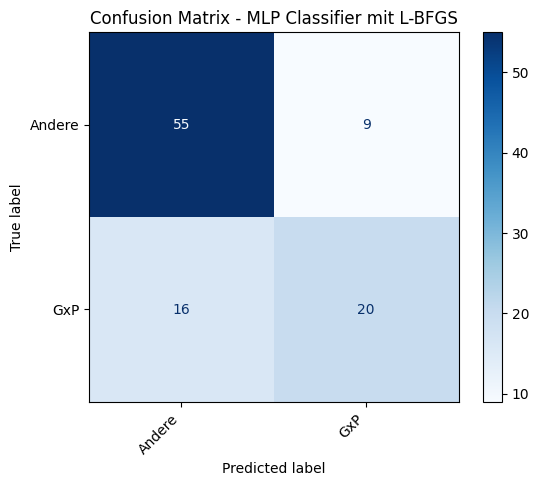

In [673]:
# Visualisierung der Confusion Matrix
new_disp_mlp = ConfusionMatrixDisplay(confusion_matrix=new_confm_mlp, display_labels=class_label)
new_disp_mlp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MLP Classifier mit L-BFGS")
plt.xticks(rotation=45, ha="right")
plt.show()

In [674]:
print(classification_report(new_y_validation, new_y_pred_mlp, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.77      0.86      0.81        64
         GxP       0.69      0.56      0.62        36

    accuracy                           0.75       100
   macro avg       0.73      0.71      0.72       100
weighted avg       0.74      0.75      0.74       100



In [675]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
new_y_prob_mlp = new_classif_mlp.predict_proba(X_validation_final)
new_loss_mlp = round(log_loss(new_y_validation, new_y_prob_mlp), 2)
print(f"Cross-Entropy Loss: {new_loss_mlp}")

Cross-Entropy Loss: 0.81


In [676]:
# MSE
new_mse_mlp = round(mean_squared_error(new_y_validation, new_y_pred_mlp), 2)
print(f"Mean Squared Error: {new_mse_mlp}")

Mean Squared Error: 0.25


In [677]:
# Accuracy
new_accuracy_mlp = round(accuracy_score(new_y_validation, new_y_pred_mlp), 4)
print(f"Accuracy: {new_accuracy_mlp}")

Accuracy: 0.75


In [678]:
# Balanced Accuracy
new_balanced_accuracy_mlp = round(balanced_accuracy_score(new_y_validation, new_y_pred_mlp), 4)
print(f"Balanced accuracy: {new_balanced_accuracy_mlp}")

Balanced accuracy: 0.7075


In [679]:
# Precision
new_precision_mlp = round(precision_score(new_y_validation, new_y_pred_mlp), 4)
print(f"Precision: {new_precision_mlp}")

Precision: 0.6897


In [680]:
# Recall
new_recall_mlp = round(recall_score(new_y_validation, new_y_pred_mlp), 4)
print(f"Recall: {new_recall_mlp}")

Recall: 0.5556


In [681]:
# F1-score
new_f1_mlp = round(f1_score(new_y_validation, new_y_pred_mlp), 4)
print(f"F1-score: {new_f1_mlp}")

F1-score: 0.6154


e. NN Keras/Adam

In [682]:
# Modelldefinition
new_classif_keradam = Sequential([
    Input(shape=(X_train_final.shape[1],)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Modell kompilieren
new_classif_keradam.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

new_classif_keradam.fit(X_train_final, merged_y_train,
        epochs=100, batch_size=16,
        validation_data=(X_validation_final, new_y_validation),
        verbose=1)

#Erstellung von Prognosen
new_y_pred_keradam = new_classif_keradam.predict(X_validation_final)
new_y_pred_keradam_labels = (new_y_pred_keradam > 0.6).astype("int32")

Epoch 1/100
13/13 [==============================] - 2s 37ms/step - loss: 0.4208 - accuracy: 0.7950 - val_loss: 0.9252 - val_accuracy: 0.4100
Epoch 2/100
13/13 [==============================] - 0s 13ms/step - loss: 0.1207 - accuracy: 0.9450 - val_loss: 0.7725 - val_accuracy: 0.4700
Epoch 3/100
13/13 [==============================] - 0s 14ms/step - loss: 0.0661 - accuracy: 0.9700 - val_loss: 0.6949 - val_accuracy: 0.5500
Epoch 4/100
13/13 [==============================] - 0s 12ms/step - loss: 0.0504 - accuracy: 0.9850 - val_loss: 0.6612 - val_accuracy: 0.6500
Epoch 5/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0405 - accuracy: 0.9900 - val_loss: 0.6583 - val_accuracy: 0.6700
Epoch 6/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0340 - accuracy: 0.9900 - val_loss: 0.6547 - val_accuracy: 0.7100
Epoch 7/100
13/13 [==============================] - 0s 11ms/step - loss: 0.0285 - accuracy: 0.9900 - val_loss: 0.6465 - val_accuracy: 0.6700
Epoch 

In [683]:
# Berechnung der Confusion Matrix
new_confm_keradam = confusion_matrix(new_y_validation, new_y_pred_keradam_labels)

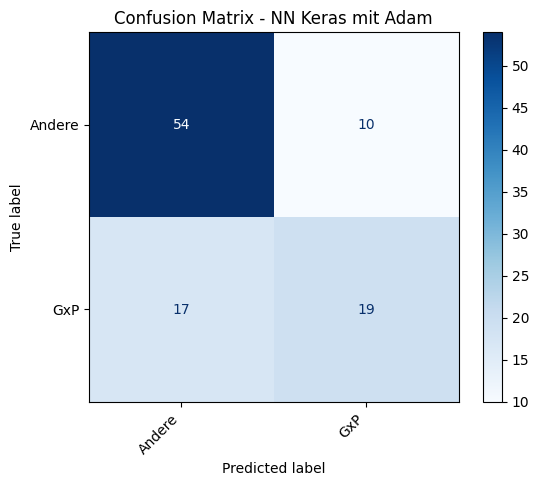

In [684]:
# Visualisierung der Confusion Matrix
new_disp_keradam = ConfusionMatrixDisplay(confusion_matrix=new_confm_keradam, display_labels=class_label)
new_disp_keradam.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - NN Keras mit Adam")
plt.xticks(rotation=45, ha="right")
plt.show()

In [685]:
print(classification_report(new_y_validation, new_y_pred_keradam_labels, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.76      0.84      0.80        64
         GxP       0.66      0.53      0.58        36

    accuracy                           0.73       100
   macro avg       0.71      0.69      0.69       100
weighted avg       0.72      0.73      0.72       100



In [686]:
# y_pred_keradam flatten, damit es der Form von y_validation_doc2vec entspricht
new_y_pred_keradam_flat = new_y_pred_keradam.flatten()
# Binary Cross-Entropy loss
new_loss_keradam = tf.reduce_mean(tf.keras.losses.binary_crossentropy(new_y_validation, new_y_pred_keradam_flat))
# Tensor zum Drucken in numpy konvertieren
new_loss_keradam = round(np.float64(new_loss_keradam.numpy()), 2)
print(f"Cross-Entropy Loss: {new_loss_keradam}")

Cross-Entropy Loss: 0.94


In [687]:
# MSE
new_mse_keradam = round(mean_squared_error(new_y_validation, new_y_pred_keradam_labels), 2)
print(f"Mean Squared Error: {new_mse_keradam}")

Mean Squared Error: 0.27


In [688]:
# Accuracy
new_accuracy_keradam = round(accuracy_score(new_y_validation, new_y_pred_keradam_labels), 4)
print(f"Accuracy: {new_accuracy_keradam}")

Accuracy: 0.73


In [689]:
# Balanced Accuracy
new_balanced_accuracy_keradam = round(balanced_accuracy_score(new_y_validation, new_y_pred_keradam_labels), 4)
print(f"Balanced accuracy: {new_balanced_accuracy_keradam}")

Balanced accuracy: 0.6858


In [690]:
# Precision
new_precision_keradam = round(precision_score(new_y_validation, new_y_pred_keradam_labels), 4)
print(f"Precision: {new_precision_keradam}")

Precision: 0.6552


In [691]:
# Recall
new_recall_keradam = round(recall_score(new_y_validation, new_y_pred_keradam_labels), 4)
print(f"Recall: {new_recall_keradam}")

Recall: 0.5278


In [692]:
# F1-score
new_f1_keradam = round(f1_score(new_y_validation, new_y_pred_keradam_labels), 4)
print(f"F1-score: {new_f1_keradam}")

F1-score: 0.5846


f. XGBoost

In [699]:
# Modelldefinition
new_classif_xgboost = XGBClassifier(objective='binary:logistic', eval_metric='logloss', learning_rate=0.1, random_state=42)
new_classif_xgboost.fit(X_train_final, merged_y_train)

#Erstellung von Prognosen
new_y_pred_xgboost = new_classif_xgboost.predict(X_validation_final)

In [700]:
# Berechnung der Confusion Matrix
new_confm_xgboost = confusion_matrix(new_y_validation, new_y_pred_xgboost)

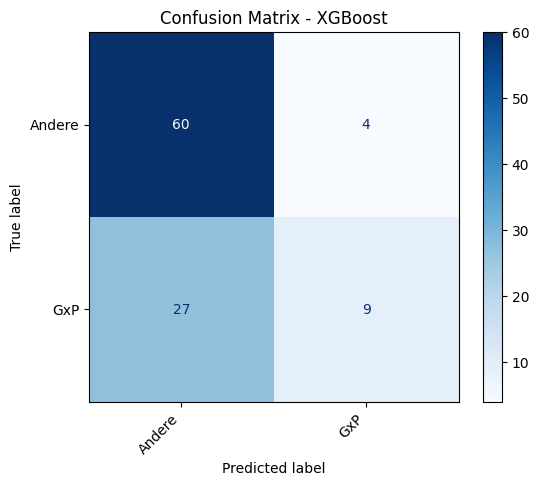

In [701]:
# Visualisierung der Confusion Matrix
new_disp_xgboost = ConfusionMatrixDisplay(confusion_matrix=new_confm_xgboost, display_labels=class_label)
new_disp_xgboost.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.xticks(rotation=45, ha="right")
plt.show()

In [702]:
print(classification_report(new_y_validation, new_y_pred_xgboost, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.69      0.94      0.79        64
         GxP       0.69      0.25      0.37        36

    accuracy                           0.69       100
   macro avg       0.69      0.59      0.58       100
weighted avg       0.69      0.69      0.64       100



In [703]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
new_y_prob_xgboost = new_classif_xgboost.predict_proba(X_validation_final)
new_loss_xgboost = round(log_loss(new_y_validation, new_y_prob_xgboost), 2)
print(f"Cross-Entropy Loss: {new_loss_xgboost}")

Cross-Entropy Loss: 0.76


In [704]:
# MSE
new_mse_xgboost = round(mean_squared_error(new_y_validation, new_y_pred_xgboost), 2)
print(f"Mean Squared Error: {new_mse_xgboost}")

Mean Squared Error: 0.31


In [705]:
# Accuracy
new_accuracy_xgboost = round(accuracy_score(new_y_validation, new_y_pred_xgboost), 4)
print(f"Accuracy: {new_accuracy_xgboost}")

Accuracy: 0.69


In [706]:
# Balanced Accuracy
new_balanced_accuracy_xgboost = round(balanced_accuracy_score(new_y_validation, new_y_pred_xgboost), 4)
print(f"Balanced accuracy: {new_balanced_accuracy_xgboost}")

Balanced accuracy: 0.5938


In [707]:
# Precision
new_precision_xgboost = round(precision_score(new_y_validation, new_y_pred_xgboost), 4)
print(f"Precision: {new_precision_xgboost}")

Precision: 0.6923


In [708]:
# Recall
new_recall_xgboost = round(recall_score(new_y_validation, new_y_pred_xgboost), 4)
print(f"Recall: {new_recall_xgboost}")

Recall: 0.25


In [709]:
# F1-score
new_f1_xgboost = round(f1_score(new_y_validation, new_y_pred_xgboost), 4)
print(f"F1-score: {new_f1_xgboost}")

F1-score: 0.3673


g. CatBoost

In [731]:
# Modelldefinition
new_classif_cat = CatBoostClassifier(verbose=0, scale_pos_weight=6, learning_rate=0.1, depth=6, eval_metric='F1', random_state=42)
new_classif_cat.fit(X_train_final, merged_y_train)

#Erstellung von Prognosen
new_y_pred_cat = new_classif_cat.predict(X_validation_final)

In [732]:
# Berechnung der Confusion Matrix
new_confm_cat = confusion_matrix(new_y_validation, new_y_pred_cat)

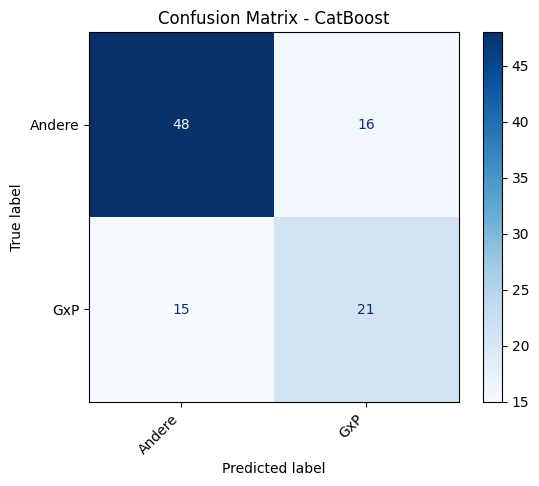

In [733]:
# Visualisierung der Confusion Matrix
new_disp_cat = ConfusionMatrixDisplay(confusion_matrix=new_confm_cat, display_labels=class_label)
new_disp_cat.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CatBoost")
plt.xticks(rotation=45, ha="right")
plt.show()

In [734]:
print(classification_report(new_y_validation, new_y_pred_cat, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.76      0.75      0.76        64
         GxP       0.57      0.58      0.58        36

    accuracy                           0.69       100
   macro avg       0.66      0.67      0.67       100
weighted avg       0.69      0.69      0.69       100



In [735]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
new_y_prob_cat = new_classif_cat.predict_proba(X_validation_final)
new_loss_cat = round(log_loss(new_y_validation, new_y_prob_cat), 2)
print(f"Cross-Entropy Loss: {new_loss_cat}")

Cross-Entropy Loss: 0.63


In [736]:
# MSE
new_mse_cat = round(mean_squared_error(new_y_validation, new_y_pred_cat), 2)
print(f"Mean Squared Error: {new_mse_cat}")

Mean Squared Error: 0.31


In [737]:
# Accuracy
new_accuracy_cat = round(accuracy_score(new_y_validation, new_y_pred_cat), 4)
print(f"Accuracy: {new_accuracy_cat}")

Accuracy: 0.69


In [738]:
# Balanced Accuracy
new_balanced_accuracy_cat = round(balanced_accuracy_score(new_y_validation, new_y_pred_cat), 4)
print(f"Balanced accuracy: {new_balanced_accuracy_cat}")

Balanced accuracy: 0.6667


In [739]:
# Precision
new_precision_cat = round(precision_score(new_y_validation, new_y_pred_cat), 4)
print(f"Precision: {new_precision_cat}")

Precision: 0.5676


In [740]:
# Recall
new_recall_cat = round(recall_score(new_y_validation, new_y_pred_cat), 4)
print(f"Recall: {new_recall_cat}")

Recall: 0.5833


In [741]:
# F1-score
new_f1_cat = round(f1_score(new_y_validation, new_y_pred_cat), 4)
print(f"F1-score: {new_f1_cat}")

F1-score: 0.5753


h. Bootstrap (Bagging)

In [535]:
# Modelldefinition
new_classif_bag = BaggingClassifier(n_estimators=100, bootstrap=True, random_state=42)
new_classif_bag.fit(X_train_final, merged_y_train)

#Erstellung von Prognosen
new_y_pred_bag = new_classif_bag.predict(X_validation_final)

In [536]:
# Berechnung der Confusion Matrix
new_confm_bag = confusion_matrix(new_y_validation, new_y_pred_bag)

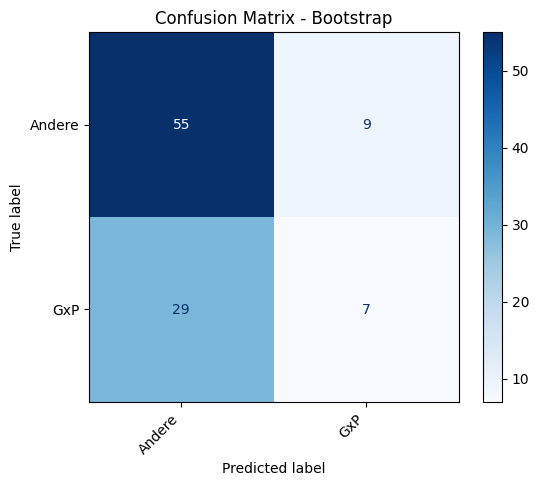

In [537]:
# Visualisierung der Confusion Matrix
new_disp_bag = ConfusionMatrixDisplay(confusion_matrix=new_confm_bag, display_labels=class_label)
new_disp_bag.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Bootstrap")
plt.xticks(rotation=45, ha="right")
plt.show()

In [538]:
print(classification_report(new_y_validation, new_y_pred_bag, target_names=class_label))

              precision    recall  f1-score   support

      Andere       0.65      0.86      0.74        64
         GxP       0.44      0.19      0.27        36

    accuracy                           0.62       100
   macro avg       0.55      0.53      0.51       100
weighted avg       0.58      0.62      0.57       100



In [539]:
# Vorhergesagte Wahrscheinlichkeiten für jede Klasse abrufen, um den binären Cross-Entropy Loss zu berechnen
new_y_prob_bag = new_classif_bag.predict_proba(X_validation_final)
new_loss_bag = round(log_loss(new_y_validation, new_y_prob_bag), 2)
print(f"Cross-Entropy Loss: {new_loss_bag}")

Cross-Entropy Loss: 0.73


In [540]:
# MSE
new_mse_bag = round(mean_squared_error(new_y_validation, new_y_pred_bag), 2)
print(f"Mean Squared Error: {new_mse_bag}")

Mean Squared Error: 0.38


In [541]:
# Accuracy
new_accuracy_bag = round(accuracy_score(new_y_validation, new_y_pred_bag), 4)
print(f"Accuracy: {new_accuracy_bag}")

Accuracy: 0.62


In [542]:
# Balanced Accuracy
new_balanced_accuracy_bag = round(balanced_accuracy_score(new_y_validation, new_y_pred_bag), 4)
print(f"Balanced accuracy: {new_balanced_accuracy_bag}")

Balanced accuracy: 0.5269


In [543]:
# Precision
new_precision_bag = round(precision_score(new_y_validation, new_y_pred_bag), 4)
print(f"Precision: {new_precision_bag}")

Precision: 0.4375


In [544]:
# Recall
new_recall_bag = round(recall_score(new_y_validation, new_y_pred_bag), 4)
print(f"Recall: {new_recall_bag}")

Recall: 0.1944


In [545]:
# F1-score
new_f1_bag = round(f1_score(new_y_validation, new_y_pred_bag), 4)
print(f"F1-score: {new_f1_bag}")

F1-score: 0.2692


Zusammenfassende Ergebnistabelle

In [742]:
new_data = {
    metrics[0]: [new_loss_lgr, new_loss_svm, new_loss_rf, new_loss_mlp, new_loss_keradam, new_loss_xgboost, new_loss_cat, new_loss_bag],
    metrics[1]: [new_mse_lgr, new_mse_svm, new_mse_rf, new_mse_mlp, new_mse_keradam, new_mse_xgboost, new_mse_cat, new_mse_bag],
    metrics[2]: [new_accuracy_lgr, new_accuracy_svm, new_accuracy_rf, new_accuracy_mlp, new_accuracy_keradam, new_accuracy_xgboost, 
                 new_accuracy_cat, new_accuracy_bag],
    metrics[3]: [new_balanced_accuracy_lgr, new_balanced_accuracy_svm, new_balanced_accuracy_rf, new_balanced_accuracy_mlp, 
                 new_balanced_accuracy_keradam, new_balanced_accuracy_xgboost, new_balanced_accuracy_cat, new_balanced_accuracy_bag],
    metrics[4]: [new_precision_lgr, new_precision_svm, new_precision_rf, new_precision_mlp, new_precision_keradam, new_precision_xgboost, 
                 new_precision_cat, new_precision_bag],
    metrics[5]: [new_recall_lgr, new_recall_svm, new_recall_rf, new_recall_mlp, new_recall_keradam, new_recall_xgboost, 
                 new_recall_cat, new_recall_bag],
    metrics[6]: [new_f1_lgr, new_f1_svm, new_f1_rf, new_f1_mlp, new_f1_keradam, new_f1_xgboost, new_f1_cat, new_f1_bag]
}

new_table = pd.DataFrame(new_data, index=methods)
new_table['Cross-Entropy Loss'] = pd.to_numeric(new_table['Cross-Entropy Loss'], errors='coerce')

# Find max values 
new_max_balanced_accuracy = new_table['Balanced Accuracy'].max()
new_max_F1_score = new_table['F1-Score'].max()

# Function to highlight min/max values
def new_highlight_max(val):
    if pd.isna(val) or val == '-':
        return ''
   
    if val == new_max_balanced_accuracy:
        return 'background-color: yellow'
        
    if val == new_max_F1_score:
        return 'background-color: yellow' 
    return ''

# Apply the highlighting to selected columns
new_styled_table = new_table.style.format(format_round).map(new_highlight_max, subset=['Balanced Accuracy', 'F1-Score'])
new_styled_table

,Cross-Entropy Loss,MSE,Accuracy,Balanced Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.96,0.28,0.7200,0.6597,0.6667,0.4444,0.533300
SVM,0.68,0.30,0.7000,0.6380,0.6250,0.4167,0.500000
Random Forest,0.70,0.38,0.6200,0.5208,0.4286,0.1667,0.240000
NN mit L-BFGS,0.81,0.25,0.7500,0.7075,0.6897,0.5556,0.615400
NN Keras/Adam,0.94,0.27,0.7300,0.6858,0.6552,0.5278,0.584600
XGBoost,0.76,0.31,0.6900,0.5938,0.6923,0.2500,0.367300
CatBoost,0.63,0.31,0.6900,0.6667,0.5676,0.5833,0.575300
Bootstrap (Bagging),0.73,0.38,0.6200,0.5269,0.4375,0.1944,0.269200


#### Schritt 11: Wiederholung von Schritt 7. Feature importances

Bewertung von Features für das beste Modell mithilfe von Feature-Importances

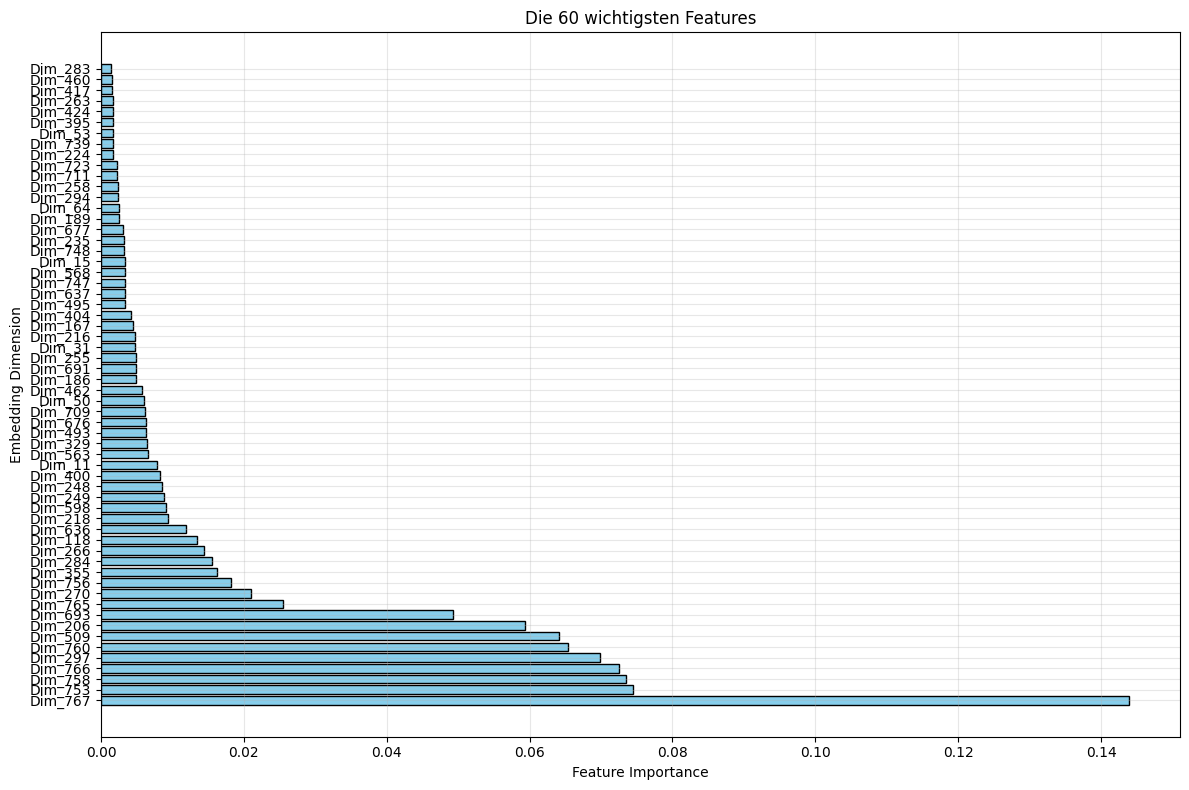

In [613]:
new_importances = new_classif_rf.feature_importances_
new_top_features_60 = np.argsort(new_importances)[-60:]
new_top_features = new_importances[new_top_features_60]

plt.figure(figsize=(12, 8))
plt.barh(range(len(new_top_features_60)), new_top_features[::-1], color='skyblue', edgecolor='black')
plt.xlabel('Feature Importance')
plt.ylabel('Embedding Dimension')
plt.title('Die 60 wichtigsten Features')
plt.yticks(range(len(new_top_features_60)), [f'Dim_{idx}' for idx in new_top_features_60[::-1]])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Schritt 12. Anwendung der besten Modelle auf nicht markierte Daten und Analyse der Ergebnisse

Die besten Modelle wurden ausgewählt

Erstellung von Prognosen NN mit L-BFGS

In [747]:
test_predictions_mlp = new_classif_mlp.predict(X_test_final)
test_probabilities_mlp = new_classif_mlp.predict_proba(X_test_final)

In [748]:
counts_mlp = Counter(test_predictions_mlp)

print(f"Class Andere: {counts_mlp.get(0, 0)} ({counts_mlp.get(0, 0)/len(test_predictions_mlp)*100:.1f}%)")
print(f"Class GxP: {counts_mlp.get(1, 0)} ({counts_mlp.get(1, 0)/len(test_predictions_mlp)*100:.1f}%)")

Class Andere: 12706 (91.8%)
Class GxP: 1139 (8.2%)


Erstellung von Prognosen CatBoost

In [743]:
test_predictions_cat = new_classif_cat.predict(X_test_final)
test_probabilities_cat = new_classif_cat.predict_proba(X_test_final)

In [744]:
counts_cat = Counter(test_predictions_cat)

print(f"Class Andere: {counts_cat.get(0, 0)} ({counts_cat.get(0, 0)/len(test_predictions_cat)*100:.1f}%)")
print(f"Class GxP: {counts_cat.get(1, 0)} ({counts_cat.get(1, 0)/len(test_predictions_cat)*100:.1f}%)")

Class Andere: 12580 (90.9%)
Class GxP: 1265 (9.1%)


Erstellung von Prognosen Logistic regression	

In [745]:
test_predictions_lgr = new_classif_lgr.predict(X_test_final)
test_probabilities_lgr = new_classif_lgr.predict_proba(X_test_final)

In [746]:
counts_lgr = Counter(test_predictions_lgr)

print(f"Class Andere: {counts_lgr.get(0, 0)} ({counts_lgr.get(0, 0)/len(test_predictions_lgr)*100:.1f}%)")
print(f"Class GxP: {counts_lgr.get(1, 0)} ({counts_lgr.get(1, 0)/len(test_predictions_lgr)*100:.1f}%)")

Class Andere: 12710 (91.8%)
Class GxP: 1135 (8.2%)


Erhalt einer Anzahl identischer Prognosen aus drei Modellen

In [749]:
agreement = (test_predictions_mlp == test_predictions_cat) & (test_predictions_cat == test_predictions_lgr) & \
            (test_predictions_mlp == test_predictions_lgr)
percent_agreement = (np.sum(agreement) / len(test_predictions_lgr)) * 100
print(f"Vollständige Übereinstimmung aller Modelle: {np.sum(agreement)} / {len(test_predictions_lgr)} ({percent_agreement:.2f}%)")

Vollständige Übereinstimmung aller Modelle: 13070 / 13845 (94.40%)


Plot der Wahrscheinlichkeitsverteilung

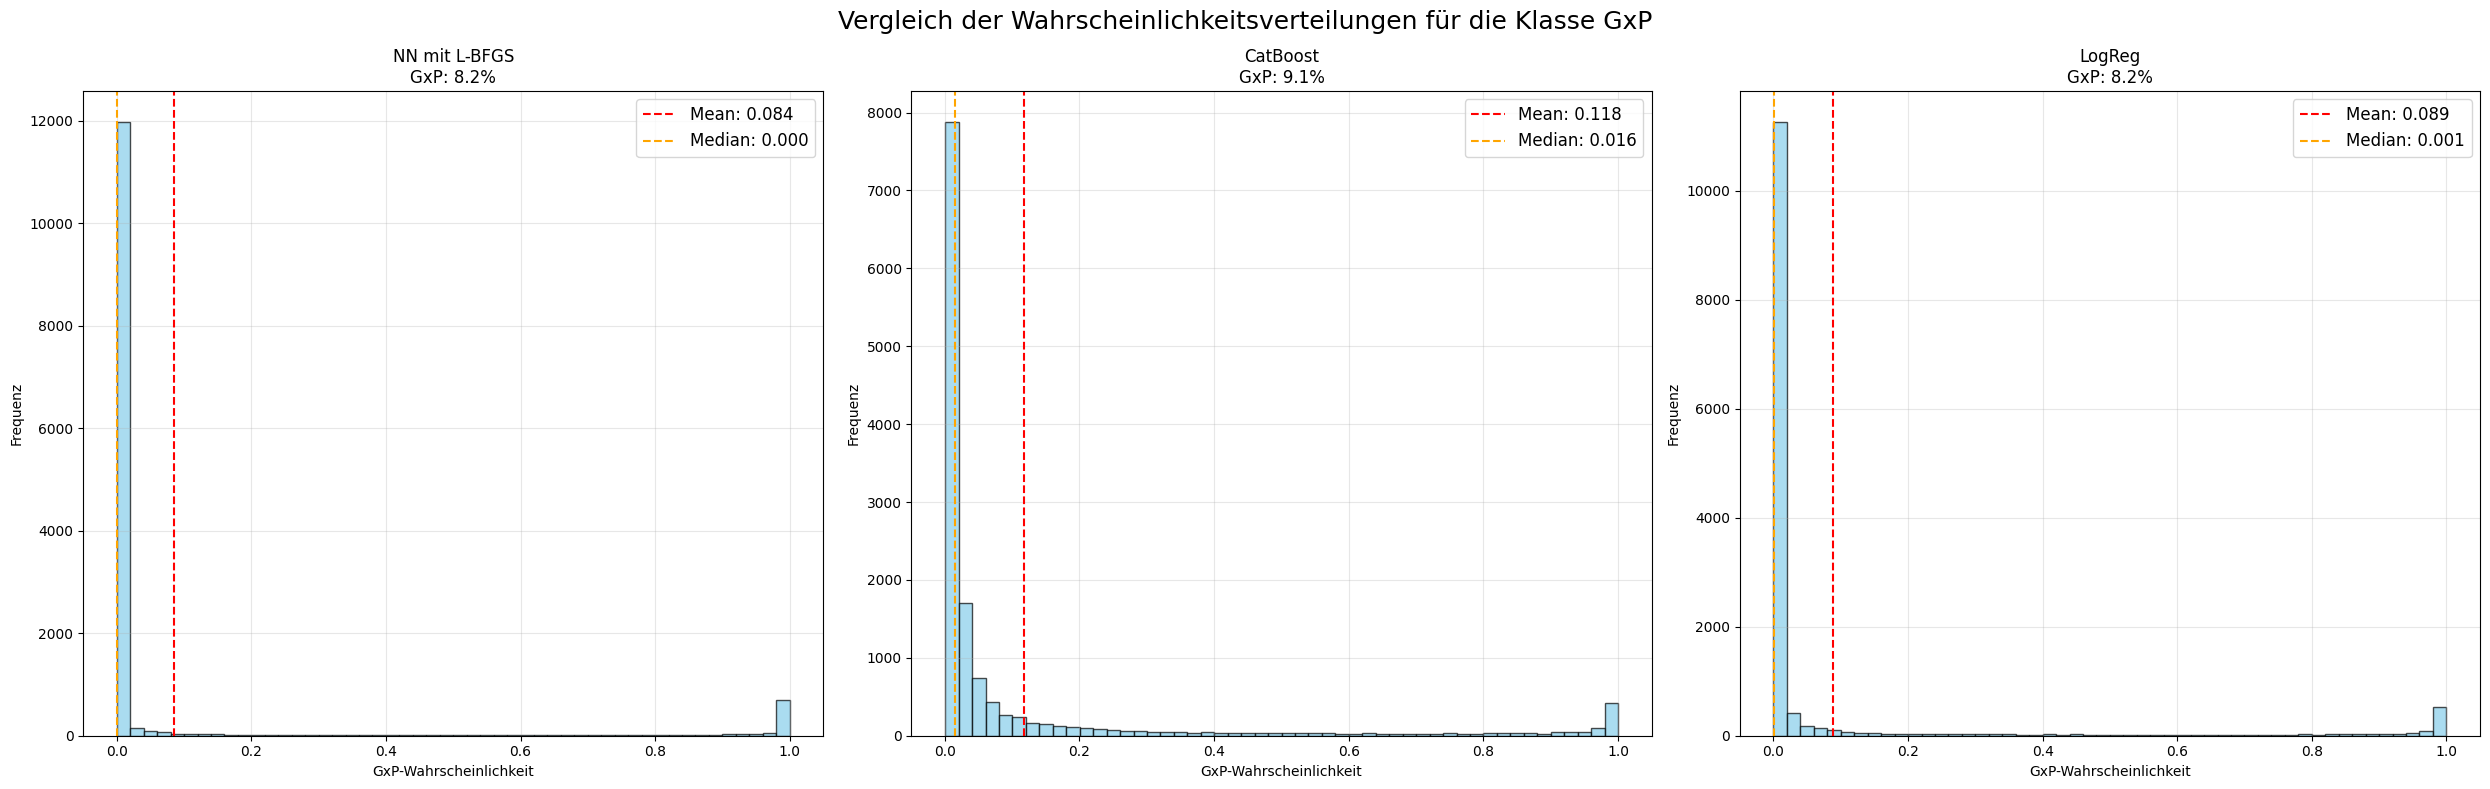

In [750]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
fig.suptitle('Vergleich der Wahrscheinlichkeitsverteilungen für die Klasse GxP', fontsize=18)

plot_data = [
    ('NN mit L-BFGS', test_probabilities_mlp[:, 1]),
    ('CatBoost', test_probabilities_cat[:, 1]),
    ('LogReg', test_probabilities_lgr[:, 1])
]

for i, (name, probs) in enumerate(plot_data):
    axes[i].hist(probs, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].axvline(np.mean(probs), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(probs):.3f}')
    axes[i].axvline(np.median(probs), color='orange', linestyle='--',
                       label=f'Median: {np.median(probs):.3f}')
        
    axes[i].set_title(f'{name}\nGxP: {((probs > 0.5).sum() / len(probs) * 100):.1f}%')
    axes[i].set_xlabel('GxP-Wahrscheinlichkeit')
    axes[i].set_ylabel('Frequenz')
    axes[i].legend(fontsize=12)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Schritt 13. Ensemblierung von Modellen

Durchschnittliche Wahrscheinlichkeit für Klasse 1 (GxP)

In [751]:
ensemble_proba = (test_probabilities_mlp[:, 1] + test_probabilities_lgr[:, 1] + test_probabilities_cat[:, 1]) / 3

ensemble_predictions = (ensemble_proba > 0.5).astype(int)

unique_ensemble, counts_ensemble = np.unique(ensemble_predictions, return_counts=True)
for cls, count in zip(unique_ensemble, counts_ensemble):
    name = 'GxP' if cls == 1 else 'Andere'
    print(f"Ensembled Class {name}: {count} ({count/len(ensemble_predictions)*100:.1f}%)")

Ensembled Class Andere: 12753 (92.1%)
Ensembled Class GxP: 1092 (7.9%)


Aufnahme der erhaltenen Tags ins Dataset

In [752]:
new_test_subset['label_GxP'] = ensemble_predictions

#### Schritt 14. Speichern der Ergebnisse

Hinzufügen von Labels zum Dataset

In [753]:
# Aus dem Dataset für das Training
features_fiori.loc[train_relevant.index, 'label_GxP'] = train_relevant['label_GxP'].values
features_fiori.loc[train_irrelevant.index, 'label_GxP'] = train_irrelevant['label_GxP'].values

In [754]:
# Aus dem ersten Dataset für die Validierung
features_fiori.loc[validation_subset.index, 'label_GxP'] = validation_subset['label_GxP'].values

In [755]:
# Aus dem zweiten Dataset für die Validierung
features_fiori.loc[new_validation_subset.index, 'label_GxP'] = new_validation_subset['label_GxP'].values

In [756]:
# Aus dem Dataset für den Test
features_fiori.loc[new_test_subset.index, 'label_GxP'] = new_test_subset['label_GxP'].values

In [757]:
features_fiori['label_GxP'].value_counts()

label_GxP
0    12935
1     1210
Name: count, dtype: int64

Erstellen einer Kopie der Originaldatei und einer Spalte für Labels

In [759]:
fiori_mit_labels = fiori.copy()

In [760]:
print(new_test_subset.index.min(), new_test_subset.index.max())
print(fiori_mit_labels.index.min(), fiori_mit_labels.index.max())

0 14144
0 14144


In [761]:
fiori_mit_labels['label_GxP_Ansatz-1'] = None

In [762]:
fiori_mit_labels.loc[features_fiori.index, 'label_GxP_Ansatz-1'] = features_fiori['label_GxP'].values

Speichern der Ergebnisse

In [763]:
# Speichern der Ergebnisse in Excel
features_fiori.to_excel("features_fiori.xlsx", index=False)
fiori_mit_labels.to_excel("fiori_mit_labels.xlsx", index=False)

In [764]:
# Speichern der Ergebnisse in csv
features_fiori.to_csv("features_fiori.csv", index=False)
fiori_mit_labels.to_csv("fiori_mit_labels.csv", index=False)

#### Schritt 13. Embedding-Plots: UMAP Projection

In [765]:
embedding_all = np.vstack([merged_X_train_reduced, new_X_validation_reduced, new_X_test_reduced])

C:\Users\yulia\anaconda3\envs\env_final\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\yulia\anaconda3\envs\env_final\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


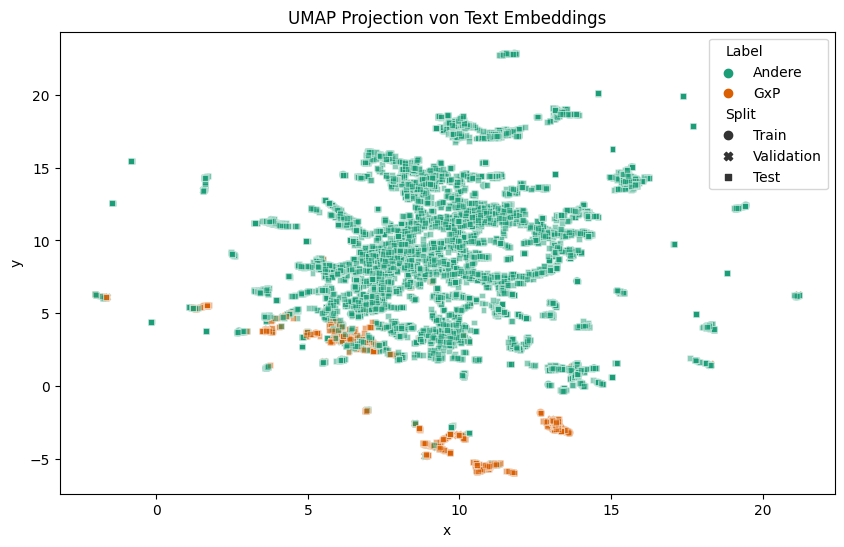

In [766]:
split_type = (['Train'] * len(merged_X_train_reduced) +
              ['Validation'] * len(new_X_validation_reduced) +
              ['Test'] * len(new_X_test_reduced))

all_labels = list(merged_y_train) + list(new_y_validation) + list(ensemble_predictions)
class_labels = ['GxP' if y == 1 else 'Andere' for y in all_labels]

embeddingplt = umap.UMAP(random_state=42).fit_transform(embedding_all)

df_plot = pd.DataFrame(embeddingplt, columns=["x", "y"])
df_plot["Dataset"] = split_type
df_plot["Label"] = class_labels
df_plot['Split'] = df_plot['Dataset']

# Visualisierung
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot, x='x', y='y', hue='Label', style='Split', alpha=0.5, palette='Dark2')
plt.title("UMAP Projection von Text Embeddings")
plt.show()

### Ansatz 2: ML-basiert - SetFit

#### Schritt 1. Datasets Vorbereitung

Erstellen eines Datasets mit Labels für das Training aus einem zuvor annotierten Dataset

In [ ]:
validation_subset = pd.read_csv("validation_labeled.csv")

In [767]:
# Training Dataset
train_ml_ansatz = validation_subset[['merged_text','label_GxP']].copy()
train_ml_ansatz.to_csv("train_ml_ansatz.tsv", sep="\t", index=False, header=False)

Erstellen eines Datasets für das Test

In [ ]:
features_fiori = pd.read_csv("features_fiori.csv")

In [768]:
# Entfernt die im Training verwendeten Indizes für das Test-Dataset
test_ml_ansatz = features_fiori[~features_fiori.index.isin(validation_subset.index)].copy()

In [769]:
# Check
set(test_ml_ansatz.index) & set(train_ml_ansatz.index)

set()

In [770]:
# Erstellt eine Spalte für die Prognose
test_ml_ansatz['label_ml_ansatz'] = None

In [771]:
test_ml_ansatz[['merged_text', 'label_ml_ansatz']].to_csv("test_ml_ansatz.tsv", sep="\t", index=False, header=False)

#### Schritt 2. Modelltraining mit SetFit

In [772]:
# Import von Bibliotheken
from setfit import SetFitModel, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

Laden eines Datasets mit Labels für das Training aus einem zuvor annotierten Dataset

In [ ]:
# Das Dataset wird aus der TSV-Datei geladen
doc1 = pd.read_csv("train_ml_ansatz.tsv", sep="\t", names=["text", "label"])
dataset1 = Dataset.from_pandas(doc1)

In [774]:
train_ml_dataset = DatasetDict({"train": dataset1})

Laden eines Datasets für das Test

In [ ]:
# Das Dataset wird aus der TSV-Datei geladen
doc2 = pd.read_csv("test_ml_ansatz.tsv", sep="\t", names=["text", "label"])
dataset2 = Dataset.from_pandas(doc2)

In [776]:
test_ml_dataset = DatasetDict({"test": dataset2})

Laden eines Datasets für die Validierung

In [777]:
doc3 = pd.read_csv("new_validation_labeled.csv")

In [778]:
doc3_ed = doc3[["merged_text", "label_GxP"]].copy()
doc3_ed = doc3_ed[["merged_text", "label_GxP"]].rename(columns={"merged_text": "text", "label_GxP": "label"})

In [ ]:
valid_dataset = Dataset.from_pandas(doc3_ed)

In [780]:
valid_ml_dataset = DatasetDict({"val": valid_dataset})

Training

In [781]:
# Initialisierung eines neuen SetFit-Modells
model_ml = SetFitModel.from_pretrained(
    "sentence-transformers/all-MiniLM-L6-v2",
    labels=[0, 1]
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [782]:
# Funktion zur Berechnung von Klassifizierungsmetriken
def compute_metrics(y_predict, y_true):
    accuracy = accuracy_score(y_true, y_predict)
    balanced_accuracy = balanced_accuracy_score(y_true, y_predict)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_predict, average='binary')
    
    return {
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [786]:
args = TrainingArguments(
    batch_size=2,
    num_epochs=1,
    logging_steps=20,
    seed=42,
    save_strategy="no",
    metric_for_best_model="eval_f1",
    load_best_model_at_end=True,
    greater_is_better=True
)

In [787]:
trainer = Trainer(
    model=model_ml,
    args=args,
    train_dataset=train_ml_dataset["train"],
    eval_dataset=valid_ml_dataset["val"],
    metric=compute_metrics
)

  0%|          | 0/100 [00:00<?, ?ex/s]

In [788]:
trainer.train()

***** Running training *****
  Num unique pairs = 5748
  Batch size = 2
  Num epochs = 1
  Total optimization steps = 2874


Step,Training Loss


In [789]:
model_ml.save_pretrained("models/setfit_metrics")

#### Schritt 3. Vorhersage von Labels auf einem TEST-Dataset

Evaluierung des Modells anhand eines Datesets zur Validierung

In [790]:
metrics_valid = trainer.evaluate()
print("Validation metrics: ", metrics_valid)

***** Running evaluation *****


Validation metrics:  {'accuracy': 0.69, 'balanced_accuracy': 0.6484375, 'precision': 0.5806451612903226, 'recall': 0.5, 'f1': 0.5373134328358209}


Vorhersage anhand eines Test Datasets

In [791]:
preds_test = model_ml.predict(test_ml_dataset["test"]["text"])

Ergebnisse im selben Dokument speichern

In [ ]:
# Datei beim Neustart des Kernels laden
fiori_mit_labels = pd.read_csv("fiori_mit_labels.csv")

In [792]:
fiori_mit_labels['label_GxP_Ansatz-2'] = None

In [793]:
fiori_mit_labels.loc[validation_subset.index, 'label_GxP_Ansatz-2'] = validation_subset['label_GxP']

In [794]:
test_indices = test_ml_ansatz.index

In [795]:
len(test_indices) == len(preds_test)

True

In [796]:
fiori_mit_labels.loc[test_indices, 'label_GxP_Ansatz-2'] = preds_test

In [797]:
# Speichern der Ergebnisse in Excel
fiori_mit_labels.to_excel("fiori_mit_labels.xlsx", index=False)

In [798]:
# Speichern der Ergebnisse in csv
fiori_mit_labels.to_csv("fiori_mit_labels.csv", index=False)

#### Schritt 4. Embedding-Plots: UMAP Projection

In [799]:
# Erhalten von Embeddings für datasets
train_embeddings = model_ml.encode(train_ml_dataset["train"]["text"])
val_embeddings = model_ml.encode(valid_ml_dataset["val"]["text"])
test_embeddings = model_ml.encode(test_ml_dataset["test"]["text"])

In [800]:
train_labels = train_ml_dataset["train"]["label"]
val_labels = valid_ml_dataset["val"]["label"]
test_labels = preds_test

In [801]:
embedding2 = np.vstack([train_embeddings, val_embeddings, test_embeddings])

C:\Users\yulia\anaconda3\envs\env_final\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\yulia\anaconda3\envs\env_final\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\yulia\anaconda3\envs\env_final\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\yulia\anaconda3\envs\env_final\lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) 

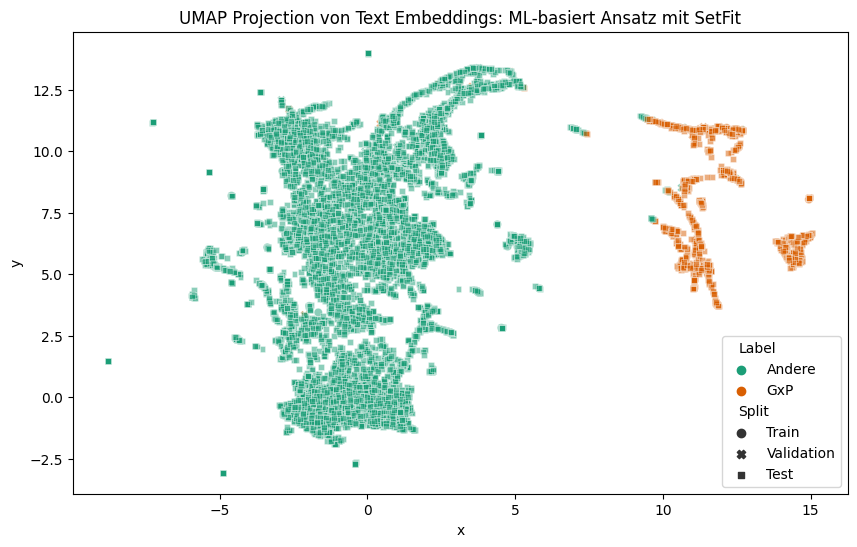

In [802]:
split_type2 = (['Train'] * len(train_embeddings) +
              ['Validation'] * len(val_embeddings) +
              ['Test'] * len(test_embeddings))

all_labels2 = list(train_labels) + list(val_labels) + list(test_labels)
class_labels2 = ['GxP' if y == 1 else 'Andere' for y in all_labels2]

embeddingplt2 = umap.UMAP(random_state=42).fit_transform(embedding2)

df_plot2 = pd.DataFrame(embeddingplt2, columns=["x", "y"])
df_plot2["Dataset"] = split_type2
df_plot2["Label"] = class_labels2
df_plot2['Split'] = df_plot2['Dataset']

# Visualisierung
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_plot2, x='x', y='y', hue='Label', style='Split', alpha=0.5, palette='Dark2')
plt.title("UMAP Projection von Text Embeddings: ML-basiert Ansatz mit SetFit")
plt.show()

#### Schritt 5. Vergleich der Vorhersagen beider Ansätze

In [849]:
# Check der Anzahl der Label
counts_ans1 = fiori_mit_labels['label_GxP_Ansatz-1'].value_counts()
percentages_ans1 = fiori_mit_labels['label_GxP_Ansatz-1'].value_counts(normalize=True) * 100

check_ans1 = pd.concat([counts_ans1, percentages_ans1], axis=1)
check_ans1.columns = ['Anzahl', 'Prozent']

check_ans1['Prozent'] = check_ans1['Prozent'].map(lambda x: f"{x:.2f}%")
check_ans1 = check_ans1.rename_axis(None)

print("label_GxP_Ansatz-1")
print(check_ans1.to_string())

label_GxP_Ansatz-1
   Anzahl Prozent
0   12935  91.45%
1    1210   8.55%


In [852]:
# Check der Anzahl der Label
counts_ans2 = fiori_mit_labels['label_GxP_Ansatz-2'].value_counts()
percentages_ans2 = fiori_mit_labels['label_GxP_Ansatz-2'].value_counts(normalize=True) * 100

check_ans2 = pd.concat([counts_ans2, percentages_ans2], axis=1)
check_ans2.columns = ['Anzahl', 'Prozent']

check_ans2['Prozent'] = check_ans2['Prozent'].map(lambda x: f"{x:.2f}%")
check_ans2 = check_ans2.rename_axis(None)

print("label_GxP_Ansatz-2")
print(check_ans2.to_string())

label_GxP_Ansatz-2
   Anzahl Prozent
0   12626  89.26%
1    1519  10.74%


In [853]:
vergleich = fiori_mit_labels[['label_GxP_Ansatz-1', 'label_GxP_Ansatz-2']].copy()

In [854]:
# Zählung der übereinstimmenden Labels
vergleich['gleich'] = vergleich['label_GxP_Ansatz-1'] == vergleich['label_GxP_Ansatz-2']

gleich_count = vergleich['gleich'].sum()
ungleich_count = (~vergleich['gleich']).sum()

print("Übereinstimmen:", gleich_count)
print("Nicht übereinstimmen:", ungleich_count)

Übereinstimmen: 13520
Nicht übereinstimmen: 625


In [855]:
# Indizes, bei denen die Vorhersagen übereinstimmen und nicht übereinstimmen
gleiche_index = vergleich[vergleich['gleich']].index
unterschiedliche_index = vergleich[~vergleich['gleich']].index

In [856]:
fiori_mit_labels.loc[unterschiedliche_index, ['fioriId', 'label_GxP_Ansatz-1', 'label_GxP_Ansatz-2']]

,fioriId,label_GxP_Ansatz-1,label_GxP_Ansatz-2
40,ADPT,0,1
112,BMUW,0,1
174,C201,1,0
176,C203,1,0
184,CA02,0,1
...,...,...,...
13924,/SCWM/PACKSPEC,1,0
13946,/SCWM/PMATCOHU,1,0
13973,/SCWM/PSCT6,1,0
13987,/SCWM/QRSETUP,0,1


#### Visualisierung

##### Pie Chart 1

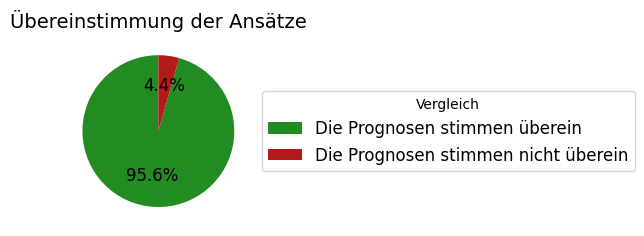

In [858]:
labels = ['Die Prognosen stimmen überein', 'Die Prognosen stimmen nicht überein']
sizes = [gleich_count, ungleich_count]

# plot
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=None,
    autopct='%1.1f%%',
    colors=['#228b22', '#b31b1b'],
    startangle=90,
    textprops={'fontsize': 12}
)

# Design-Einstellungen
ax.legend(wedges, labels, title="Vergleich", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)
ax.set_title("Übereinstimmung der Ansätze", fontsize=14)
plt.tight_layout()
plt.show()

##### Histogramm

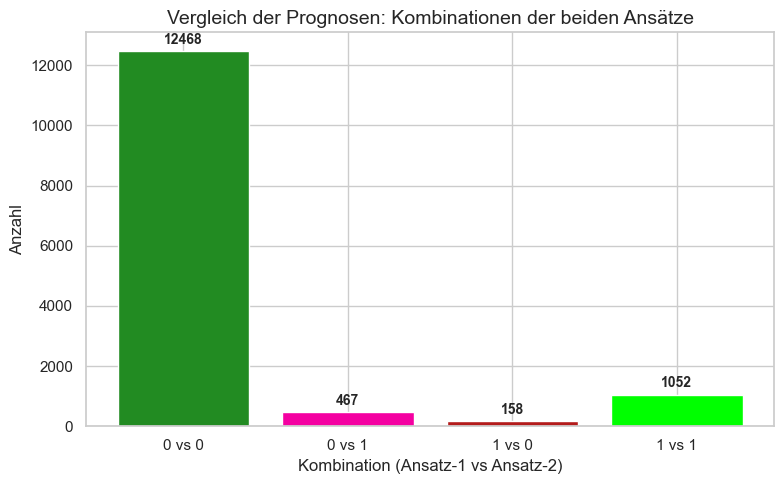

In [871]:
# Berechnung der Kombinationen von Vorhersagen
vergleich['Kombination'] = vergleich.apply(
    lambda row: f"{row['label_GxP_Ansatz-1']} vs {row['label_GxP_Ansatz-2']}", axis=1
)
kombination_counts = vergleich['Kombination'].value_counts().sort_index()

# Erstellung eines Diagramms
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(kombination_counts.index, kombination_counts.values, 
              color=['#228b22', '#f400a1', '#b31b1b', '#00ff00'])

# Hinzufügen von Werten über den Spalten
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Design-Einstellungen
ax.set_title("Vergleich der Prognosen: Kombinationen der beiden Ansätze", fontsize=14)
ax.set_ylabel("Anzahl")
ax.set_xlabel("Kombination (Ansatz-1 vs Ansatz-2)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

##### Pie Chart 2

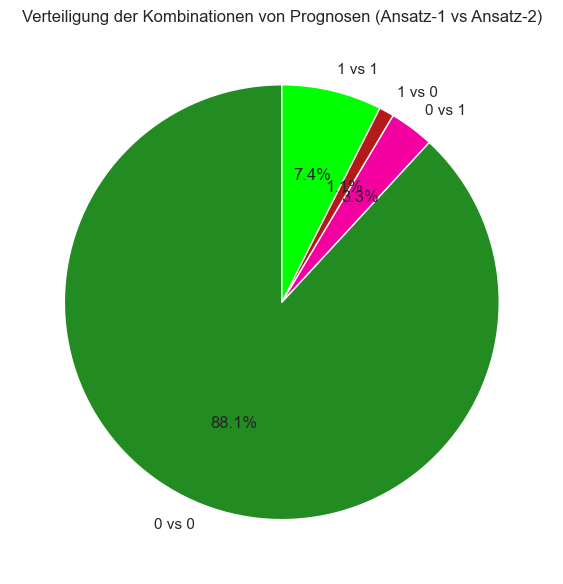

In [872]:
kombinationen = ["0 vs 0", "0 vs 1", "1 vs 0", "1 vs 1"]
farben = ['#228b22', '#f400a1', '#b31b1b', '#00ff00']
kombination_counts = kombination_counts.reindex(kombinationen)

# plot
kombination_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    ylabel='',
    figsize=(6, 6),
    colors=farben
)

plt.title("Verteiligung der Kombinationen von Prognosen (Ansatz-1 vs Ansatz-2)")
plt.tight_layout()
plt.show()